## Imports and Setup

## Data Requirements

**IMPORTANT**: This notebook expects a data file with **11 million (1.1e7) events**.

### Data Split Strategy:
- **Total**: 11M events saved in one `.npy` file
- **Training pool**: First 10M events (indices 0 to 9,999,999)
  - Each trial randomly samples 1M from this pool
- **Validation set**: Last 1M events (indices 10,000,000 to 10,999,999)
  - **FIXED** - same validation set used for all trials


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import json
import os
from pathlib import Path
from datetime import datetime

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

from nflows.flows import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms import CompositeTransform, RandomPermutation
from nflows.transforms.coupling import PiecewiseRationalQuadraticCouplingTransform
from nflows.transforms.base import Transform
from nflows.transforms import Sigmoid, InverseTransform

# Plotting setup
sns.set()
sns.set_style("ticks")
sns.set_context("paper", font_scale=1.5)
plt.rcParams['text.usetex'] = False  # Set to True if you have LaTeX
plt.rcParams['font.size'] = 12

# Device setup
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


Helper functions

In [2]:
from Amplitude import DKpp, BKpp, DalitzSample, AmpSample, SquareDalitzPlot2

# --- Particle masses ---
mD, mKs, mpi = 1.86483, 0.497611, 0.13957018
SDP = SquareDalitzPlot2(mD, mKs, mpi, mpi)

# ============================================================================
# Numerical Stability Helper
# ============================================================================

def _finite_pos(x, eps=1e-14):
    """
    Ensure array has finite positive values for numerical stability.
    """
    x = np.asarray(x)
    x = np.where(np.isfinite(x), x, 0.0)   # Replace NaN/±inf with 0
    return np.maximum(x, eps)              # Enforce minimum positive value

# ============================================================================
# Coordinate Transformation Functions
# ============================================================================

def dp_to_sdp(points_dp, sdp_obj, idx=(1,2,3)):
    """
    Convert Dalitz Plot coordinates to Square Dalitz Plot coordinates.
    """
    i, j, k = idx
    s12 = points_dp[:, 0]
    s13 = points_dp[:, 1]
    mp = np.vectorize(lambda a, b: sdp_obj.MpfromM(a, b, i, j, k), otypes=[float])(s12, s13)
    tp = np.vectorize(lambda a, b: sdp_obj.TfromM(a, b, i, j, k), otypes=[float])(s12, s13)
    return np.column_stack([mp, tp])

def sdp_to_dp(points_sdp, sdp_obj, idx=(1,2,3)):
    """
    Convert Square Dalitz Plot coordinates to Dalitz Plot coordinates.
    """
    i, j, k = idx
    out = np.empty_like(points_sdp, dtype=float)
    for n, (mp, th) in enumerate(points_sdp):
        sij, sik = sdp_obj.M_from_MpT(mp, th, i, j, k)
        out[n, 0] = sij
        out[n, 1] = sik
    return out  # columns: [s_ij, s_ik]

def swap_to_other_pair_sdp(s12, s13, sdp_obj, pair_swap=(1,3,2)):
    """
    Convert Dalitz point to SDP coordinates for a different particle pairing.
    
    Parameters
    ----------
    s12 : array_like
        Invariant mass squared s_{12} = (p_1 + p_2)^2.
    s13 : array_like
        Invariant mass squared s_{13} = (p_1 + p_3)^2.
    sdp_obj : SquareDalitzPlot2
        Square Dalitz plot object with transformation methods.
    pair_swap : tuple of int, optional
        New particle ordering (i, j, k). Default is (1, 3, 2) which
        swaps the roles of particles 2 and 3.
    
    Returns
    -------
    ndarray, shape (N, 2)
        SDP coordinates [m', theta'] for the swapped pairing.
    
    Notes
    -----
    This is used to compute |A_D(s_{13}, s_{12})| from a flow trained
    on |A_D(s_{12}, s_{13})|. The CP-conjugate amplitude corresponds
    to swapping the pi+ and pi- labels, which is equivalent to
    swapping s12 <-> s13.
    
    Example:
    If the flow is trained on (K_S pi-) vs (K_S pi+) [i.e., s12 vs s13],
    then to evaluate at the CP-conjugate point we need to query the
    flow at the SDP coordinates corresponding to (s13, s12).
    """
    i2, j2, k2 = pair_swap
    s12 = np.asarray(s12)
    s13 = np.asarray(s13)
    mp13 = np.empty_like(s12)
    th13 = np.empty_like(s12)
    for n in range(s12.size):
        mp13[n] = sdp_obj.MpfromM(s13[n], s12[n], i2, j2, k2)
        th13[n] = sdp_obj.TfromM(s13[n], s12[n], i2, j2, k2)
    return np.column_stack([mp13, th13])

def sdp_uniform_mc(N, eps=1e-6):
    """
    Generate uniform Monte Carlo points in Square Dalitz Plot coordinates.
    """
    return np.random.rand(N, 2) * (1 - 2*eps) + eps

# ============================================================================
# Amplitude Extraction from Normalizing Flows
# ============================================================================

def mag_AD_from_flow(points_sdp, flow, sdp_obj, idx=(1,2,3), device=None, tiny=1e-300):
    """
    Extract amplitude magnitude from normalizing flow probability density.
    
    Parameters
    ----------
    points_sdp : ndarray, shape (N, 2)
        Square Dalitz Plot points [m', theta'].
    flow : Flow
        Trained normalizing flow model representing p(m', theta') ∝ |A_D|^2.
    sdp_obj : SquareDalitzPlot2
        Square Dalitz plot transformation object.
    idx : tuple of int, optional
        Particle indices (i, j, k). Default is (1, 2, 3).
    device : torch.device, optional
        Device for PyTorch computation. If None, inferred from flow.
    tiny : float, optional
        Small number to prevent division by zero (default: 1e-300).
    
    Returns
    -------
    mag : ndarray, shape (N,)
        Amplitude magnitude |A_D(s_{ij}, s_{ik})| in Dalitz plot normalization.
    invJ : ndarray, shape (N,)
        Inverse Jacobian 1/|J| = 1/|∂(m',θ')/∂(s_{ij},s_{ik})|.
    
    **Implementation:**
    
    1. Evaluate flow density: p_SDP(m', θ') = exp(flow.log_prob(m', θ'))
    2. Transform (m', θ') -> (s_{ij}, s_{ik}) to get Dalitz coordinates
    3. Compute Jacobian J(s_{ij}, s_{ik}) of the transformation
    4. Return |A_D| = √(p_SDP · J) and inverse Jacobian 1/J
    
    The inverse Jacobian 1/J is also returned because it's needed for
    converting other probability densities between SDP and DP measures.
    
    """
    if device is None:
        device = next(flow.parameters()).device

    # Evaluate flow probability density in SDP coordinates
    import torch
    pts = torch.from_numpy(np.ascontiguousarray(points_sdp)).float().to(device)
    with torch.no_grad():
        logp = flow.log_prob(pts).cpu().numpy()
    p_sdp = np.exp(logp)

    # Transform each (m', θ') -> (s_ij, s_ik) and compute Jacobian
    u = points_sdp[:, 0]
    v = points_sdp[:, 1]
    sij = np.empty_like(u)
    sik = np.empty_like(u)
    
    for n, (uu, vv) in enumerate(points_sdp):
        s12, s13 = sdp_obj.M_from_MpT(uu, vv, *idx)
        sij[n], sik[n] = s12, s13

    # Compute Jacobian at each Dalitz point
    J = np.empty_like(u)
    for n in range(u.size):
        J[n] = float(sdp_obj.jacobian(sij[n], sik[n], *idx))

    # Extract DP-normalized amplitude magnitude
    # |A_D|² ∝ p_DP = p_SDP * J
    # |A_D| = √(p_SDP * J) = √(p_SDP / (1/J))
    mag = np.sqrt(p_sdp / np.maximum(1/J, tiny))
    
    return mag, 1/J


## Dataset Class

In [3]:
class DalitzDataset(Dataset):
    """
    PyTorch Dataset for Dalitz plot coordinates.

    Args:
        data: numpy array or torch tensor of shape (N, 2)
    """
    def __init__(self, data):
        if isinstance(data, np.ndarray):
            self.data = torch.FloatTensor(data)
        else:
            self.data = data

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return self.data[idx]

In [5]:
from DKpp import DKppCorrelated, CorrSample
from Amplitude import SquareDalitzPlot2

# Generate 11M CP-odd events
totalpoints = 11_000_000
Sampler = AmpSample(DKppCorrelated(cp=-1))  # cp=-1 for CP-odd
points = Sampler.generate(totalpoints, nbatch=50000)
S12_plus, S13_plus = points[:, 0], points[:, 1]

def dp_to_sdp(points_dp, sdp_obj, idx=(1,2,3)):
    """Vectorized DP -> SDP for an array of [s12, s13]."""
    i,j,k = idx
    s12 = points_dp[:,0]; s13 = points_dp[:,1]
    mp  = np.vectorize(lambda a,b: sdp_obj.MpfromM(a, b, i, j, k), otypes=[float])(s12, s13)
    tp  = np.vectorize(lambda a,b: sdp_obj.TfromM(a, b, i, j, k), otypes=[float])(s12, s13)
    return np.column_stack([mp, tp])

# Convert to SDP coordinates
S12S13 = np.array([np.array([S12_plus[i], S13_plus[i]]) for i in range(totalpoints)])
mD, mKs, mpi = 1.86483, 0.497611, 0.13957018
SDP = SquareDalitzPlot2(mD, mKs, mpi, mpi)
D_sdp = dp_to_sdp(S12S13, SDP, idx=(1,2,3))

# Save
np.save('D_Kspipi_odd_SDP_1.1e7.npy', D_sdp)

## Model Architecture

In [6]:
class MLP(nn.Module):
    """
    Multi-layer perceptron for conditioning in coupling layers.

    Args:
        in_features: Input dimension
        out_features: Output dimension
        hidden: Hidden layer size
        layers: Number of hidden layers
        output_scale: Scaling factor for output (for stability)
    """
    def __init__(self, in_features, out_features,
                 hidden=64, layers=2, output_scale=0.30):
        super().__init__()
        # Build feed-forward network
        feats = [nn.Linear(in_features, hidden), nn.SiLU()]
        for _ in range(layers - 1):
            feats += [nn.Linear(hidden, hidden), nn.SiLU()]
        self.backbone = nn.Sequential(*feats)
        self.head = nn.Linear(hidden, out_features)

        # Zero initialization for numerical stability
        nn.init.zeros_(self.head.weight)
        nn.init.zeros_(self.head.bias)

        self.output_scale = output_scale

    def forward(self, x, context=None):
        h = self.backbone(x)
        return self.head(h) * self.output_scale

In [7]:
def create_flow(on_unit_box=True, num_flows=8, hidden_features=64, num_bins=8):
    """
    Create a normalizing flow model using Neural Spline Flows.

    Args:
        on_unit_box: If True, use logit transform for [0,1]^2 domain
        num_flows: Number of coupling layers
        hidden_features: Size of hidden layers in conditioner MLPs
        num_bins: Number of bins in rational quadratic splines

    Returns:
        Flow model
    """
    dim = 2
    transforms = []

    if on_unit_box:
        # Logit pre-transform: (0,1) → ℝ
        transforms.append(InverseTransform(Sigmoid()))

    # Alternating masked coupling layers
    masks = [torch.tensor([1, 0], dtype=torch.bool),
             torch.tensor([0, 1], dtype=torch.bool)]

    for i in range(num_flows):
        mask = masks[i % 2]

        def conditioner(in_features, out_features, _hidden=hidden_features):
            return MLP(in_features, out_features, hidden=_hidden, layers=2)

        transforms.append(
            PiecewiseRationalQuadraticCouplingTransform(
                mask=mask,
                transform_net_create_fn=conditioner,
                num_bins=num_bins,
                tails="linear",
                tail_bound=5.0,
                apply_unconditional_transform=False,
            )
        )
        transforms.append(RandomPermutation(features=dim))

    transform = CompositeTransform(transforms)
    base = StandardNormal(shape=[dim])
    return Flow(transform, base)

## Early Stopping Class

In [8]:
class EarlyStopping:
    """
    Early stopping handler to stop training when validation loss plateaus.

    Args:
        patience: Number of epochs to wait for improvement
        min_delta: Minimum change to qualify as improvement
        mode: 'min' for loss (lower is better)
        verbose: Print messages
    """
    def __init__(self, patience=10, min_delta=1e-4, mode='min', verbose=True):
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.verbose = verbose

        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_epoch = 0

        if mode == 'min':
            self.is_better = lambda new, best: new < best - min_delta
        else:
            self.is_better = lambda new, best: new > best + min_delta

    def __call__(self, score, epoch):
        if self.best_score is None:
            self.best_score = score
            self.best_epoch = epoch
            return False

        if self.is_better(score, self.best_score):
            self.best_score = score
            self.best_epoch = epoch
            self.counter = 0
            if self.verbose:
                print(f"  → Validation improved to {score:.6f}")
        else:
            self.counter += 1
            if self.verbose:
                print(f"  → No improvement for {self.counter}/{self.patience} epochs")

            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print(f"Early stopping triggered! Best was epoch {self.best_epoch}")
                return True

        return False

## Training Function with Validation and Early Stopping

In [9]:
def train_flow_with_validation(
    flow,
    train_loader,
    val_loader=None,
    lr=1e-3,
    max_epochs=200,
    patience=10,
    min_delta=1e-4,
    checkpoint_path=None,
    device="cuda" if torch.cuda.is_available() else "cpu"
):
    """
    Train flow with validation monitoring and early stopping.

    Args:
        flow: Flow model
        train_loader: Training data loader
        val_loader: Validation data loader (optional)
        lr: Initial learning rate
        max_epochs: Maximum number of epochs
        patience: Early stopping patience
        min_delta: Minimum improvement for early stopping
        checkpoint_path: Path to save best model
        device: Device for training

    Returns:
        flow: Trained model
        history: Dictionary with training history
    """
    flow = flow.to(device)

    # Optimizer and scheduler
    optimizer = torch.optim.Adam(flow.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.5, patience=5, min_lr=1e-6
    )

    # Early stopping
    use_early_stopping = val_loader is not None
    if use_early_stopping:
        early_stopping = EarlyStopping(patience=patience, min_delta=min_delta)

    # History tracking
    history = {
        'train_loss': [],
        'val_loss': [],
        'learning_rate': [],
        'epochs_trained': 0,
        'stopped_early': False,
        'best_epoch': 0
    }

    best_val_loss = float('inf')

    # Training loop
    for epoch in tqdm(range(1, max_epochs + 1), desc="Training", ncols=80):
        # ===== Training =====
        flow.train()
        train_loss = 0.0
        for xb in train_loader:
            xb = xb.to(device)

            # Negative log-likelihood
            loss = -flow.log_prob(xb).mean()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * xb.size(0)

        train_loss /= len(train_loader.dataset)
        history['train_loss'].append(train_loss)

        # ===== Validation =====
        val_loss = None
        if val_loader is not None:
            flow.eval()
            val_loss = 0.0
            with torch.no_grad():
                for xb in val_loader:
                    xb = xb.to(device)
                    loss = -flow.log_prob(xb).mean()
                    val_loss += loss.item() * xb.size(0)

            val_loss /= len(val_loader.dataset)
            history['val_loss'].append(val_loss)

            # Save best model
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                history['best_epoch'] = epoch
                if checkpoint_path:
                    torch.save({
                        'epoch': epoch,
                        'model_state_dict': flow.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'train_loss': train_loss,
                        'val_loss': val_loss,
                    }, checkpoint_path)

        # Learning rate scheduling
        scheduler.step(val_loss if val_loss is not None else train_loss)
        current_lr = optimizer.param_groups[0]['lr']
        history['learning_rate'].append(current_lr)

        # Logging
        log_msg = f"[{epoch:03d}] Train: {train_loss:.6f}"
        if val_loss is not None:
            log_msg += f", Val: {val_loss:.6f}"
        log_msg += f", LR: {current_lr:.2e}"
        print(log_msg)

        # Early stopping check
        if use_early_stopping:
            if early_stopping(val_loss, epoch):
                history['stopped_early'] = True
                history['epochs_trained'] = epoch
                break

    if not history['stopped_early']:
        history['epochs_trained'] = max_epochs

    # Load best model if checkpoint exists
    if checkpoint_path and os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        flow.load_state_dict(checkpoint['model_state_dict'])
        print(f"\nLoaded best model from epoch {checkpoint['epoch']}")

    return flow, history

## Ensemble Training Function

In [10]:
def train_ensemble(
    data_path,
    output_dir,
    num_trials=50,
    train_pool_size=10_000_000,
    val_size=1_000_000,
    train_sample_size=1_000_000,
    batch_size=10000,
    lr=0.01,
    max_epochs=200,
    patience=15,
    min_delta=1e-5,
    num_flows=12,
    hidden_features=128,
    num_bins=12,
    device="cuda" if torch.cuda.is_available() else "cpu",
    seed_offset=0
):
    """
    Train an ensemble of flows on D-decay data with fixed validation set.

    Data splitting strategy:
    - Total data: 11M events (from data_path)
    - Training pool: 10M events (first 10M)
    - Validation set: 1M events (last 1M, FIXED for all trials)
    - Each trial: randomly sample 1M from the 10M training pool (without replacement)

    Args:
        data_path: Path to .npy file with SDP coordinates (should have 11M events)
        output_dir: Directory to save models and results
        num_trials: Number of ensemble members
        train_pool_size: Size of training pool (default: 10M)
        val_size: Size of fixed validation set (default: 1M)
        train_sample_size: Size to sample per trial from training pool (default: 1M)
        batch_size: Batch size for training
        lr: Initial learning rate
        max_epochs: Maximum epochs per trial
        patience: Early stopping patience
        min_delta: Minimum improvement for early stopping
        num_flows: Number of coupling layers
        hidden_features: Hidden layer size
        num_bins: Number of spline bins
        device: Training device
        seed_offset: Offset added to trial number for seed (default: 0)

    Returns:
        results: Dictionary with ensemble results
    """
    # Create output directory
    output_dir = Path(output_dir)
    output_dir.mkdir(exist_ok=True, parents=True)

    # Load full dataset
    print(f"Loading data from {data_path}...")
    full_data = np.load(data_path)
    print(f"Loaded {len(full_data):,} events")

    # Check data size
    expected_size = train_pool_size + val_size
    if len(full_data) < expected_size:
        print(f"WARNING: Expected {expected_size:,} events but got {len(full_data):,}")
        print(f"Adjusting sizes proportionally...")
        train_pool_size = int(len(full_data) * 0.909)  # ~10/11
        val_size = len(full_data) - train_pool_size

    # Split into training pool and FIXED validation set
    train_pool = full_data[:train_pool_size]
    val_data_fixed = full_data[train_pool_size:train_pool_size + val_size]

    print(f"\nData split:")
    print(f"  Training pool: {len(train_pool):,} events")
    print(f"  Each trial samples: {train_sample_size:,} events from pool")
    print(f"  Validation set: {len(val_data_fixed):,} events (FIXED for all trials)")

    # Save configuration
    config = {
        'num_trials': num_trials,
        'train_pool_size': len(train_pool),
        'val_size': len(val_data_fixed),
        'train_sample_size': train_sample_size,
        'batch_size': batch_size,
        'lr': lr,
        'max_epochs': max_epochs,
        'patience': patience,
        'min_delta': min_delta,
        'num_flows': num_flows,
        'hidden_features': hidden_features,
        'num_bins': num_bins,
        'device': device,
        'data_path': str(data_path),
        'timestamp': datetime.now().isoformat(),
        'note': 'Fixed validation set (last 1M), each trial samples from first 10M training pool'
    }

    with open(output_dir / 'config.json', 'w') as f:
        json.dump(config, f, indent=2)

    # Results tracking
    results = {
        'trial_histories': [],
        'best_val_losses': [],
        'epochs_trained': [],
        'stopped_early': []
    }

    # Create fixed validation dataloader (used for ALL trials)
    val_dataset = DalitzDataset(val_data_fixed)
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=(device == "cuda")
    )

    # Train ensemble
    for trial in range(1, num_trials + 1):
        print(f"\n{'='*80}")
        print(f"TRIAL {trial}/{num_trials}")
        print(f"{'='*80}")

        # Set seed for reproducibility
        seed = trial + seed_offset
        print(f"Using seed: {seed} (trial={trial}, offset={seed_offset})")
        np.random.seed(seed)
        torch.manual_seed(seed)

        # Sample from training pool (without replacement for diversity)
        if train_sample_size > len(train_pool):
            print(f"WARNING: train_sample_size ({train_sample_size:,}) > pool size ({len(train_pool):,})")
            print(f"Using entire training pool")
            train_data = train_pool
        else:
            indices = np.random.choice(len(train_pool), size=train_sample_size, replace=False)
            train_data = train_pool[indices]

        print(f"Training on: {len(train_data):,} events (sampled from pool)")
        print(f"Validating on: {len(val_data_fixed):,} events (fixed set)")

        # Create training dataloader
        train_dataset = DalitzDataset(train_data)
        train_loader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=0,
            pin_memory=(device == "cuda")
        )

        # Create model
        flow = create_flow(
            num_flows=num_flows,
            hidden_features=hidden_features,
            num_bins=num_bins
        )

        # Print model info (first trial only)
        if trial == 1:
            total_params = sum(p.numel() for p in flow.parameters())
            print(f"Model parameters: {total_params:,}")

        # Train
        checkpoint_path = output_dir / f"trial_seed{seed}_best.pth"
        flow, history = train_flow_with_validation(
            flow,
            train_loader,
            val_loader,
            lr=lr,
            max_epochs=max_epochs,
            patience=patience,
            min_delta=min_delta,
            checkpoint_path=checkpoint_path,
            device=device
        )

        # Save final model
        final_path = output_dir / f"trial_seed{seed}.pth"
        torch.save(flow.state_dict(), final_path)

        # Save history
        history_path = output_dir / f"trial_seed{seed}_history.json"
        with open(history_path, 'w') as f:
            json.dump(history, f, indent=2)

        # Record results
        results['trial_histories'].append(history)
        results['best_val_losses'].append(min(history['val_loss']))
        results['epochs_trained'].append(history['epochs_trained'])
        results['stopped_early'].append(history['stopped_early'])

        print(f"\nTrial {trial} complete:")
        print(f"  Best val loss: {min(history['val_loss']):.6f}")
        print(f"  Epochs trained: {history['epochs_trained']}")
        print(f"  Early stopped: {history['stopped_early']}")

    # Summary statistics
    print(f"\n{'='*80}")
    print("ENSEMBLE SUMMARY")
    print(f"{'='*80}")
    print(f"Trials completed: {num_trials}")
    print(f"Best val loss: {np.min(results['best_val_losses']):.6f}")
    print(f"Mean val loss: {np.mean(results['best_val_losses']):.6f} ± {np.std(results['best_val_losses']):.6f}")
    print(f"Mean epochs: {np.mean(results['epochs_trained']):.1f} ± {np.std(results['epochs_trained']):.1f}")
    print(f"Early stopped: {sum(results['stopped_early'])}/{num_trials}")

    # Save summary
    summary = {
        'num_trials': num_trials,
        'train_pool_size': len(train_pool),
        'val_size': len(val_data_fixed),
        'train_sample_size': train_sample_size,
        'best_val_loss': float(np.min(results['best_val_losses'])),
        'mean_val_loss': float(np.mean(results['best_val_losses'])),
        'std_val_loss': float(np.std(results['best_val_losses'])),
        'mean_epochs': float(np.mean(results['epochs_trained'])),
        'std_epochs': float(np.std(results['epochs_trained'])),
        'num_early_stopped': int(sum(results['stopped_early']))
    }

    with open(output_dir / 'summary.json', 'w') as f:
        json.dump(summary, f, indent=2)

    return results

---
# Usage Examples

Below are different ways to use the optimized training code.

## Example 1: Train a Single Model with Early Stopping

In [11]:
# Load data (expecting 11M events total)
data = np.load('D_Kspipi_odd_SDP_1.1e7.npy')
print(f"Loaded {len(data):,} events")

# Split: first 10M for training pool, last 1M for validation
train_pool_size = 10_000_000
val_size = 1_000_000

if len(data) < train_pool_size + val_size:
    print(f"WARNING: Need {train_pool_size + val_size:,} events, but only have {len(data):,}")
    train_pool_size = int(len(data) * 0.909)  # ~10/11
    val_size = len(data) - train_pool_size

train_pool = data[:train_pool_size]
val_data = data[train_pool_size:train_pool_size + val_size]

print(f"Training pool: {len(train_pool):,}, Validation: {len(val_data):,}")

# Sample 1M from the training pool (same as ensemble strategy)
np.random.seed(42)  # For reproducibility
sample_size = 1_000_000
indices = np.random.choice(len(train_pool), size=sample_size, replace=False)
train_data = train_pool[indices]

print(f"Sampled {len(train_data):,} events from training pool for this model")

# Create datasets and loaders
train_dataset = DalitzDataset(train_data)
val_dataset = DalitzDataset(val_data)

train_loader = DataLoader(train_dataset, batch_size=10000, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=10000, shuffle=False)

# Create model
flow = create_flow(
    num_flows=16,
    hidden_features=128,
    num_bins=16
)

# Print model info
total_params = sum(p.numel() for p in flow.parameters())
print(f"Model parameters: {total_params:,}")

# Train with early stopping
flow, history = train_flow_with_validation(
    flow,
    train_loader,
    val_loader,
    lr=0.01,
    max_epochs=200,
    patience=15,              # Stop if no improvement for 15 epochs
    min_delta=1e-5,           # Minimum improvement threshold
    checkpoint_path="single_model_best.pth",
    device=device
)

# Save final model
torch.save(flow.state_dict(), "single_model_final.pth")

# Print summary
print("\n" + "="*80)
print("Training Summary")
print("="*80)
print(f"Epochs trained: {history['epochs_trained']}")
print(f"Best validation loss: {min(history['val_loss']):.6f}")
print(f"Final training loss: {history['train_loss'][-1]:.6f}")
print(f"Early stopped: {history['stopped_early']}")

Loaded 11,000,000 events
Training pool: 10,000,000, Validation: 1,000,000
Sampled 1,000,000 events from training pool for this model
Model parameters: 365,296


Training:   0%|                                         | 0/200 [00:00<?, ?it/s]/Users/san/opt/anaconda3/lib/python3.9/site-packages/nflows/transforms/coupling.py:561: UserWarning: Inputs to the softmax are not scaled down: initialization might be bad.
  warnings.warn(
Training:   0%|▏                              | 1/200 [01:36<5:19:31, 96.34s/it]

[001] Train: 0.006485, Val: -0.877820, LR: 1.00e-02


Training:   1%|▎                              | 2/200 [03:07<5:08:09, 93.38s/it]

[002] Train: -0.893444, Val: -0.927724, LR: 1.00e-02
  → Validation improved to -0.927724


Training:   2%|▍                              | 3/200 [04:45<5:12:34, 95.20s/it]

[003] Train: -0.906209, Val: -0.917440, LR: 1.00e-02
  → No improvement for 1/15 epochs


Training:   2%|▌                              | 4/200 [06:24<5:16:28, 96.88s/it]

[004] Train: -0.918851, Val: -0.930339, LR: 1.00e-02
  → Validation improved to -0.930339


Training:   2%|▊                              | 5/200 [08:05<5:19:11, 98.21s/it]

[005] Train: -0.922728, Val: -0.935724, LR: 1.00e-02
  → Validation improved to -0.935724


Training:   3%|▉                              | 6/200 [09:45<5:20:04, 98.99s/it]

[006] Train: -0.932782, Val: -0.942681, LR: 1.00e-02
  → Validation improved to -0.942681


Training:   4%|█                              | 7/200 [11:23<5:17:11, 98.61s/it]

[007] Train: -0.934628, Val: -0.947783, LR: 1.00e-02
  → Validation improved to -0.947783


Training:   4%|█▏                             | 8/200 [13:03<5:16:55, 99.04s/it]

[008] Train: -0.934076, Val: -0.930203, LR: 1.00e-02
  → No improvement for 1/15 epochs


Training:   4%|█▎                            | 9/200 [16:12<6:44:58, 127.22s/it]

[009] Train: -0.939091, Val: -0.949292, LR: 1.00e-02
  → Validation improved to -0.949292


Training:   5%|█▍                           | 10/200 [18:59<7:21:20, 139.37s/it]

[010] Train: -0.940013, Val: -0.951773, LR: 1.00e-02
  → Validation improved to -0.951773


Training:   6%|█▌                           | 11/200 [20:30<6:32:55, 124.74s/it]

[011] Train: -0.939037, Val: -0.947696, LR: 1.00e-02
  → No improvement for 1/15 epochs


Training:   6%|█▋                           | 12/200 [22:06<6:03:20, 115.96s/it]

[012] Train: -0.947447, Val: -0.951516, LR: 1.00e-02
  → No improvement for 2/15 epochs


Training:   6%|█▉                           | 13/200 [23:41<5:41:50, 109.68s/it]

[013] Train: -0.940296, Val: -0.935716, LR: 1.00e-02
  → No improvement for 3/15 epochs


Training:   7%|██                           | 14/200 [25:12<5:22:22, 103.99s/it]

[014] Train: -0.945258, Val: -0.953825, LR: 1.00e-02
  → Validation improved to -0.953825


Training:   8%|██▏                          | 15/200 [26:46<5:10:56, 100.85s/it]

[015] Train: -0.946498, Val: -0.943421, LR: 1.00e-02
  → No improvement for 1/15 epochs


Training:   8%|██▍                           | 16/200 [28:16<4:59:28, 97.66s/it]

[016] Train: -0.946157, Val: -0.948298, LR: 1.00e-02
  → No improvement for 2/15 epochs


Training:   8%|██▌                           | 17/200 [29:58<5:02:13, 99.09s/it]

[017] Train: -0.942949, Val: -0.955903, LR: 1.00e-02
  → Validation improved to -0.955903


Training:   9%|██▋                           | 18/200 [31:30<4:53:59, 96.92s/it]

[018] Train: -0.948231, Val: -0.945357, LR: 1.00e-02
  → No improvement for 1/15 epochs


Training:  10%|██▊                           | 19/200 [33:13<4:57:42, 98.69s/it]

[019] Train: -0.946072, Val: -0.954226, LR: 1.00e-02
  → No improvement for 2/15 epochs


Training:  10%|███                           | 20/200 [34:45<4:50:27, 96.82s/it]

[020] Train: -0.948997, Val: -0.939008, LR: 1.00e-02
  → No improvement for 3/15 epochs


Training:  10%|███▏                          | 21/200 [36:13<4:40:35, 94.05s/it]

[021] Train: -0.946163, Val: -0.952519, LR: 1.00e-02
  → No improvement for 4/15 epochs


Training:  11%|███▎                          | 22/200 [37:43<4:35:40, 92.93s/it]

[022] Train: -0.948696, Val: -0.953415, LR: 1.00e-02
  → No improvement for 5/15 epochs


Training:  12%|███▍                          | 23/200 [39:04<4:23:28, 89.32s/it]

[023] Train: -0.948142, Val: -0.952584, LR: 5.00e-03
  → No improvement for 6/15 epochs


Training:  12%|███▌                          | 24/200 [40:33<4:21:26, 89.13s/it]

[024] Train: -0.959381, Val: -0.959228, LR: 5.00e-03
  → Validation improved to -0.959228


Training:  12%|███▊                          | 25/200 [41:59<4:17:10, 88.17s/it]

[025] Train: -0.959961, Val: -0.961648, LR: 5.00e-03
  → Validation improved to -0.961648


Training:  13%|███▉                          | 26/200 [43:22<4:11:38, 86.78s/it]

[026] Train: -0.960748, Val: -0.960932, LR: 5.00e-03
  → No improvement for 1/15 epochs


Training:  14%|████                          | 27/200 [44:46<4:07:10, 85.73s/it]

[027] Train: -0.960420, Val: -0.960536, LR: 5.00e-03
  → No improvement for 2/15 epochs


Training:  14%|████▏                         | 28/200 [46:10<4:04:35, 85.32s/it]

[028] Train: -0.959909, Val: -0.960138, LR: 5.00e-03
  → No improvement for 3/15 epochs


Training:  14%|████▎                         | 29/200 [47:35<4:02:34, 85.12s/it]

[029] Train: -0.959444, Val: -0.959440, LR: 5.00e-03
  → No improvement for 4/15 epochs


Training:  15%|████▌                         | 30/200 [49:00<4:00:53, 85.02s/it]

[030] Train: -0.958573, Val: -0.958395, LR: 5.00e-03
  → No improvement for 5/15 epochs


Training:  16%|████▋                         | 31/200 [50:23<3:58:27, 84.66s/it]

[031] Train: -0.958111, Val: -0.960107, LR: 2.50e-03
  → No improvement for 6/15 epochs


Training:  16%|████▊                         | 32/200 [51:50<3:59:00, 85.36s/it]

[032] Train: -0.963025, Val: -0.964821, LR: 2.50e-03
  → Validation improved to -0.964821


Training:  16%|████▉                         | 33/200 [53:17<3:58:34, 85.71s/it]

[033] Train: -0.963065, Val: -0.963362, LR: 2.50e-03
  → No improvement for 1/15 epochs


Training:  17%|█████                         | 34/200 [54:42<3:56:22, 85.44s/it]

[034] Train: -0.962603, Val: -0.962287, LR: 2.50e-03
  → No improvement for 2/15 epochs


Training:  18%|█████▎                        | 35/200 [56:07<3:54:57, 85.44s/it]

[035] Train: -0.962707, Val: -0.963500, LR: 2.50e-03
  → No improvement for 3/15 epochs


Training:  18%|█████▍                        | 36/200 [57:33<3:53:58, 85.60s/it]

[036] Train: -0.962583, Val: -0.962607, LR: 2.50e-03
  → No improvement for 4/15 epochs


Training:  18%|█████▌                        | 37/200 [58:57<3:51:05, 85.07s/it]

[037] Train: -0.962742, Val: -0.960685, LR: 2.50e-03
  → No improvement for 5/15 epochs


Training:  19%|█████▎                      | 38/200 [1:00:24<3:51:03, 85.58s/it]

[038] Train: -0.961302, Val: -0.961542, LR: 1.25e-03
  → No improvement for 6/15 epochs


Training:  20%|█████▍                      | 39/200 [1:01:50<3:50:24, 85.87s/it]

[039] Train: -0.964618, Val: -0.963700, LR: 1.25e-03
  → No improvement for 7/15 epochs


Training:  20%|█████▌                      | 40/200 [1:03:17<3:50:04, 86.28s/it]

[040] Train: -0.965050, Val: -0.963839, LR: 1.25e-03
  → No improvement for 8/15 epochs


Training:  20%|█████▋                      | 41/200 [1:04:40<3:45:40, 85.16s/it]

[041] Train: -0.964828, Val: -0.964815, LR: 1.25e-03
  → No improvement for 9/15 epochs


Training:  21%|█████▉                      | 42/200 [1:05:58<3:38:51, 83.11s/it]

[042] Train: -0.965086, Val: -0.964990, LR: 1.25e-03
  → Validation improved to -0.964990


Training:  22%|██████                      | 43/200 [1:07:20<3:36:24, 82.71s/it]

[043] Train: -0.965128, Val: -0.964915, LR: 1.25e-03
  → No improvement for 1/15 epochs


Training:  22%|██████▏                     | 44/200 [1:08:46<3:37:39, 83.72s/it]

[044] Train: -0.964846, Val: -0.965259, LR: 1.25e-03
  → Validation improved to -0.965259


Training:  22%|██████▎                     | 45/200 [1:10:09<3:35:43, 83.51s/it]

[045] Train: -0.964689, Val: -0.963056, LR: 1.25e-03
  → No improvement for 1/15 epochs


Training:  23%|██████▍                     | 46/200 [1:11:27<3:29:34, 81.65s/it]

[046] Train: -0.964339, Val: -0.961067, LR: 1.25e-03
  → No improvement for 2/15 epochs


Training:  24%|██████▌                     | 47/200 [1:12:42<3:23:42, 79.88s/it]

[047] Train: -0.964238, Val: -0.964594, LR: 1.25e-03
  → No improvement for 3/15 epochs


Training:  24%|██████▋                     | 48/200 [1:14:02<3:22:20, 79.87s/it]

[048] Train: -0.964103, Val: -0.965258, LR: 1.25e-03
  → No improvement for 4/15 epochs


Training:  24%|██████▊                     | 49/200 [1:15:24<3:22:53, 80.62s/it]

[049] Train: -0.964532, Val: -0.964277, LR: 1.25e-03
  → No improvement for 5/15 epochs


Training:  25%|███████                     | 50/200 [1:16:45<3:21:48, 80.72s/it]

[050] Train: -0.964570, Val: -0.965536, LR: 1.25e-03
  → Validation improved to -0.965536


Training:  26%|███████▏                    | 51/200 [1:18:07<3:21:07, 80.99s/it]

[051] Train: -0.964000, Val: -0.963577, LR: 1.25e-03
  → No improvement for 1/15 epochs


Training:  26%|███████▎                    | 52/200 [1:19:28<3:19:45, 80.99s/it]

[052] Train: -0.963263, Val: -0.963231, LR: 1.25e-03
  → No improvement for 2/15 epochs


Training:  26%|███████▍                    | 53/200 [1:20:49<3:18:05, 80.85s/it]

[053] Train: -0.963947, Val: -0.963115, LR: 1.25e-03
  → No improvement for 3/15 epochs


Training:  27%|███████▌                    | 54/200 [1:22:11<3:17:50, 81.31s/it]

[054] Train: -0.964145, Val: -0.964384, LR: 1.25e-03
  → No improvement for 4/15 epochs


Training:  28%|███████▋                    | 55/200 [1:23:32<3:16:33, 81.34s/it]

[055] Train: -0.964162, Val: -0.964349, LR: 1.25e-03
  → No improvement for 5/15 epochs


Training:  28%|███████▊                    | 56/200 [1:24:53<3:15:03, 81.28s/it]

[056] Train: -0.963726, Val: -0.963524, LR: 6.25e-04
  → No improvement for 6/15 epochs


Training:  28%|███████▉                    | 57/200 [1:26:17<3:14:57, 81.80s/it]

[057] Train: -0.965956, Val: -0.966086, LR: 6.25e-04
  → Validation improved to -0.966086


Training:  29%|████████                    | 58/200 [1:27:39<3:14:07, 82.03s/it]

[058] Train: -0.966002, Val: -0.966267, LR: 6.25e-04
  → Validation improved to -0.966267


Training:  30%|████████▎                   | 59/200 [1:29:02<3:13:06, 82.17s/it]

[059] Train: -0.965855, Val: -0.966059, LR: 6.25e-04
  → No improvement for 1/15 epochs


Training:  30%|████████▍                   | 60/200 [1:30:22<3:10:38, 81.70s/it]

[060] Train: -0.965787, Val: -0.966159, LR: 6.25e-04
  → No improvement for 2/15 epochs


Training:  30%|████████▌                   | 61/200 [1:31:46<3:10:56, 82.42s/it]

[061] Train: -0.965798, Val: -0.965235, LR: 6.25e-04
  → No improvement for 3/15 epochs


Training:  31%|████████▋                   | 62/200 [1:33:08<3:09:19, 82.31s/it]

[062] Train: -0.965799, Val: -0.964203, LR: 6.25e-04
  → No improvement for 4/15 epochs


Training:  32%|████████▊                   | 63/200 [1:34:30<3:07:15, 82.01s/it]

[063] Train: -0.965736, Val: -0.965765, LR: 6.25e-04
  → No improvement for 5/15 epochs


Training:  32%|████████▉                   | 64/200 [1:35:50<3:05:01, 81.63s/it]

[064] Train: -0.965806, Val: -0.964889, LR: 3.13e-04
  → No improvement for 6/15 epochs


Training:  32%|█████████                   | 65/200 [1:37:14<3:05:06, 82.27s/it]

[065] Train: -0.966817, Val: -0.966271, LR: 3.13e-04
  → No improvement for 7/15 epochs


Training:  33%|█████████▏                  | 66/200 [1:38:37<3:03:56, 82.36s/it]

[066] Train: -0.966820, Val: -0.966536, LR: 3.13e-04
  → Validation improved to -0.966536


Training:  34%|█████████▍                  | 67/200 [1:39:57<3:01:03, 81.68s/it]

[067] Train: -0.966958, Val: -0.966669, LR: 3.13e-04
  → Validation improved to -0.966669


Training:  34%|█████████▌                  | 68/200 [1:41:19<2:59:57, 81.80s/it]

[068] Train: -0.966929, Val: -0.966635, LR: 3.13e-04
  → No improvement for 1/15 epochs


Training:  34%|█████████▋                  | 69/200 [1:42:38<2:56:56, 81.04s/it]

[069] Train: -0.966788, Val: -0.966816, LR: 3.13e-04
  → Validation improved to -0.966816


Training:  35%|█████████▊                  | 70/200 [1:43:59<2:55:20, 80.93s/it]

[070] Train: -0.966736, Val: -0.966754, LR: 3.13e-04
  → No improvement for 1/15 epochs


Training:  36%|█████████▉                  | 71/200 [1:45:21<2:54:33, 81.19s/it]

[071] Train: -0.966964, Val: -0.966836, LR: 3.13e-04
  → Validation improved to -0.966836


Training:  36%|██████████                  | 72/200 [1:46:41<2:52:53, 81.04s/it]

[072] Train: -0.966795, Val: -0.966286, LR: 3.13e-04
  → No improvement for 1/15 epochs


Training:  36%|██████████▏                 | 73/200 [1:48:03<2:51:57, 81.24s/it]

[073] Train: -0.966756, Val: -0.966256, LR: 3.13e-04
  → No improvement for 2/15 epochs


Training:  37%|██████████▎                 | 74/200 [1:49:25<2:50:46, 81.32s/it]

[074] Train: -0.966912, Val: -0.966358, LR: 3.13e-04
  → No improvement for 3/15 epochs


Training:  38%|██████████▌                 | 75/200 [1:50:45<2:49:03, 81.15s/it]

[075] Train: -0.966669, Val: -0.966527, LR: 3.13e-04
  → No improvement for 4/15 epochs


Training:  38%|██████████▋                 | 76/200 [1:52:10<2:49:58, 82.24s/it]

[076] Train: -0.966732, Val: -0.966843, LR: 3.13e-04
  → No improvement for 5/15 epochs


Training:  38%|██████████▊                 | 77/200 [1:53:31<2:47:39, 81.79s/it]

[077] Train: -0.966697, Val: -0.965898, LR: 3.13e-04
  → No improvement for 6/15 epochs


Training:  39%|██████████▉                 | 78/200 [1:54:51<2:45:27, 81.37s/it]

[078] Train: -0.966784, Val: -0.966146, LR: 3.13e-04
  → No improvement for 7/15 epochs


Training:  40%|███████████                 | 79/200 [1:56:14<2:44:52, 81.76s/it]

[079] Train: -0.966538, Val: -0.966202, LR: 3.13e-04
  → No improvement for 8/15 epochs


Training:  40%|███████████▏                | 80/200 [1:57:36<2:43:48, 81.90s/it]

[080] Train: -0.966673, Val: -0.966568, LR: 3.13e-04
  → No improvement for 9/15 epochs


Training:  40%|███████████▎                | 81/200 [1:58:58<2:42:43, 82.04s/it]

[081] Train: -0.966582, Val: -0.965972, LR: 3.13e-04
  → No improvement for 10/15 epochs


Training:  41%|███████████▍                | 82/200 [2:00:23<2:42:33, 82.66s/it]

[082] Train: -0.966675, Val: -0.966188, LR: 1.56e-04
  → No improvement for 11/15 epochs


Training:  42%|███████████▌                | 83/200 [2:01:45<2:41:01, 82.58s/it]

[083] Train: -0.967372, Val: -0.966892, LR: 1.56e-04
  → Validation improved to -0.966892


Training:  42%|███████████▊                | 84/200 [2:03:07<2:39:35, 82.55s/it]

[084] Train: -0.967437, Val: -0.966715, LR: 1.56e-04
  → No improvement for 1/15 epochs


Training:  42%|███████████▉                | 85/200 [2:04:30<2:38:00, 82.44s/it]

[085] Train: -0.967458, Val: -0.966868, LR: 1.56e-04
  → No improvement for 2/15 epochs


Training:  43%|████████████                | 86/200 [2:05:50<2:35:38, 81.92s/it]

[086] Train: -0.967468, Val: -0.966790, LR: 1.56e-04
  → No improvement for 3/15 epochs


Training:  44%|████████████▏               | 87/200 [2:07:13<2:34:37, 82.10s/it]

[087] Train: -0.967398, Val: -0.966899, LR: 1.56e-04
  → No improvement for 4/15 epochs


Training:  44%|████████████▎               | 88/200 [2:08:35<2:33:16, 82.11s/it]

[088] Train: -0.967536, Val: -0.966891, LR: 1.56e-04
  → No improvement for 5/15 epochs


Training:  44%|████████████▍               | 89/200 [2:09:56<2:31:10, 81.72s/it]

[089] Train: -0.967428, Val: -0.967061, LR: 1.56e-04
  → Validation improved to -0.967061


Training:  45%|████████████▌               | 90/200 [2:11:18<2:29:49, 81.72s/it]

[090] Train: -0.967407, Val: -0.966699, LR: 1.56e-04
  → No improvement for 1/15 epochs


Training:  46%|████████████▋               | 91/200 [2:12:39<2:28:27, 81.72s/it]

[091] Train: -0.967313, Val: -0.966853, LR: 1.56e-04
  → No improvement for 2/15 epochs


Training:  46%|████████████▉               | 92/200 [2:13:59<2:25:55, 81.07s/it]

[092] Train: -0.967290, Val: -0.966857, LR: 1.56e-04
  → No improvement for 3/15 epochs


Training:  46%|█████████████               | 93/200 [2:15:20<2:24:35, 81.08s/it]

[093] Train: -0.967407, Val: -0.966763, LR: 1.56e-04
  → No improvement for 4/15 epochs


Training:  47%|█████████████▏              | 94/200 [2:16:39<2:22:06, 80.44s/it]

[094] Train: -0.967389, Val: -0.966530, LR: 1.56e-04
  → No improvement for 5/15 epochs


Training:  48%|█████████████▎              | 95/200 [2:18:01<2:21:37, 80.93s/it]

[095] Train: -0.967395, Val: -0.966799, LR: 7.81e-05
  → No improvement for 6/15 epochs


Training:  48%|█████████████▍              | 96/200 [2:19:23<2:20:38, 81.14s/it]

[096] Train: -0.967763, Val: -0.967178, LR: 7.81e-05
  → Validation improved to -0.967178


Training:  48%|█████████████▌              | 97/200 [2:20:43<2:19:06, 81.03s/it]

[097] Train: -0.967808, Val: -0.967175, LR: 7.81e-05
  → No improvement for 1/15 epochs


Training:  49%|█████████████▋              | 98/200 [2:22:07<2:19:09, 81.86s/it]

[098] Train: -0.967820, Val: -0.967126, LR: 7.81e-05
  → No improvement for 2/15 epochs


Training:  50%|█████████████▊              | 99/200 [2:23:28<2:17:19, 81.58s/it]

[099] Train: -0.967755, Val: -0.967196, LR: 7.81e-05
  → Validation improved to -0.967196


Training:  50%|█████████████▌             | 100/200 [2:25:02<2:22:24, 85.44s/it]

[100] Train: -0.967823, Val: -0.967300, LR: 7.81e-05
  → Validation improved to -0.967300


Training:  50%|█████████████▋             | 101/200 [2:26:41<2:27:40, 89.50s/it]

[101] Train: -0.967786, Val: -0.967214, LR: 7.81e-05
  → No improvement for 1/15 epochs


Training:  51%|█████████████▊             | 102/200 [2:28:07<2:24:09, 88.26s/it]

[102] Train: -0.967788, Val: -0.967089, LR: 7.81e-05
  → No improvement for 2/15 epochs


Training:  52%|█████████████▉             | 103/200 [2:29:35<2:22:36, 88.22s/it]

[103] Train: -0.967831, Val: -0.967024, LR: 7.81e-05
  → No improvement for 3/15 epochs


Training:  52%|██████████████             | 104/200 [2:31:07<2:22:47, 89.25s/it]

[104] Train: -0.967807, Val: -0.967187, LR: 7.81e-05
  → No improvement for 4/15 epochs


Training:  52%|██████████████▏            | 105/200 [2:32:51<2:28:36, 93.85s/it]

[105] Train: -0.967807, Val: -0.967236, LR: 7.81e-05
  → No improvement for 5/15 epochs


Training:  53%|██████████████▎            | 106/200 [2:34:20<2:24:48, 92.43s/it]

[106] Train: -0.967839, Val: -0.967010, LR: 7.81e-05
  → No improvement for 6/15 epochs


Training:  54%|██████████████▍            | 107/200 [2:35:52<2:22:42, 92.07s/it]

[107] Train: -0.967766, Val: -0.967127, LR: 7.81e-05
  → No improvement for 7/15 epochs


Training:  54%|██████████████▌            | 108/200 [2:37:36<2:26:51, 95.77s/it]

[108] Train: -0.967823, Val: -0.967116, LR: 7.81e-05
  → No improvement for 8/15 epochs


Training:  55%|██████████████▋            | 109/200 [2:39:14<2:26:21, 96.50s/it]

[109] Train: -0.967801, Val: -0.967229, LR: 7.81e-05
  → No improvement for 9/15 epochs


Training:  55%|██████████████▊            | 110/200 [2:40:51<2:25:08, 96.76s/it]

[110] Train: -0.967835, Val: -0.967148, LR: 7.81e-05
  → No improvement for 10/15 epochs


Training:  56%|██████████████▉            | 111/200 [2:42:26<2:22:42, 96.20s/it]

[111] Train: -0.967822, Val: -0.967235, LR: 7.81e-05
  → No improvement for 11/15 epochs


Training:  56%|███████████████            | 112/200 [2:44:04<2:21:42, 96.62s/it]

[112] Train: -0.967755, Val: -0.967093, LR: 7.81e-05
  → No improvement for 12/15 epochs


Training:  56%|███████████████▎           | 113/200 [2:45:44<2:21:22, 97.50s/it]

[113] Train: -0.967817, Val: -0.967108, LR: 7.81e-05
  → No improvement for 13/15 epochs


Training:  57%|███████████████▍           | 114/200 [2:47:23<2:20:41, 98.16s/it]

[114] Train: -0.967804, Val: -0.967023, LR: 7.81e-05
  → No improvement for 14/15 epochs


Training:  57%|███████████████▍           | 114/200 [2:48:59<2:07:29, 88.95s/it]

[115] Train: -0.967688, Val: -0.966992, LR: 7.81e-05
  → No improvement for 15/15 epochs
Early stopping triggered! Best was epoch 100

Loaded best model from epoch 100

Training Summary
Epochs trained: 115
Best validation loss: -0.967300
Final training loss: -0.967688
Early stopped: True


## Example 2: Plot Training History

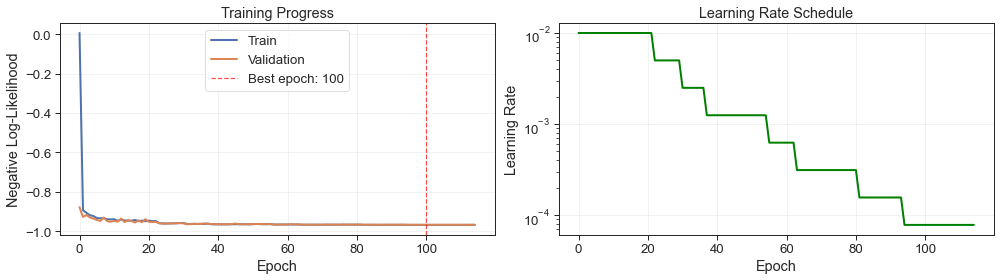

Training curve saved to: single_model_training.png


In [12]:
# Plot loss curves
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Training and validation loss
axes[0].plot(history['train_loss'], label='Train', linewidth=2)
axes[0].plot(history['val_loss'], label='Validation', linewidth=2)
axes[0].axvline(history['best_epoch'], color='red', linestyle='--', 
                label=f'Best epoch: {history["best_epoch"]}', alpha=0.7)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Negative Log-Likelihood')
axes[0].set_title('Training Progress')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Learning rate
axes[1].plot(history['learning_rate'], linewidth=2, color='green')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Learning Rate')
axes[1].set_title('Learning Rate Schedule')
axes[1].set_yscale('log')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('single_model_training.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Training curve saved to: single_model_training.png")

## Example 3: Sample from Trained Model

Generating 100,000 samples...
Generated samples shape: (100000, 2)
Sample range: m' ∈ [0.010, 0.987]
             θ' ∈ [0.007, 0.993]


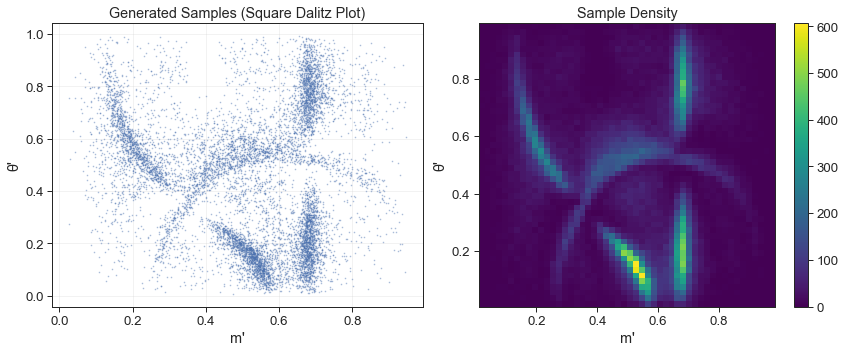

Sample plot saved to: generated_samples.png


In [13]:
# Load best model
flow.eval()
flow.to(device)

# Generate samples
print("Generating 100,000 samples...")
with torch.no_grad():
    samples = flow.sample(100_000).cpu().numpy()

print(f"Generated samples shape: {samples.shape}")
print(f"Sample range: m' ∈ [{samples[:,0].min():.3f}, {samples[:,0].max():.3f}]")
print(f"             θ' ∈ [{samples[:,1].min():.3f}, {samples[:,1].max():.3f}]")

# Plot samples
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 2D scatter
axes[0].scatter(samples[:10000, 0], samples[:10000, 1], 
                alpha=0.3, s=1, rasterized=True)
axes[0].set_xlabel("m'")
axes[0].set_ylabel("θ'")
axes[0].set_title('Generated Samples (Square Dalitz Plot)')
axes[0].grid(True, alpha=0.3)

# 2D histogram
h = axes[1].hist2d(samples[:, 0], samples[:, 1], bins=50, cmap='viridis')
axes[1].set_xlabel("m'")
axes[1].set_ylabel("θ'")
axes[1].set_title('Sample Density')
plt.colorbar(h[3], ax=axes[1])

plt.tight_layout()
plt.savefig('generated_samples.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Sample plot saved to: generated_samples.png")

## Example 4: Train Small Ensemble (for testing)

In [ ]:
# Train a small ensemble (5 models) to test the pipeline
# Uses fixed validation set and samples from training pool
results = train_ensemble(
    data_path="D_Kspipi_odd_SDP_1.1e7.npy",  
    output_dir="test_ensemble_odd",
    num_trials=5,                       # Just 5 models for testing
    train_pool_size=10_000_000,         # First 10M events
    val_size=1_000_000,                 # Last 1M events (FIXED)
    train_sample_size=1_000_000,        # Sample 1M per trial from pool
    batch_size=10000,
    lr=0.01,
    max_epochs=100,                     # Fewer epochs for testing
    patience=10,
    min_delta=1e-5,
    num_flows=16,
    hidden_features=128,
    num_bins=16,
    device=device
)

print("\nSmall ensemble complete!")
print("Check the 'test_ensemble_odd/' directory for results")

Loading data from D_Kspipi_even_SDP_1.1e7.npy...
Loaded 11,000,000 events

Data split:
  Training pool: 10,000,000 events
  Each trial samples: 1,000,000 events from pool
  Validation set: 1,000,000 events (FIXED for all trials)

TRIAL 1/5
Using seed: 1 (trial=1, offset=0)
Training on: 1,000,000 events (sampled from pool)
Validating on: 1,000,000 events (fixed set)
Model parameters: 365,296


Training:   0%|                                         | 0/100 [00:00<?, ?it/s]/Users/san/opt/anaconda3/lib/python3.9/site-packages/nflows/transforms/coupling.py:561: UserWarning: Inputs to the softmax are not scaled down: initialization might be bad.
  warnings.warn(
Training:   1%|▎                              | 1/100 [01:34<2:35:10, 94.05s/it]

[001] Train: -0.152765, Val: -0.898022, LR: 1.00e-02


Training:   2%|▌                              | 2/100 [03:11<2:37:03, 96.15s/it]

[002] Train: -0.896032, Val: -0.897165, LR: 1.00e-02
  → No improvement for 1/10 epochs


Training:   3%|▉                              | 3/100 [04:44<2:33:07, 94.72s/it]

[003] Train: -0.917617, Val: -0.925141, LR: 1.00e-02
  → Validation improved to -0.925141


Training:   4%|█▏                             | 4/100 [06:18<2:31:06, 94.45s/it]

[004] Train: -0.929660, Val: -0.939561, LR: 1.00e-02
  → Validation improved to -0.939561


Training:   5%|█▌                             | 5/100 [07:49<2:27:42, 93.29s/it]

[005] Train: -0.932141, Val: -0.943061, LR: 1.00e-02
  → Validation improved to -0.943061


Training:   6%|█▊                             | 6/100 [09:18<2:23:27, 91.57s/it]

[006] Train: -0.935102, Val: -0.945638, LR: 1.00e-02
  → Validation improved to -0.945638


Training:   7%|██▏                            | 7/100 [10:47<2:20:38, 90.73s/it]

[007] Train: -0.938715, Val: -0.950699, LR: 1.00e-02
  → Validation improved to -0.950699


Training:   8%|██▍                            | 8/100 [12:10<2:15:35, 88.43s/it]

[008] Train: -0.940984, Val: -0.949840, LR: 1.00e-02
  → No improvement for 1/10 epochs


Training:   9%|██▊                            | 9/100 [13:37<2:13:14, 87.85s/it]

[009] Train: -0.944775, Val: -0.945267, LR: 1.00e-02
  → No improvement for 2/10 epochs


Training:  10%|███                           | 10/100 [15:07<2:12:45, 88.51s/it]

[010] Train: -0.944427, Val: -0.948230, LR: 1.00e-02
  → No improvement for 3/10 epochs


Training:  11%|███▎                          | 11/100 [16:37<2:12:14, 89.15s/it]

[011] Train: -0.947164, Val: -0.945227, LR: 1.00e-02
  → No improvement for 4/10 epochs


Training:  12%|███▌                          | 12/100 [18:02<2:08:51, 87.85s/it]

[012] Train: -0.944599, Val: -0.937895, LR: 1.00e-02
  → No improvement for 5/10 epochs


Training:  13%|███▉                          | 13/100 [19:24<2:04:40, 85.99s/it]

[013] Train: -0.948791, Val: -0.955817, LR: 1.00e-02
  → Validation improved to -0.955817


Training:  14%|████▏                         | 14/100 [20:47<2:02:05, 85.18s/it]

[014] Train: -0.946822, Val: -0.946291, LR: 1.00e-02
  → No improvement for 1/10 epochs


Training:  15%|████▌                         | 15/100 [22:11<2:00:06, 84.78s/it]

[015] Train: -0.946110, Val: -0.948056, LR: 1.00e-02
  → No improvement for 2/10 epochs


Training:  16%|████▊                         | 16/100 [23:36<1:58:38, 84.74s/it]

[016] Train: -0.948247, Val: -0.950536, LR: 1.00e-02
  → No improvement for 3/10 epochs


Training:  17%|█████                         | 17/100 [25:00<1:56:56, 84.53s/it]

[017] Train: -0.944837, Val: -0.955230, LR: 1.00e-02
  → No improvement for 4/10 epochs


Training:  18%|█████▍                        | 18/100 [26:17<1:52:33, 82.35s/it]

[018] Train: -0.947550, Val: -0.950103, LR: 1.00e-02
  → No improvement for 5/10 epochs


Training:  19%|█████▋                        | 19/100 [27:41<1:51:54, 82.90s/it]

[019] Train: -0.948877, Val: -0.957859, LR: 1.00e-02
  → Validation improved to -0.957859


Training:  20%|██████                        | 20/100 [29:07<1:51:35, 83.69s/it]

[020] Train: -0.949786, Val: -0.948529, LR: 1.00e-02
  → No improvement for 1/10 epochs


Training:  21%|██████▎                       | 21/100 [30:30<1:50:07, 83.64s/it]

[021] Train: -0.951947, Val: -0.943158, LR: 1.00e-02
  → No improvement for 2/10 epochs


Training:  22%|██████▌                       | 22/100 [31:55<1:49:12, 84.01s/it]

[022] Train: -0.948921, Val: -0.953563, LR: 1.00e-02
  → No improvement for 3/10 epochs


Training:  23%|██████▉                       | 23/100 [33:21<1:48:28, 84.53s/it]

[023] Train: -0.951505, Val: -0.951971, LR: 1.00e-02
  → No improvement for 4/10 epochs


Training:  24%|███████▏                      | 24/100 [34:45<1:46:52, 84.38s/it]

[024] Train: -0.951334, Val: -0.954292, LR: 1.00e-02
  → No improvement for 5/10 epochs


Training:  25%|███████▌                      | 25/100 [36:08<1:45:09, 84.12s/it]

[025] Train: -0.949275, Val: -0.953352, LR: 5.00e-03
  → No improvement for 6/10 epochs


Training:  26%|███████▊                      | 26/100 [37:33<1:44:00, 84.34s/it]

[026] Train: -0.959174, Val: -0.961069, LR: 5.00e-03
  → Validation improved to -0.961069


Training:  27%|████████                      | 27/100 [38:58<1:42:35, 84.32s/it]

[027] Train: -0.960766, Val: -0.960740, LR: 5.00e-03
  → No improvement for 1/10 epochs


Training:  28%|████████▍                     | 28/100 [40:24<1:41:46, 84.82s/it]

[028] Train: -0.959603, Val: -0.961390, LR: 5.00e-03
  → Validation improved to -0.961390


Training:  29%|████████▋                     | 29/100 [41:48<1:40:23, 84.84s/it]

[029] Train: -0.959327, Val: -0.960423, LR: 5.00e-03
  → No improvement for 1/10 epochs


Training:  30%|█████████                     | 30/100 [43:19<1:40:53, 86.48s/it]

[030] Train: -0.958595, Val: -0.962104, LR: 5.00e-03
  → Validation improved to -0.962104


Training:  31%|█████████▎                    | 31/100 [44:43<1:38:31, 85.67s/it]

[031] Train: -0.959257, Val: -0.958109, LR: 5.00e-03
  → No improvement for 1/10 epochs


Training:  32%|█████████▌                    | 32/100 [46:07<1:36:38, 85.27s/it]

[032] Train: -0.959354, Val: -0.956428, LR: 5.00e-03
  → No improvement for 2/10 epochs


Training:  33%|█████████▉                    | 33/100 [47:32<1:35:03, 85.13s/it]

[033] Train: -0.959681, Val: -0.961681, LR: 5.00e-03
  → No improvement for 3/10 epochs


Training:  34%|██████████▏                   | 34/100 [48:55<1:33:04, 84.62s/it]

[034] Train: -0.959107, Val: -0.959284, LR: 5.00e-03
  → No improvement for 4/10 epochs


Training:  35%|██████████▌                   | 35/100 [50:19<1:31:28, 84.44s/it]

[035] Train: -0.959480, Val: -0.962920, LR: 5.00e-03
  → Validation improved to -0.962920


Training:  36%|██████████▊                   | 36/100 [51:43<1:29:53, 84.27s/it]

[036] Train: -0.959121, Val: -0.960185, LR: 5.00e-03
  → No improvement for 1/10 epochs


Training:  37%|███████████                   | 37/100 [53:07<1:28:25, 84.21s/it]

[037] Train: -0.957631, Val: -0.961749, LR: 5.00e-03
  → No improvement for 2/10 epochs


Training:  38%|███████████▍                  | 38/100 [54:31<1:26:50, 84.04s/it]

[038] Train: -0.958960, Val: -0.960566, LR: 5.00e-03
  → No improvement for 3/10 epochs


Training:  39%|███████████▋                  | 39/100 [55:51<1:24:11, 82.82s/it]

[039] Train: -0.957940, Val: -0.958868, LR: 5.00e-03
  → No improvement for 4/10 epochs


Training:  40%|████████████                  | 40/100 [57:15<1:23:13, 83.22s/it]

[040] Train: -0.958656, Val: -0.957922, LR: 5.00e-03
  → No improvement for 5/10 epochs


Training:  41%|████████████▎                 | 41/100 [58:38<1:21:56, 83.33s/it]

[041] Train: -0.958261, Val: -0.960040, LR: 2.50e-03
  → No improvement for 6/10 epochs


Training:  42%|███████████▊                | 42/100 [1:00:02<1:20:44, 83.52s/it]

[042] Train: -0.962655, Val: -0.963320, LR: 2.50e-03
  → Validation improved to -0.963320


Training:  43%|████████████                | 43/100 [1:01:28<1:19:57, 84.16s/it]

[043] Train: -0.963052, Val: -0.963835, LR: 2.50e-03
  → Validation improved to -0.963835


Training:  44%|████████████▎               | 44/100 [1:02:53<1:18:54, 84.54s/it]

[044] Train: -0.963136, Val: -0.963061, LR: 2.50e-03
  → No improvement for 1/10 epochs


Training:  45%|████████████▌               | 45/100 [1:04:16<1:17:02, 84.05s/it]

[045] Train: -0.962827, Val: -0.964569, LR: 2.50e-03
  → Validation improved to -0.964569


Training:  46%|████████████▉               | 46/100 [1:05:39<1:15:20, 83.71s/it]

[046] Train: -0.963046, Val: -0.962975, LR: 2.50e-03
  → No improvement for 1/10 epochs


Training:  47%|█████████████▏              | 47/100 [1:07:02<1:13:47, 83.54s/it]

[047] Train: -0.962523, Val: -0.962421, LR: 2.50e-03
  → No improvement for 2/10 epochs


Training:  48%|█████████████▍              | 48/100 [1:08:25<1:12:10, 83.27s/it]

[048] Train: -0.962406, Val: -0.962777, LR: 2.50e-03
  → No improvement for 3/10 epochs


Training:  49%|█████████████▋              | 49/100 [1:09:48<1:10:41, 83.17s/it]

[049] Train: -0.961945, Val: -0.963912, LR: 2.50e-03
  → No improvement for 4/10 epochs


Training:  50%|██████████████              | 50/100 [1:11:12<1:09:35, 83.51s/it]

[050] Train: -0.962904, Val: -0.965030, LR: 2.50e-03
  → Validation improved to -0.965030


Training:  51%|██████████████▎             | 51/100 [1:12:36<1:08:17, 83.62s/it]

[051] Train: -0.962991, Val: -0.961955, LR: 2.50e-03
  → No improvement for 1/10 epochs


Training:  52%|██████████████▌             | 52/100 [1:14:00<1:07:00, 83.76s/it]

[052] Train: -0.961949, Val: -0.962995, LR: 2.50e-03
  → No improvement for 2/10 epochs


Training:  53%|██████████████▊             | 53/100 [1:15:24<1:05:33, 83.70s/it]

[053] Train: -0.962258, Val: -0.963249, LR: 2.50e-03
  → No improvement for 3/10 epochs


Training:  54%|███████████████             | 54/100 [1:17:11<1:09:31, 90.68s/it]

[054] Train: -0.961811, Val: -0.963496, LR: 2.50e-03
  → No improvement for 4/10 epochs


Training:  55%|██████████████▊            | 55/100 [1:24:24<2:25:08, 193.53s/it]

[055] Train: -0.962164, Val: -0.957449, LR: 2.50e-03
  → No improvement for 5/10 epochs


Training:  56%|███████████████            | 56/100 [1:26:06<2:01:41, 165.95s/it]

[056] Train: -0.961719, Val: -0.963547, LR: 1.25e-03
  → No improvement for 6/10 epochs


Training:  57%|███████████████▍           | 57/100 [1:27:42<1:43:59, 145.11s/it]

[057] Train: -0.964573, Val: -0.965639, LR: 1.25e-03
  → Validation improved to -0.965639


Training:  58%|███████████████▋           | 58/100 [1:29:18<1:31:11, 130.28s/it]

[058] Train: -0.965086, Val: -0.965129, LR: 1.25e-03
  → No improvement for 1/10 epochs


Training:  59%|███████████████▉           | 59/100 [1:30:51<1:21:21, 119.05s/it]

[059] Train: -0.964261, Val: -0.964519, LR: 1.25e-03
  → No improvement for 2/10 epochs


Training:  60%|████████████████▏          | 60/100 [1:32:26<1:14:34, 111.87s/it]

[060] Train: -0.964888, Val: -0.965219, LR: 1.25e-03
  → No improvement for 3/10 epochs


Training:  61%|████████████████▍          | 61/100 [1:34:02<1:09:41, 107.21s/it]

[061] Train: -0.964629, Val: -0.964377, LR: 1.25e-03
  → No improvement for 4/10 epochs


Training:  62%|████████████████▋          | 62/100 [1:35:38<1:05:43, 103.78s/it]

[062] Train: -0.964625, Val: -0.965761, LR: 1.25e-03
  → Validation improved to -0.965761


Training:  63%|█████████████████          | 63/100 [1:37:16<1:02:55, 102.04s/it]

[063] Train: -0.964696, Val: -0.965216, LR: 1.25e-03
  → No improvement for 1/10 epochs


Training:  64%|█████████████████▎         | 64/100 [1:38:55<1:00:35, 101.00s/it]

[064] Train: -0.964926, Val: -0.965782, LR: 1.25e-03
  → Validation improved to -0.965782


Training:  65%|███████████████████▌          | 65/100 [1:40:29<57:41, 98.90s/it]

[065] Train: -0.964789, Val: -0.965208, LR: 1.25e-03
  → No improvement for 1/10 epochs


Training:  66%|███████████████████▊          | 66/100 [1:42:07<56:00, 98.83s/it]

[066] Train: -0.964420, Val: -0.964491, LR: 1.25e-03
  → No improvement for 2/10 epochs


Training:  67%|████████████████████          | 67/100 [1:43:39<53:10, 96.67s/it]

[067] Train: -0.964410, Val: -0.964482, LR: 1.25e-03
  → No improvement for 3/10 epochs


Training:  68%|████████████████████▍         | 68/100 [1:45:14<51:21, 96.30s/it]

[068] Train: -0.964492, Val: -0.964617, LR: 1.25e-03
  → No improvement for 4/10 epochs


Training:  69%|████████████████████▋         | 69/100 [1:46:50<49:40, 96.15s/it]

[069] Train: -0.964281, Val: -0.963632, LR: 1.25e-03
  → No improvement for 5/10 epochs


Training:  70%|█████████████████████         | 70/100 [1:48:27<48:07, 96.26s/it]

[070] Train: -0.964570, Val: -0.964733, LR: 6.25e-04
  → No improvement for 6/10 epochs


Training:  71%|█████████████████████▎        | 71/100 [1:50:07<47:06, 97.48s/it]

[071] Train: -0.965848, Val: -0.965827, LR: 6.25e-04
  → Validation improved to -0.965827


Training:  72%|█████████████████████▌        | 72/100 [1:51:42<45:09, 96.76s/it]

[072] Train: -0.966143, Val: -0.966673, LR: 6.25e-04
  → Validation improved to -0.966673


Training:  73%|█████████████████████▉        | 73/100 [1:53:15<43:02, 95.64s/it]

[073] Train: -0.966157, Val: -0.966549, LR: 6.25e-04
  → No improvement for 1/10 epochs


Training:  74%|██████████████████████▏       | 74/100 [1:54:51<41:26, 95.64s/it]

[074] Train: -0.966091, Val: -0.964357, LR: 6.25e-04
  → No improvement for 2/10 epochs


Training:  75%|██████████████████████▌       | 75/100 [1:56:31<40:27, 97.09s/it]

[075] Train: -0.965961, Val: -0.966373, LR: 6.25e-04
  → No improvement for 3/10 epochs


Training:  76%|██████████████████████▊       | 76/100 [1:58:03<38:12, 95.54s/it]

[076] Train: -0.966047, Val: -0.966003, LR: 6.25e-04
  → No improvement for 4/10 epochs


Training:  77%|███████████████████████       | 77/100 [1:59:38<36:31, 95.26s/it]

[077] Train: -0.966121, Val: -0.966038, LR: 6.25e-04
  → No improvement for 5/10 epochs


Training:  78%|███████████████████████▍      | 78/100 [2:01:20<35:39, 97.25s/it]

[078] Train: -0.966145, Val: -0.966610, LR: 6.25e-04
  → No improvement for 6/10 epochs


Training:  79%|███████████████████████▋      | 79/100 [2:02:53<33:38, 96.14s/it]

[079] Train: -0.966167, Val: -0.966162, LR: 6.25e-04
  → No improvement for 7/10 epochs


Training:  80%|████████████████████████      | 80/100 [2:04:30<32:03, 96.19s/it]

[080] Train: -0.966081, Val: -0.966585, LR: 6.25e-04
  → No improvement for 8/10 epochs


Training:  81%|████████████████████████▎     | 81/100 [2:06:06<30:31, 96.40s/it]

[081] Train: -0.965806, Val: -0.965993, LR: 6.25e-04
  → No improvement for 9/10 epochs


Training:  81%|████████████████████████▎     | 81/100 [2:07:38<29:56, 94.55s/it]

[082] Train: -0.965734, Val: -0.966242, LR: 6.25e-04
  → No improvement for 10/10 epochs
Early stopping triggered! Best was epoch 72

Loaded best model from epoch 72

Trial 1 complete:
  Best val loss: -0.966673
  Epochs trained: 82
  Early stopped: True

TRIAL 2/5
Using seed: 2 (trial=2, offset=0)


Training on: 1,000,000 events (sampled from pool)
Validating on: 1,000,000 events (fixed set)


Training:   1%|▎                              | 1/100 [01:30<2:29:52, 90.84s/it]

[001] Train: -0.320113, Val: -0.877287, LR: 1.00e-02


Training:   2%|▌                              | 2/100 [03:02<2:29:12, 91.35s/it]

[002] Train: -0.896059, Val: -0.904159, LR: 1.00e-02
  → Validation improved to -0.904159


Training:   3%|▉                              | 3/100 [04:35<2:28:45, 92.01s/it]

[003] Train: -0.913625, Val: -0.921503, LR: 1.00e-02
  → Validation improved to -0.921503


Training:   4%|█▏                             | 4/100 [06:10<2:29:04, 93.17s/it]

[004] Train: -0.933670, Val: -0.938294, LR: 1.00e-02
  → Validation improved to -0.938294


Training:   5%|█▍                           | 5/100 [29:15<14:45:01, 558.96s/it]

[005] Train: -0.938852, Val: -0.936479, LR: 1.00e-02
  → No improvement for 1/10 epochs


Training:   6%|█▋                           | 6/100 [35:52<13:09:36, 504.01s/it]

[006] Train: -0.943237, Val: -0.944567, LR: 1.00e-02
  → Validation improved to -0.944567


Training:   7%|█▊                        | 7/100 [1:16:11<29:11:47, 1130.18s/it]

[007] Train: -0.945074, Val: -0.946042, LR: 1.00e-02
  → Validation improved to -0.946042


Training:   8%|██                        | 8/100 [1:57:11<39:42:01, 1553.49s/it]

[008] Train: -0.948724, Val: -0.948503, LR: 1.00e-02
  → Validation improved to -0.948503


Training:   9%|██▎                       | 9/100 [2:12:14<34:07:25, 1349.95s/it]

[009] Train: -0.947903, Val: -0.944106, LR: 1.00e-02
  → No improvement for 1/10 epochs


Training:  10%|██▌                       | 10/100 [2:13:31<23:55:24, 956.94s/it]

[010] Train: -0.949084, Val: -0.950333, LR: 1.00e-02
  → Validation improved to -0.950333


Training:  11%|██▊                       | 11/100 [2:14:49<17:00:34, 688.03s/it]

[011] Train: -0.949258, Val: -0.953242, LR: 1.00e-02
  → Validation improved to -0.953242


Training:  12%|███                       | 12/100 [2:16:18<12:21:58, 505.90s/it]

[012] Train: -0.948102, Val: -0.950794, LR: 1.00e-02
  → No improvement for 1/10 epochs


Training:  13%|███▌                       | 13/100 [2:17:57<9:14:32, 382.44s/it]

[013] Train: -0.951832, Val: -0.954686, LR: 1.00e-02
  → Validation improved to -0.954686


Training:  14%|███▊                       | 14/100 [2:19:36<7:05:42, 297.00s/it]

[014] Train: -0.953094, Val: -0.947044, LR: 1.00e-02
  → No improvement for 1/10 epochs


Training:  15%|████                       | 15/100 [2:20:55<5:27:32, 231.21s/it]

[015] Train: -0.951699, Val: -0.946391, LR: 1.00e-02
  → No improvement for 2/10 epochs


Training:  16%|████▎                      | 16/100 [2:22:26<4:24:30, 188.93s/it]

[016] Train: -0.951929, Val: -0.952701, LR: 1.00e-02
  → No improvement for 3/10 epochs


Training:  17%|████▌                      | 17/100 [2:23:57<3:40:53, 159.69s/it]

[017] Train: -0.951373, Val: -0.941233, LR: 1.00e-02
  → No improvement for 4/10 epochs


Training:  18%|████▊                      | 18/100 [2:25:46<3:17:20, 144.40s/it]

[018] Train: -0.952654, Val: -0.942428, LR: 1.00e-02
  → No improvement for 5/10 epochs


Training:  19%|█████▏                     | 19/100 [2:28:01<3:10:56, 141.44s/it]

[019] Train: -0.950821, Val: -0.954683, LR: 1.00e-02
  → No improvement for 6/10 epochs


Training:  20%|█████▍                     | 20/100 [2:29:39<2:51:18, 128.48s/it]

[020] Train: -0.953372, Val: -0.952722, LR: 1.00e-02
  → No improvement for 7/10 epochs


Training:  21%|█████▋                     | 21/100 [2:31:13<2:35:42, 118.26s/it]

[021] Train: -0.953346, Val: -0.952798, LR: 1.00e-02
  → No improvement for 8/10 epochs


Training:  22%|█████▉                     | 22/100 [2:32:52<2:26:01, 112.33s/it]

[022] Train: -0.951895, Val: -0.949927, LR: 1.00e-02
  → No improvement for 9/10 epochs


Training:  23%|██████▏                    | 23/100 [2:34:26<2:17:18, 107.00s/it]

[023] Train: -0.954957, Val: -0.954856, LR: 1.00e-02
  → Validation improved to -0.954856


Training:  24%|██████▍                    | 24/100 [2:35:54<2:08:02, 101.08s/it]

[024] Train: -0.955024, Val: -0.954375, LR: 1.00e-02
  → No improvement for 1/10 epochs


Training:  25%|██████▊                    | 25/100 [2:38:29<2:26:38, 117.31s/it]

[025] Train: -0.954421, Val: -0.955389, LR: 1.00e-02
  → Validation improved to -0.955389


Training:  26%|███████                    | 26/100 [2:42:53<3:18:52, 161.25s/it]

[026] Train: -0.951566, Val: -0.952309, LR: 1.00e-02
  → No improvement for 1/10 epochs


Training:  27%|███████▎                   | 27/100 [2:45:49<3:21:44, 165.82s/it]

[027] Train: -0.954762, Val: -0.954110, LR: 1.00e-02
  → No improvement for 2/10 epochs


Training:  28%|███████▌                   | 28/100 [2:51:04<4:12:34, 210.48s/it]

[028] Train: -0.954803, Val: -0.954494, LR: 1.00e-02
  → No improvement for 3/10 epochs


Training:  29%|███████▊                   | 29/100 [2:53:12<3:39:47, 185.74s/it]

[029] Train: -0.956200, Val: -0.954877, LR: 1.00e-02
  → No improvement for 4/10 epochs


Training:  30%|████████                   | 30/100 [2:54:42<3:03:18, 157.12s/it]

[030] Train: -0.954815, Val: -0.948371, LR: 1.00e-02
  → No improvement for 5/10 epochs


Training:  31%|████████▎                  | 31/100 [2:56:19<2:39:53, 139.04s/it]

[031] Train: -0.953660, Val: -0.956719, LR: 1.00e-02
  → Validation improved to -0.956719


Training:  32%|████████▋                  | 32/100 [2:57:45<2:19:39, 123.23s/it]

[032] Train: -0.954852, Val: -0.948254, LR: 1.00e-02
  → No improvement for 1/10 epochs


Training:  33%|████████▉                  | 33/100 [2:59:12<2:05:29, 112.38s/it]

[033] Train: -0.956299, Val: -0.954677, LR: 1.00e-02
  → No improvement for 2/10 epochs


Training:  34%|█████████▏                 | 34/100 [3:00:43<1:56:26, 105.86s/it]

[034] Train: -0.956606, Val: -0.945112, LR: 1.00e-02
  → No improvement for 3/10 epochs


Training:  35%|█████████▍                 | 35/100 [3:02:09<1:48:21, 100.02s/it]

[035] Train: -0.955897, Val: -0.958254, LR: 1.00e-02
  → Validation improved to -0.958254


Training:  36%|██████████                  | 36/100 [3:03:32<1:41:06, 94.78s/it]

[036] Train: -0.956777, Val: -0.951444, LR: 1.00e-02
  → No improvement for 1/10 epochs


Training:  37%|██████████▎                 | 37/100 [3:04:56<1:36:08, 91.56s/it]

[037] Train: -0.956011, Val: -0.952086, LR: 1.00e-02
  → No improvement for 2/10 epochs


Training:  38%|██████████▋                 | 38/100 [3:06:39<1:38:15, 95.09s/it]

[038] Train: -0.956853, Val: -0.953853, LR: 1.00e-02
  → No improvement for 3/10 epochs


In [ ]:
# Train a second small ensemble (5 models) for testing/comparison
# This creates "test_ensemble2_odd" directory
# Using seed_offset=5 gives seeds 6-10 to avoid overlap with test_ensemble (which uses seeds 1-5)
results = train_ensemble(
    data_path="D_Kspipi_odd_SDP_1e7.npy",  
    output_dir="test_ensemble2_odd",          # New directory
    num_trials=5,                         # 5 models for quick testing
    train_pool_size=10_000_000,           # First 10M events
    val_size=1_000_000,                   # Last 1M events (FIXED)
    train_sample_size=1_000_000,          # Sample 1M per trial from pool
    batch_size=10000,
    lr=0.01,
    max_epochs=100,                       # Fewer epochs for testing
    patience=10,
    min_delta=1e-5,
    num_flows=16,
    hidden_features=128,
    num_bins=16,
    seed_offset=5,                        # Seeds 6-10 (test_ensemble uses 1-5)
    device=device
)

print("\ntest_ensemble2 training complete!")
print("Check the 'test_ensemble2/' directory for results")

In [ ]:
# Train a third small ensemble (5 models) for testing/comparison
# Using seed_offset=10 gives seeds 11-15 to avoid overlap with test_ensemble (which uses seeds 1-5)
results = train_ensemble(
    data_path="D_Kspipi_odd_SDP_1e7.npy",  
    output_dir="test_ensemble2_odd",          # New directory
    num_trials=5,                         # 5 models for quick testing
    train_pool_size=10_000_000,           # First 10M events
    val_size=1_000_000,                   # Last 1M events (FIXED)
    train_sample_size=1_000_000,          # Sample 1M per trial from pool
    batch_size=10000,
    lr=0.01,
    max_epochs=100,                       # Fewer epochs for testing
    patience=10,
    min_delta=1e-5,
    num_flows=16,
    hidden_features=128,
    num_bins=16,
    seed_offset=10,                        # Seeds 11-15 
    device=device
)

print("\ntest_ensemble2 training complete!")
print("Check the 'test_ensemble2/' directory for results")

In [ ]:
# Train a fourth small ensemble (5 models) for testing/comparison
# Using seed_offset=15 gives seeds 16-20 to avoid overlap with test_ensemble (which uses seeds 1-5)
results = train_ensemble(
    data_path="D_Kspipi_odd_SDP_1e7.npy",  
    output_dir="test_ensemble2_odd",          # New directory
    num_trials=5,                         # 5 models for quick testing
    train_pool_size=10_000_000,           # First 10M events
    val_size=1_000_000,                   # Last 1M events (FIXED)
    train_sample_size=1_000_000,          # Sample 1M per trial from pool
    batch_size=10000,
    lr=0.01,
    max_epochs=100,                       # Fewer epochs for testing
    patience=10,
    min_delta=1e-5,
    num_flows=16,
    hidden_features=128,
    num_bins=16,
    seed_offset=15,                        # Seeds 16-20 
    device=device
)

print("\ntest_ensemble2 training complete!")
print("Check the 'test_ensemble2/' directory for results")

In [77]:
# Train a fourth small ensemble (5 models) for testing/comparison
# Using seed_offset= 20 gives seeds 21-25 to avoid overlap with test_ensemble (which uses seeds 1-5)
results = train_ensemble(
    data_path="D_Kspipi_odd_SDP_1e7.npy",  
    output_dir="test_ensemble2_odd",          # New directory
    num_trials=5,                         # 5 models for quick testing
    train_pool_size=10_000_000,           # First 10M events
    val_size=1_000_000,                   # Last 1M events (FIXED)
    train_sample_size=1_000_000,          # Sample 1M per trial from pool
    batch_size=10000,
    lr=0.01,
    max_epochs=100,                       # Fewer epochs for testing
    patience=10,
    min_delta=1e-5,
    num_flows=16,
    hidden_features=128,
    num_bins=16,
    seed_offset=20,                        # Seeds 21-25 
    device=device
)

print("\ntest_ensemble2 training complete!")
print("Check the 'test_ensemble2/' directory for results")

Loading data from D_Kspipi_SDP_1.1e7.npy...
Loaded 11,000,000 events

Data split:
  Training pool: 10,000,000 events
  Each trial samples: 1,000,000 events from pool
  Validation set: 1,000,000 events (FIXED for all trials)

TRIAL 1/5
Using seed: 21 (trial=1, offset=20)
Training on: 1,000,000 events (sampled from pool)
Validating on: 1,000,000 events (fixed set)
Model parameters: 365,296


Training:   0%|                                         | 0/100 [00:00<?, ?it/s]/Users/san/opt/anaconda3/lib/python3.9/site-packages/nflows/transforms/coupling.py:561: UserWarning: Inputs to the softmax are not scaled down: initialization might be bad.
  warnings.warn(
Training:   1%|▎                              | 1/100 [01:38<2:42:41, 98.60s/it]

[001] Train: -0.238031, Val: -1.082171, LR: 1.00e-02


Training:   2%|▌                              | 2/100 [03:14<2:38:18, 96.93s/it]

[002] Train: -1.089941, Val: -1.101084, LR: 1.00e-02
  → Validation improved to -1.101084


Training:   3%|▉                              | 3/100 [04:51<2:36:41, 96.92s/it]

[003] Train: -1.091720, Val: -1.102634, LR: 1.00e-02
  → Validation improved to -1.102634


Training:   4%|█▏                             | 4/100 [06:26<2:33:46, 96.11s/it]

[004] Train: -1.096948, Val: -1.106617, LR: 1.00e-02
  → Validation improved to -1.106617


Training:   5%|█▌                             | 5/100 [08:05<2:33:48, 97.14s/it]

[005] Train: -1.097789, Val: -1.100407, LR: 1.00e-02
  → No improvement for 1/10 epochs


Training:   6%|█▊                             | 6/100 [09:39<2:30:56, 96.35s/it]

[006] Train: -1.100702, Val: -1.103458, LR: 1.00e-02
  → No improvement for 2/10 epochs


Training:   7%|██▏                            | 7/100 [11:27<2:34:57, 99.97s/it]

[007] Train: -1.102008, Val: -1.107901, LR: 1.00e-02
  → Validation improved to -1.107901


Training:   8%|██▍                           | 8/100 [13:07<2:33:37, 100.19s/it]

[008] Train: -1.100717, Val: -1.101708, LR: 1.00e-02
  → No improvement for 1/10 epochs


Training:   9%|██▊                            | 9/100 [14:42<2:29:18, 98.44s/it]

[009] Train: -1.103425, Val: -1.110529, LR: 1.00e-02
  → Validation improved to -1.110529


Training:  10%|███                           | 10/100 [16:22<2:28:16, 98.85s/it]

[010] Train: -1.103592, Val: -1.100426, LR: 1.00e-02
  → No improvement for 1/10 epochs


Training:  11%|███▏                         | 11/100 [18:11<2:31:08, 101.89s/it]

[011] Train: -1.104998, Val: -1.107573, LR: 1.00e-02
  → No improvement for 2/10 epochs


Training:  12%|███▌                          | 12/100 [19:45<2:26:01, 99.56s/it]

[012] Train: -1.103303, Val: -1.113083, LR: 1.00e-02
  → Validation improved to -1.113083


Training:  13%|███▉                          | 13/100 [21:11<2:18:16, 95.36s/it]

[013] Train: -1.108281, Val: -1.107891, LR: 1.00e-02
  → No improvement for 1/10 epochs


Training:  14%|████▏                         | 14/100 [22:37<2:12:47, 92.64s/it]

[014] Train: -1.106990, Val: -1.111652, LR: 1.00e-02
  → No improvement for 2/10 epochs


Training:  15%|████▌                         | 15/100 [24:00<2:06:57, 89.61s/it]

[015] Train: -1.105302, Val: -1.103998, LR: 1.00e-02
  → No improvement for 3/10 epochs


Training:  16%|████▊                         | 16/100 [25:21<2:02:07, 87.23s/it]

[016] Train: -1.106487, Val: -1.108487, LR: 1.00e-02
  → No improvement for 4/10 epochs


Training:  17%|█████                         | 17/100 [26:43<1:58:13, 85.47s/it]

[017] Train: -1.105760, Val: -1.109961, LR: 1.00e-02
  → No improvement for 5/10 epochs


Training:  18%|█████▍                        | 18/100 [28:00<1:53:24, 82.98s/it]

[018] Train: -1.106884, Val: -1.111293, LR: 5.00e-03
  → No improvement for 6/10 epochs


Training:  19%|█████▋                        | 19/100 [29:17<1:49:47, 81.33s/it]

[019] Train: -1.114871, Val: -1.116852, LR: 5.00e-03
  → Validation improved to -1.116852


Training:  20%|██████                        | 20/100 [30:35<1:46:52, 80.16s/it]

[020] Train: -1.115298, Val: -1.119164, LR: 5.00e-03
  → Validation improved to -1.119164


Training:  21%|██████▎                       | 21/100 [31:56<1:45:51, 80.40s/it]

[021] Train: -1.114116, Val: -1.115261, LR: 5.00e-03
  → No improvement for 1/10 epochs


Training:  22%|██████▌                       | 22/100 [33:15<1:43:57, 79.97s/it]

[022] Train: -1.114971, Val: -1.114945, LR: 5.00e-03
  → No improvement for 2/10 epochs


Training:  23%|██████▉                       | 23/100 [34:35<1:42:39, 80.00s/it]

[023] Train: -1.114772, Val: -1.118629, LR: 5.00e-03
  → No improvement for 3/10 epochs


Training:  24%|███████▏                      | 24/100 [35:55<1:41:18, 79.98s/it]

[024] Train: -1.114618, Val: -1.117944, LR: 5.00e-03
  → No improvement for 4/10 epochs


Training:  25%|███████▌                      | 25/100 [37:17<1:40:42, 80.57s/it]

[025] Train: -1.114629, Val: -1.117627, LR: 5.00e-03
  → No improvement for 5/10 epochs


Training:  26%|███████▊                      | 26/100 [38:38<1:39:35, 80.75s/it]

[026] Train: -1.114706, Val: -1.116727, LR: 2.50e-03
  → No improvement for 6/10 epochs


Training:  27%|████████                      | 27/100 [39:58<1:38:08, 80.66s/it]

[027] Train: -1.117594, Val: -1.120151, LR: 2.50e-03
  → Validation improved to -1.120151


Training:  28%|████████▍                     | 28/100 [41:19<1:36:46, 80.64s/it]

[028] Train: -1.118003, Val: -1.119907, LR: 2.50e-03
  → No improvement for 1/10 epochs


Training:  29%|████████▋                     | 29/100 [42:40<1:35:43, 80.89s/it]

[029] Train: -1.117368, Val: -1.119822, LR: 2.50e-03
  → No improvement for 2/10 epochs


Training:  30%|█████████                     | 30/100 [44:01<1:34:11, 80.74s/it]

[030] Train: -1.117667, Val: -1.120338, LR: 2.50e-03
  → Validation improved to -1.120338


Training:  31%|█████████▎                    | 31/100 [45:20<1:32:28, 80.42s/it]

[031] Train: -1.117850, Val: -1.119523, LR: 2.50e-03
  → No improvement for 1/10 epochs


Training:  32%|█████████▌                    | 32/100 [46:41<1:31:23, 80.64s/it]

[032] Train: -1.117709, Val: -1.118135, LR: 2.50e-03
  → No improvement for 2/10 epochs


Training:  33%|█████████▉                    | 33/100 [48:02<1:29:56, 80.54s/it]

[033] Train: -1.117552, Val: -1.119389, LR: 2.50e-03
  → No improvement for 3/10 epochs


Training:  34%|██████████▏                   | 34/100 [49:22<1:28:33, 80.51s/it]

[034] Train: -1.116407, Val: -1.119532, LR: 2.50e-03
  → No improvement for 4/10 epochs


Training:  35%|██████████▌                   | 35/100 [50:46<1:28:23, 81.60s/it]

[035] Train: -1.117163, Val: -1.118488, LR: 2.50e-03
  → No improvement for 5/10 epochs


Training:  36%|██████████▊                   | 36/100 [52:10<1:27:46, 82.28s/it]

[036] Train: -1.116947, Val: -1.120490, LR: 2.50e-03
  → Validation improved to -1.120490


Training:  37%|███████████                   | 37/100 [53:30<1:25:44, 81.66s/it]

[037] Train: -1.117093, Val: -1.117912, LR: 2.50e-03
  → No improvement for 1/10 epochs


Training:  38%|███████████▍                  | 38/100 [54:52<1:24:12, 81.49s/it]

[038] Train: -1.116996, Val: -1.119034, LR: 2.50e-03
  → No improvement for 2/10 epochs


Training:  39%|███████████▋                  | 39/100 [56:12<1:22:27, 81.10s/it]

[039] Train: -1.116410, Val: -1.118490, LR: 2.50e-03
  → No improvement for 3/10 epochs


Training:  40%|████████████                  | 40/100 [57:34<1:21:22, 81.37s/it]

[040] Train: -1.116797, Val: -1.119005, LR: 2.50e-03
  → No improvement for 4/10 epochs


Training:  41%|████████████▎                 | 41/100 [58:54<1:19:47, 81.14s/it]

[041] Train: -1.116556, Val: -1.117228, LR: 2.50e-03
  → No improvement for 5/10 epochs


Training:  42%|███████████▊                | 42/100 [1:00:20<1:19:36, 82.36s/it]

[042] Train: -1.116716, Val: -1.117443, LR: 1.25e-03
  → No improvement for 6/10 epochs


Training:  43%|████████████                | 43/100 [1:02:05<1:24:54, 89.37s/it]

[043] Train: -1.119110, Val: -1.120608, LR: 1.25e-03
  → Validation improved to -1.120608


Training:  44%|███████████▉               | 44/100 [1:12:23<3:51:21, 247.89s/it]

[044] Train: -1.119356, Val: -1.120875, LR: 1.25e-03
  → Validation improved to -1.120875


Training:  45%|███████████▋              | 45/100 [1:40:41<10:25:54, 682.80s/it]

[045] Train: -1.119339, Val: -1.121204, LR: 1.25e-03
  → Validation improved to -1.121204


Training:  46%|████████████▍              | 46/100 [1:41:56<7:30:27, 500.52s/it]

[046] Train: -1.119225, Val: -1.120635, LR: 1.25e-03
  → No improvement for 1/10 epochs


Training:  47%|███████████▊             | 47/100 [2:50:13<23:15:20, 1579.64s/it]

[047] Train: -1.119294, Val: -1.122031, LR: 1.25e-03
  → Validation improved to -1.122031


Training:  48%|████████████             | 48/100 [3:52:03<32:02:51, 2218.68s/it]

[048] Train: -1.119359, Val: -1.121352, LR: 1.25e-03
  → No improvement for 1/10 epochs


Training:  49%|████████████▎            | 49/100 [3:53:36<22:23:54, 1581.07s/it]

[049] Train: -1.118722, Val: -1.120406, LR: 1.25e-03
  → No improvement for 2/10 epochs


Training:  50%|████████████▌            | 50/100 [3:59:38<16:52:36, 1215.12s/it]

[050] Train: -1.119232, Val: -1.120099, LR: 1.25e-03
  → No improvement for 3/10 epochs


Training:  51%|█████████████▎            | 51/100 [4:00:51<11:52:40, 872.66s/it]

[051] Train: -1.118878, Val: -1.119799, LR: 1.25e-03
  → No improvement for 4/10 epochs


Training:  52%|██████████████             | 52/100 [4:02:19<8:29:37, 637.04s/it]

[052] Train: -1.118780, Val: -1.121046, LR: 1.25e-03
  → No improvement for 5/10 epochs


Training:  53%|██████████████▎            | 53/100 [4:03:46<6:09:49, 472.12s/it]

[053] Train: -1.119081, Val: -1.121411, LR: 6.25e-04
  → No improvement for 6/10 epochs


Training:  54%|██████████████▌            | 54/100 [4:05:12<4:33:08, 356.27s/it]

[054] Train: -1.120615, Val: -1.122918, LR: 6.25e-04
  → Validation improved to -1.122918


Training:  55%|██████████████▊            | 55/100 [4:06:37<3:26:13, 274.96s/it]

[055] Train: -1.120565, Val: -1.122865, LR: 6.25e-04
  → No improvement for 1/10 epochs


Training:  56%|███████████████            | 56/100 [4:08:05<2:40:35, 218.99s/it]

[056] Train: -1.120638, Val: -1.123052, LR: 6.25e-04
  → Validation improved to -1.123052


Training:  57%|███████████████▍           | 57/100 [4:09:30<2:07:59, 178.60s/it]

[057] Train: -1.120650, Val: -1.123216, LR: 6.25e-04
  → Validation improved to -1.123216


Training:  58%|███████████████▋           | 58/100 [4:10:55<1:45:25, 150.60s/it]

[058] Train: -1.120551, Val: -1.122927, LR: 6.25e-04
  → No improvement for 1/10 epochs


Training:  59%|███████████████▉           | 59/100 [4:12:20<1:29:23, 130.82s/it]

[059] Train: -1.120558, Val: -1.122102, LR: 6.25e-04
  → No improvement for 2/10 epochs


Training:  60%|████████████████▏          | 60/100 [4:13:44<1:17:58, 116.97s/it]

[060] Train: -1.120478, Val: -1.122465, LR: 6.25e-04
  → No improvement for 3/10 epochs


Training:  61%|████████████████▍          | 61/100 [4:15:09<1:09:44, 107.29s/it]

[061] Train: -1.120597, Val: -1.122027, LR: 6.25e-04
  → No improvement for 4/10 epochs


Training:  62%|████████████████▋          | 62/100 [4:16:35<1:03:50, 100.80s/it]

[062] Train: -1.120265, Val: -1.122529, LR: 6.25e-04
  → No improvement for 5/10 epochs


Training:  63%|██████████████████▉           | 63/100 [4:17:59<59:02, 95.75s/it]

[063] Train: -1.120440, Val: -1.122244, LR: 3.13e-04
  → No improvement for 6/10 epochs


Training:  64%|███████████████████▏          | 64/100 [4:19:23<55:23, 92.31s/it]

[064] Train: -1.121485, Val: -1.123584, LR: 3.13e-04
  → Validation improved to -1.123584


Training:  65%|███████████████████▌          | 65/100 [4:20:48<52:33, 90.09s/it]

[065] Train: -1.121469, Val: -1.123384, LR: 3.13e-04
  → No improvement for 1/10 epochs


Training:  66%|███████████████████▊          | 66/100 [4:22:13<50:16, 88.71s/it]

[066] Train: -1.121509, Val: -1.122829, LR: 3.13e-04
  → No improvement for 2/10 epochs


Training:  67%|████████████████████          | 67/100 [4:23:37<48:00, 87.29s/it]

[067] Train: -1.121523, Val: -1.123229, LR: 3.13e-04
  → No improvement for 3/10 epochs


Training:  68%|████████████████████▍         | 68/100 [4:25:03<46:14, 86.71s/it]

[068] Train: -1.121431, Val: -1.123449, LR: 3.13e-04
  → No improvement for 4/10 epochs


Training:  69%|████████████████████▋         | 69/100 [4:26:27<44:28, 86.09s/it]

[069] Train: -1.121586, Val: -1.123343, LR: 3.13e-04
  → No improvement for 5/10 epochs


Training:  70%|█████████████████████         | 70/100 [4:27:53<42:55, 85.86s/it]

[070] Train: -1.121519, Val: -1.123176, LR: 1.56e-04
  → No improvement for 6/10 epochs


Training:  71%|█████████████████████▎        | 71/100 [4:29:13<40:43, 84.27s/it]

[071] Train: -1.122057, Val: -1.123732, LR: 1.56e-04
  → Validation improved to -1.123732


Training:  72%|█████████████████████▌        | 72/100 [4:30:37<39:17, 84.20s/it]

[072] Train: -1.122183, Val: -1.123675, LR: 1.56e-04
  → No improvement for 1/10 epochs


Training:  73%|█████████████████████▉        | 73/100 [4:32:02<37:59, 84.42s/it]

[073] Train: -1.122158, Val: -1.123956, LR: 1.56e-04
  → Validation improved to -1.123956


Training:  74%|██████████████████████▏       | 74/100 [4:33:28<36:41, 84.68s/it]

[074] Train: -1.122101, Val: -1.123589, LR: 1.56e-04
  → No improvement for 1/10 epochs


Training:  75%|██████████████████████▌       | 75/100 [4:34:52<35:18, 84.75s/it]

[075] Train: -1.122044, Val: -1.123776, LR: 1.56e-04
  → No improvement for 2/10 epochs


Training:  76%|██████████████████████▊       | 76/100 [4:36:18<33:57, 84.91s/it]

[076] Train: -1.122180, Val: -1.123848, LR: 1.56e-04
  → No improvement for 3/10 epochs


Training:  77%|███████████████████████       | 77/100 [4:37:42<32:28, 84.70s/it]

[077] Train: -1.122074, Val: -1.123782, LR: 1.56e-04
  → No improvement for 4/10 epochs


Training:  78%|███████████████████████▍      | 78/100 [4:39:07<31:04, 84.75s/it]

[078] Train: -1.122089, Val: -1.123940, LR: 1.56e-04
  → No improvement for 5/10 epochs


Training:  79%|███████████████████████▋      | 79/100 [4:40:31<29:33, 84.44s/it]

[079] Train: -1.122097, Val: -1.123941, LR: 1.56e-04
  → No improvement for 6/10 epochs


Training:  80%|████████████████████████      | 80/100 [4:41:56<28:13, 84.67s/it]

[080] Train: -1.122100, Val: -1.123954, LR: 1.56e-04
  → No improvement for 7/10 epochs


Training:  81%|████████████████████████▎     | 81/100 [4:43:19<26:42, 84.33s/it]

[081] Train: -1.122112, Val: -1.123668, LR: 1.56e-04
  → No improvement for 8/10 epochs


Training:  82%|████████████████████████▌     | 82/100 [4:44:44<25:18, 84.39s/it]

[082] Train: -1.122068, Val: -1.123629, LR: 1.56e-04
  → No improvement for 9/10 epochs


Training:  83%|████████████████████████▉     | 83/100 [4:46:08<23:56, 84.48s/it]

[083] Train: -1.122183, Val: -1.124034, LR: 1.56e-04
  → Validation improved to -1.124034


Training:  84%|█████████████████████████▏    | 84/100 [4:47:33<22:33, 84.57s/it]

[084] Train: -1.122184, Val: -1.123795, LR: 1.56e-04
  → No improvement for 1/10 epochs


Training:  85%|█████████████████████████▌    | 85/100 [4:48:57<21:04, 84.29s/it]

[085] Train: -1.122128, Val: -1.123986, LR: 1.56e-04
  → No improvement for 2/10 epochs


Training:  86%|█████████████████████████▊    | 86/100 [4:50:22<19:42, 84.48s/it]

[086] Train: -1.122146, Val: -1.123667, LR: 1.56e-04
  → No improvement for 3/10 epochs


Training:  87%|██████████████████████████    | 87/100 [4:51:52<18:38, 86.07s/it]

[087] Train: -1.122198, Val: -1.123647, LR: 1.56e-04
  → No improvement for 4/10 epochs


Training:  88%|██████████████████████████▍   | 88/100 [4:53:19<17:16, 86.35s/it]

[088] Train: -1.122057, Val: -1.123992, LR: 1.56e-04
  → No improvement for 5/10 epochs


Training:  89%|██████████████████████████▋   | 89/100 [4:54:43<15:44, 85.86s/it]

[089] Train: -1.122167, Val: -1.123936, LR: 1.56e-04
  → No improvement for 6/10 epochs


Training:  90%|███████████████████████████   | 90/100 [4:56:09<14:16, 85.68s/it]

[090] Train: -1.122127, Val: -1.123600, LR: 1.56e-04
  → No improvement for 7/10 epochs


Training:  91%|███████████████████████████▎  | 91/100 [4:57:35<12:52, 85.81s/it]

[091] Train: -1.122114, Val: -1.123886, LR: 1.56e-04
  → No improvement for 8/10 epochs


Training:  92%|███████████████████████████▌  | 92/100 [4:59:00<11:26, 85.76s/it]

[092] Train: -1.122048, Val: -1.123961, LR: 1.56e-04
  → No improvement for 9/10 epochs


Training:  92%|██████████████████████████▋  | 92/100 [5:00:24<26:07, 195.92s/it]

[093] Train: -1.122129, Val: -1.123787, LR: 1.56e-04
  → No improvement for 10/10 epochs
Early stopping triggered! Best was epoch 83

Loaded best model from epoch 83

Trial 1 complete:
  Best val loss: -1.124034
  Epochs trained: 93
  Early stopped: True

TRIAL 2/5
Using seed: 22 (trial=2, offset=20)


Training on: 1,000,000 events (sampled from pool)
Validating on: 1,000,000 events (fixed set)


Training:   1%|▎                              | 1/100 [01:25<2:21:44, 85.91s/it]

[001] Train: -0.221621, Val: -1.080823, LR: 1.00e-02


Training:   2%|▌                              | 2/100 [02:49<2:17:59, 84.49s/it]

[002] Train: -1.085619, Val: -1.084564, LR: 1.00e-02
  → Validation improved to -1.084564


Training:   3%|▉                              | 3/100 [04:14<2:16:45, 84.59s/it]

[003] Train: -1.090518, Val: -1.097367, LR: 1.00e-02
  → Validation improved to -1.097367


Training:   4%|█▏                             | 4/100 [05:40<2:16:26, 85.28s/it]

[004] Train: -1.097400, Val: -1.080622, LR: 1.00e-02
  → No improvement for 1/10 epochs


Training:   5%|█▌                             | 5/100 [07:06<2:15:24, 85.52s/it]

[005] Train: -1.099955, Val: -1.097546, LR: 1.00e-02
  → Validation improved to -1.097546


Training:   6%|█▊                             | 6/100 [08:30<2:13:02, 84.92s/it]

[006] Train: -1.098597, Val: -1.098538, LR: 1.00e-02
  → Validation improved to -1.098538


Training:   7%|██▏                            | 7/100 [09:55<2:11:47, 85.03s/it]

[007] Train: -1.105310, Val: -1.107405, LR: 1.00e-02
  → Validation improved to -1.107405


Training:   8%|██▍                            | 8/100 [11:20<2:10:25, 85.06s/it]

[008] Train: -1.104864, Val: -1.089572, LR: 1.00e-02
  → No improvement for 1/10 epochs


Training:   9%|██▊                            | 9/100 [12:45<2:09:00, 85.07s/it]

[009] Train: -1.101122, Val: -1.110259, LR: 1.00e-02
  → Validation improved to -1.110259


Training:  10%|███                           | 10/100 [14:09<2:07:06, 84.74s/it]

[010] Train: -1.103003, Val: -1.106144, LR: 1.00e-02
  → No improvement for 1/10 epochs


Training:  11%|███▎                          | 11/100 [15:34<2:05:49, 84.82s/it]

[011] Train: -1.108303, Val: -1.091330, LR: 1.00e-02
  → No improvement for 2/10 epochs


Training:  12%|███▌                          | 12/100 [16:59<2:04:16, 84.73s/it]

[012] Train: -1.105624, Val: -1.112402, LR: 1.00e-02
  → Validation improved to -1.112402


Training:  13%|███▉                          | 13/100 [18:24<2:02:55, 84.78s/it]

[013] Train: -1.107437, Val: -1.110786, LR: 1.00e-02
  → No improvement for 1/10 epochs


Training:  14%|████▏                         | 14/100 [19:48<2:01:18, 84.63s/it]

[014] Train: -1.107645, Val: -1.110974, LR: 1.00e-02
  → No improvement for 2/10 epochs


Training:  15%|████▌                         | 15/100 [21:15<2:00:52, 85.33s/it]

[015] Train: -1.105986, Val: -1.103244, LR: 1.00e-02
  → No improvement for 3/10 epochs


Training:  16%|████▊                         | 16/100 [22:39<1:58:52, 84.91s/it]

[016] Train: -1.109096, Val: -1.111603, LR: 1.00e-02
  → No improvement for 4/10 epochs


Training:  17%|█████                         | 17/100 [24:04<1:57:42, 85.09s/it]

[017] Train: -1.109817, Val: -1.110057, LR: 1.00e-02
  → No improvement for 5/10 epochs


Training:  18%|█████▍                        | 18/100 [25:28<1:55:41, 84.66s/it]

[018] Train: -1.111074, Val: -1.107210, LR: 5.00e-03
  → No improvement for 6/10 epochs


Training:  19%|█████▋                        | 19/100 [27:02<1:58:11, 87.55s/it]

[019] Train: -1.117833, Val: -1.115942, LR: 5.00e-03
  → Validation improved to -1.115942


Training:  20%|█████▊                       | 20/100 [29:48<2:28:07, 111.09s/it]

[020] Train: -1.118888, Val: -1.115857, LR: 5.00e-03
  → No improvement for 1/10 epochs


Training:  21%|██████                       | 21/100 [32:13<2:39:43, 121.31s/it]

[021] Train: -1.118870, Val: -1.113891, LR: 5.00e-03
  → No improvement for 2/10 epochs


Training:  22%|██████▍                      | 22/100 [34:35<2:45:40, 127.44s/it]

[022] Train: -1.116854, Val: -1.115245, LR: 5.00e-03
  → No improvement for 3/10 epochs


Training:  23%|██████▋                      | 23/100 [36:58<2:49:35, 132.15s/it]

[023] Train: -1.117812, Val: -1.112663, LR: 5.00e-03
  → No improvement for 4/10 epochs


Training:  24%|█████▎                | 24/100 [10:34:52<229:11:39, 10856.58s/it]

[024] Train: -1.117231, Val: -1.113758, LR: 5.00e-03
  → No improvement for 5/10 epochs


Training:  25%|█████▊                 | 25/100 [10:38:02<159:30:34, 7656.46s/it]

[025] Train: -1.119345, Val: -1.117816, LR: 5.00e-03
  → Validation improved to -1.117816


Training:  26%|█████▉                 | 26/100 [10:39:28<110:41:19, 5384.86s/it]

[026] Train: -1.117899, Val: -1.115450, LR: 5.00e-03
  → No improvement for 1/10 epochs


Training:  27%|██████▍                 | 27/100 [10:41:04<77:01:15, 3798.29s/it]

[027] Train: -1.117172, Val: -1.116067, LR: 5.00e-03
  → No improvement for 2/10 epochs


Training:  28%|██████▋                 | 28/100 [10:42:33<53:42:35, 2685.49s/it]

[028] Train: -1.117259, Val: -1.115195, LR: 5.00e-03
  → No improvement for 3/10 epochs


Training:  29%|██████▉                 | 29/100 [10:44:01<37:35:25, 1905.99s/it]

[029] Train: -1.117025, Val: -1.114800, LR: 5.00e-03
  → No improvement for 4/10 epochs


Training:  30%|███████▏                | 30/100 [10:45:26<26:26:14, 1359.64s/it]

[030] Train: -1.117589, Val: -1.116806, LR: 5.00e-03
  → No improvement for 5/10 epochs


Training:  31%|███████▊                 | 31/100 [10:46:48<18:43:06, 976.62s/it]

[031] Train: -1.118080, Val: -1.116497, LR: 2.50e-03
  → No improvement for 6/10 epochs


Training:  32%|████████                 | 32/100 [10:48:14<13:23:46, 709.22s/it]

[032] Train: -1.121931, Val: -1.117957, LR: 2.50e-03
  → Validation improved to -1.117957


Training:  33%|████████▌                 | 33/100 [10:49:33<9:40:56, 520.24s/it]

[033] Train: -1.121649, Val: -1.118679, LR: 2.50e-03
  → Validation improved to -1.118679


Training:  34%|████████▊                 | 34/100 [10:50:58<7:08:44, 389.76s/it]

[034] Train: -1.121369, Val: -1.118817, LR: 2.50e-03
  → Validation improved to -1.118817


Training:  35%|█████████                 | 35/100 [10:52:23<5:22:58, 298.13s/it]

[035] Train: -1.121964, Val: -1.119597, LR: 2.50e-03
  → Validation improved to -1.119597


Training:  36%|█████████▎                | 36/100 [10:53:46<4:09:23, 233.80s/it]

[036] Train: -1.122075, Val: -1.120012, LR: 2.50e-03
  → Validation improved to -1.120012


Training:  37%|█████████▌                | 37/100 [10:55:04<3:16:14, 186.90s/it]

[037] Train: -1.121699, Val: -1.118131, LR: 2.50e-03
  → No improvement for 1/10 epochs


Training:  38%|█████████▉                | 38/100 [10:56:14<2:36:51, 151.80s/it]

[038] Train: -1.121429, Val: -1.117223, LR: 2.50e-03
  → No improvement for 2/10 epochs


Training:  39%|██████████▏               | 39/100 [10:57:29<2:10:59, 128.85s/it]

[039] Train: -1.121044, Val: -1.119822, LR: 2.50e-03
  → No improvement for 3/10 epochs


Training:  40%|██████████▍               | 40/100 [10:58:56<1:56:14, 116.24s/it]

[040] Train: -1.121710, Val: -1.120077, LR: 2.50e-03
  → Validation improved to -1.120077


Training:  41%|██████████▋               | 41/100 [11:00:18<1:44:22, 106.15s/it]

[041] Train: -1.121531, Val: -1.118876, LR: 2.50e-03
  → No improvement for 1/10 epochs


Training:  42%|███████████▎               | 42/100 [11:01:42<1:36:06, 99.43s/it]

[042] Train: -1.121134, Val: -1.118460, LR: 2.50e-03
  → No improvement for 2/10 epochs


Training:  43%|███████████▌               | 43/100 [11:03:12<1:31:34, 96.40s/it]

[043] Train: -1.121188, Val: -1.115764, LR: 2.50e-03
  → No improvement for 3/10 epochs


Training:  44%|███████████▉               | 44/100 [11:04:38<1:27:06, 93.33s/it]

[044] Train: -1.120624, Val: -1.118548, LR: 2.50e-03
  → No improvement for 4/10 epochs


Training:  45%|████████████▏              | 45/100 [11:05:57<1:21:39, 89.08s/it]

[045] Train: -1.122040, Val: -1.118659, LR: 2.50e-03
  → No improvement for 5/10 epochs


Training:  46%|████████████▍              | 46/100 [11:07:19<1:18:11, 86.89s/it]

[046] Train: -1.121231, Val: -1.118123, LR: 1.25e-03
  → No improvement for 6/10 epochs


Training:  47%|████████████▋              | 47/100 [11:08:41<1:15:39, 85.65s/it]

[047] Train: -1.124135, Val: -1.121066, LR: 1.25e-03
  → Validation improved to -1.121066


Training:  48%|████████████▉              | 48/100 [11:10:05<1:13:40, 85.00s/it]

[048] Train: -1.123718, Val: -1.120318, LR: 1.25e-03
  → No improvement for 1/10 epochs


Training:  49%|█████████████▏             | 49/100 [11:11:27<1:11:35, 84.22s/it]

[049] Train: -1.123937, Val: -1.121470, LR: 1.25e-03
  → Validation improved to -1.121470


Training:  50%|█████████████▌             | 50/100 [11:12:50<1:09:45, 83.71s/it]

[050] Train: -1.123957, Val: -1.119872, LR: 1.25e-03
  → No improvement for 1/10 epochs


Training:  51%|█████████████▊             | 51/100 [11:14:13<1:08:10, 83.48s/it]

[051] Train: -1.123995, Val: -1.120871, LR: 1.25e-03
  → No improvement for 2/10 epochs


Training:  52%|██████████████             | 52/100 [11:15:37<1:06:51, 83.58s/it]

[052] Train: -1.123468, Val: -1.120746, LR: 1.25e-03
  → No improvement for 3/10 epochs


Training:  53%|██████████████▎            | 53/100 [11:16:59<1:05:05, 83.10s/it]

[053] Train: -1.123852, Val: -1.118067, LR: 1.25e-03
  → No improvement for 4/10 epochs


Training:  54%|██████████████▌            | 54/100 [11:18:25<1:04:23, 83.98s/it]

[054] Train: -1.123927, Val: -1.119758, LR: 1.25e-03
  → No improvement for 5/10 epochs


Training:  55%|██████████████▊            | 55/100 [11:19:50<1:03:16, 84.38s/it]

[055] Train: -1.123590, Val: -1.120355, LR: 6.25e-04
  → No improvement for 6/10 epochs


Training:  56%|███████████████            | 56/100 [11:21:10<1:01:01, 83.21s/it]

[056] Train: -1.125257, Val: -1.122007, LR: 6.25e-04
  → Validation improved to -1.122007


Training:  57%|████████████████▌            | 57/100 [11:22:35<59:50, 83.51s/it]

[057] Train: -1.125435, Val: -1.121596, LR: 6.25e-04
  → No improvement for 1/10 epochs


Training:  58%|████████████████▊            | 58/100 [11:23:59<58:34, 83.69s/it]

[058] Train: -1.125363, Val: -1.121711, LR: 6.25e-04
  → No improvement for 2/10 epochs


Training:  59%|█████████████████            | 59/100 [11:25:24<57:26, 84.07s/it]

[059] Train: -1.125271, Val: -1.122081, LR: 6.25e-04
  → Validation improved to -1.122081


Training:  60%|█████████████████▍           | 60/100 [11:26:46<55:41, 83.54s/it]

[060] Train: -1.125641, Val: -1.122081, LR: 6.25e-04
  → No improvement for 1/10 epochs


Training:  61%|█████████████████▋           | 61/100 [11:28:09<54:10, 83.33s/it]

[061] Train: -1.125635, Val: -1.120116, LR: 6.25e-04
  → No improvement for 2/10 epochs


Training:  62%|█████████████████▉           | 62/100 [11:29:31<52:38, 83.13s/it]

[062] Train: -1.125360, Val: -1.121936, LR: 6.25e-04
  → No improvement for 3/10 epochs


Training:  63%|██████████████████▎          | 63/100 [11:30:54<51:10, 82.99s/it]

[063] Train: -1.125142, Val: -1.121948, LR: 6.25e-04
  → No improvement for 4/10 epochs


Training:  64%|██████████████████▌          | 64/100 [11:32:15<49:29, 82.48s/it]

[064] Train: -1.125057, Val: -1.121663, LR: 6.25e-04
  → No improvement for 5/10 epochs


Training:  65%|██████████████████▊          | 65/100 [11:33:40<48:34, 83.26s/it]

[065] Train: -1.125073, Val: -1.122046, LR: 6.25e-04
  → No improvement for 6/10 epochs


Training:  66%|███████████████████▏         | 66/100 [11:35:05<47:23, 83.64s/it]

[066] Train: -1.125304, Val: -1.121579, LR: 6.25e-04
  → No improvement for 7/10 epochs


Training:  67%|███████████████████▍         | 67/100 [11:36:29<46:00, 83.64s/it]

[067] Train: -1.125357, Val: -1.121781, LR: 6.25e-04
  → No improvement for 8/10 epochs


Training:  68%|███████████████████▋         | 68/100 [11:37:49<44:01, 82.56s/it]

[068] Train: -1.125106, Val: -1.121358, LR: 6.25e-04
  → No improvement for 9/10 epochs


Training:  68%|█████████████████▋        | 68/100 [11:39:13<5:29:02, 616.96s/it]

[069] Train: -1.125225, Val: -1.121021, LR: 6.25e-04
  → No improvement for 10/10 epochs
Early stopping triggered! Best was epoch 59

Loaded best model from epoch 60

Trial 2 complete:
  Best val loss: -1.122081
  Epochs trained: 69
  Early stopped: True

TRIAL 3/5
Using seed: 23 (trial=3, offset=20)


Training on: 1,000,000 events (sampled from pool)
Validating on: 1,000,000 events (fixed set)


Training:   1%|▎                              | 1/100 [01:22<2:16:43, 82.86s/it]

[001] Train: -0.577633, Val: -1.080056, LR: 1.00e-02


Training:   2%|▌                              | 2/100 [02:47<2:17:11, 83.99s/it]

[002] Train: -1.093682, Val: -1.107405, LR: 1.00e-02
  → Validation improved to -1.107405


Training:   3%|▉                              | 3/100 [04:08<2:13:40, 82.69s/it]

[003] Train: -1.094921, Val: -1.102165, LR: 1.00e-02
  → No improvement for 1/10 epochs


Training:   4%|█▏                             | 4/100 [05:33<2:13:36, 83.50s/it]

[004] Train: -1.100054, Val: -1.097445, LR: 1.00e-02
  → No improvement for 2/10 epochs


Training:   5%|█▌                             | 5/100 [06:56<2:11:45, 83.22s/it]

[005] Train: -1.102153, Val: -1.110199, LR: 1.00e-02
  → Validation improved to -1.110199


Training:   6%|█▊                             | 6/100 [08:21<2:11:12, 83.75s/it]

[006] Train: -1.101658, Val: -1.111771, LR: 1.00e-02
  → Validation improved to -1.111771


Training:   7%|██▏                            | 7/100 [09:45<2:09:57, 83.85s/it]

[007] Train: -1.100644, Val: -1.093232, LR: 1.00e-02
  → No improvement for 1/10 epochs


Training:   8%|██▍                            | 8/100 [11:08<2:08:23, 83.73s/it]

[008] Train: -1.102299, Val: -1.105520, LR: 1.00e-02
  → No improvement for 2/10 epochs


Training:   9%|██▊                            | 9/100 [12:33<2:07:23, 84.00s/it]

[009] Train: -1.102686, Val: -1.097782, LR: 1.00e-02
  → No improvement for 3/10 epochs


Training:  10%|███                           | 10/100 [13:53<2:04:26, 82.96s/it]

[010] Train: -1.105760, Val: -1.108944, LR: 1.00e-02
  → No improvement for 4/10 epochs


Training:  11%|███▎                          | 11/100 [15:23<2:06:06, 85.01s/it]

[011] Train: -1.104639, Val: -1.103495, LR: 1.00e-02
  → No improvement for 5/10 epochs


Training:  12%|███▌                          | 12/100 [17:03<2:11:33, 89.69s/it]

[012] Train: -1.107115, Val: -1.098459, LR: 5.00e-03
  → No improvement for 6/10 epochs


Training:  13%|███▉                          | 13/100 [18:49<2:17:03, 94.53s/it]

[013] Train: -1.115237, Val: -1.116055, LR: 5.00e-03
  → Validation improved to -1.116055


Training:  14%|████▏                         | 14/100 [20:23<2:15:11, 94.32s/it]

[014] Train: -1.115686, Val: -1.113385, LR: 5.00e-03
  → No improvement for 1/10 epochs


Training:  15%|████▌                         | 15/100 [21:56<2:13:18, 94.11s/it]

[015] Train: -1.115357, Val: -1.116810, LR: 5.00e-03
  → Validation improved to -1.116810


Training:  16%|████▊                         | 16/100 [23:29<2:11:10, 93.69s/it]

[016] Train: -1.114765, Val: -1.114184, LR: 5.00e-03
  → No improvement for 1/10 epochs


Training:  17%|█████                         | 17/100 [25:03<2:09:38, 93.71s/it]

[017] Train: -1.115469, Val: -1.114314, LR: 5.00e-03
  → No improvement for 2/10 epochs


Training:  18%|█████▍                        | 18/100 [26:34<2:06:58, 92.90s/it]

[018] Train: -1.115166, Val: -1.116000, LR: 5.00e-03
  → No improvement for 3/10 epochs


Training:  19%|█████▋                        | 19/100 [28:01<2:02:53, 91.04s/it]

[019] Train: -1.113069, Val: -1.111327, LR: 5.00e-03
  → No improvement for 4/10 epochs


Training:  20%|██████                        | 20/100 [29:23<1:57:46, 88.33s/it]

[020] Train: -1.114088, Val: -1.108727, LR: 5.00e-03
  → No improvement for 5/10 epochs


Training:  21%|██████▎                       | 21/100 [30:52<1:56:37, 88.57s/it]

[021] Train: -1.113804, Val: -1.114435, LR: 2.50e-03
  → No improvement for 6/10 epochs


Training:  22%|██████▌                       | 22/100 [32:23<1:56:12, 89.39s/it]

[022] Train: -1.118477, Val: -1.118594, LR: 2.50e-03
  → Validation improved to -1.118594


Training:  23%|██████▉                       | 23/100 [33:56<1:56:00, 90.40s/it]

[023] Train: -1.118616, Val: -1.119062, LR: 2.50e-03
  → Validation improved to -1.119062


Training:  24%|███████▏                      | 24/100 [35:30<1:55:59, 91.57s/it]

[024] Train: -1.118469, Val: -1.118808, LR: 2.50e-03
  → No improvement for 1/10 epochs


Training:  25%|███████▌                      | 25/100 [37:03<1:54:45, 91.81s/it]

[025] Train: -1.118517, Val: -1.118939, LR: 2.50e-03
  → No improvement for 2/10 epochs


Training:  26%|███████▊                      | 26/100 [38:29<1:51:17, 90.24s/it]

[026] Train: -1.118200, Val: -1.116530, LR: 2.50e-03
  → No improvement for 3/10 epochs


Training:  27%|████████                      | 27/100 [40:04<1:51:37, 91.75s/it]

[027] Train: -1.118221, Val: -1.116795, LR: 2.50e-03
  → No improvement for 4/10 epochs


Training:  28%|████████▍                     | 28/100 [41:33<1:48:50, 90.70s/it]

[028] Train: -1.117984, Val: -1.119643, LR: 2.50e-03
  → Validation improved to -1.119643


Training:  29%|████████▋                     | 29/100 [43:05<1:48:05, 91.34s/it]

[029] Train: -1.118101, Val: -1.118772, LR: 2.50e-03
  → No improvement for 1/10 epochs


Training:  30%|█████████                     | 30/100 [44:35<1:46:01, 90.88s/it]

[030] Train: -1.118063, Val: -1.115666, LR: 2.50e-03
  → No improvement for 2/10 epochs


Training:  31%|█████████▎                    | 31/100 [46:05<1:44:06, 90.53s/it]

[031] Train: -1.118331, Val: -1.118478, LR: 2.50e-03
  → No improvement for 3/10 epochs


Training:  32%|█████████▌                    | 32/100 [47:40<1:44:03, 91.82s/it]

[032] Train: -1.118159, Val: -1.118544, LR: 2.50e-03
  → No improvement for 4/10 epochs


Training:  33%|█████████▉                    | 33/100 [49:21<1:45:48, 94.75s/it]

[033] Train: -1.118766, Val: -1.116963, LR: 2.50e-03
  → No improvement for 5/10 epochs


Training:  34%|██████████▏                   | 34/100 [51:03<1:46:31, 96.84s/it]

[034] Train: -1.117978, Val: -1.118038, LR: 1.25e-03
  → No improvement for 6/10 epochs


Training:  35%|██████████▌                   | 35/100 [52:36<1:43:42, 95.73s/it]

[035] Train: -1.120634, Val: -1.121078, LR: 1.25e-03
  → Validation improved to -1.121078


Training:  36%|██████████▊                   | 36/100 [54:12<1:41:58, 95.60s/it]

[036] Train: -1.120502, Val: -1.120727, LR: 1.25e-03
  → No improvement for 1/10 epochs


Training:  37%|███████████                   | 37/100 [55:47<1:40:19, 95.55s/it]

[037] Train: -1.121016, Val: -1.121152, LR: 1.25e-03
  → Validation improved to -1.121152


Training:  38%|███████████▍                  | 38/100 [57:19<1:37:42, 94.55s/it]

[038] Train: -1.120509, Val: -1.119803, LR: 1.25e-03
  → No improvement for 1/10 epochs


Training:  39%|███████████▋                  | 39/100 [58:53<1:35:50, 94.27s/it]

[039] Train: -1.120782, Val: -1.118841, LR: 1.25e-03
  → No improvement for 2/10 epochs


Training:  40%|███████████▏                | 40/100 [1:00:19<1:31:54, 91.91s/it]

[040] Train: -1.120595, Val: -1.119369, LR: 1.25e-03
  → No improvement for 3/10 epochs


Training:  41%|███████████▍                | 41/100 [1:01:52<1:30:35, 92.14s/it]

[041] Train: -1.120270, Val: -1.121067, LR: 1.25e-03
  → No improvement for 4/10 epochs


Training:  42%|███████████▊                | 42/100 [1:03:34<1:31:57, 95.13s/it]

[042] Train: -1.120498, Val: -1.120298, LR: 1.25e-03
  → No improvement for 5/10 epochs


Training:  43%|████████████                | 43/100 [1:05:10<1:30:42, 95.48s/it]

[043] Train: -1.119828, Val: -1.120912, LR: 1.25e-03
  → No improvement for 6/10 epochs


Training:  44%|████████████▎               | 44/100 [1:06:38<1:26:55, 93.14s/it]

[044] Train: -1.120393, Val: -1.119166, LR: 1.25e-03
  → No improvement for 7/10 epochs


Training:  45%|████████████▌               | 45/100 [1:08:04<1:23:17, 90.86s/it]

[045] Train: -1.120233, Val: -1.120926, LR: 1.25e-03
  → No improvement for 8/10 epochs


Training:  46%|████████████▉               | 46/100 [1:09:29<1:20:24, 89.34s/it]

[046] Train: -1.120171, Val: -1.117848, LR: 1.25e-03
  → No improvement for 9/10 epochs


Training:  46%|████████████▉               | 46/100 [1:11:11<1:23:33, 92.85s/it]

[047] Train: -1.120488, Val: -1.120739, LR: 6.25e-04
  → No improvement for 10/10 epochs
Early stopping triggered! Best was epoch 37

Loaded best model from epoch 37

Trial 3 complete:
  Best val loss: -1.121152
  Epochs trained: 47
  Early stopped: True

TRIAL 4/5
Using seed: 24 (trial=4, offset=20)


Training on: 1,000,000 events (sampled from pool)
Validating on: 1,000,000 events (fixed set)


Training:   1%|▎                           | 1/100 [31:10<51:26:48, 1870.79s/it]

[001] Train: -0.449718, Val: -1.095961, LR: 1.00e-02


Training:   2%|▌                         | 2/100 [1:20:17<68:08:59, 2503.46s/it]

[002] Train: -1.091971, Val: -1.092209, LR: 1.00e-02
  → No improvement for 1/10 epochs


Training:   3%|▊                         | 3/100 [1:21:53<37:50:17, 1404.30s/it]

[003] Train: -1.095829, Val: -1.102357, LR: 1.00e-02
  → Validation improved to -1.102357


Training:   4%|█                          | 4/100 [1:23:32<23:42:39, 889.17s/it]

[004] Train: -1.096027, Val: -1.104547, LR: 1.00e-02
  → Validation improved to -1.104547


Training:   5%|█▎                         | 5/100 [1:25:10<15:55:54, 603.73s/it]

[005] Train: -1.099572, Val: -1.107693, LR: 1.00e-02
  → Validation improved to -1.107693


Training:   6%|█▌                         | 6/100 [1:26:47<11:15:46, 431.35s/it]

[006] Train: -1.100644, Val: -1.112204, LR: 1.00e-02
  → Validation improved to -1.112204


Training:   7%|█▉                          | 7/100 [1:28:26<8:20:18, 322.78s/it]

[007] Train: -1.103595, Val: -1.108734, LR: 1.00e-02
  → No improvement for 1/10 epochs


Training:   8%|██▏                         | 8/100 [1:36:49<9:42:58, 380.20s/it]

[008] Train: -1.105694, Val: -1.104122, LR: 1.00e-02
  → No improvement for 2/10 epochs


Training:   9%|██▍                        | 9/100 [1:54:48<15:07:40, 598.47s/it]

[009] Train: -1.101801, Val: -1.098757, LR: 1.00e-02
  → No improvement for 3/10 epochs


Training:  10%|██▌                       | 10/100 [1:56:19<11:02:52, 441.91s/it]

[010] Train: -1.106759, Val: -1.095715, LR: 1.00e-02
  → No improvement for 4/10 epochs


Training:  11%|██▉                        | 11/100 [1:57:45<8:13:53, 332.96s/it]

[011] Train: -1.106769, Val: -1.095754, LR: 1.00e-02
  → No improvement for 5/10 epochs


Training:  12%|███▏                       | 12/100 [1:59:18<6:21:13, 259.93s/it]

[012] Train: -1.104391, Val: -1.104167, LR: 5.00e-03
  → No improvement for 6/10 epochs


Training:  13%|███▌                       | 13/100 [2:01:04<5:09:14, 213.27s/it]

[013] Train: -1.114442, Val: -1.113635, LR: 5.00e-03
  → Validation improved to -1.113635


Training:  14%|███▋                      | 14/100 [2:35:13<18:20:47, 767.99s/it]

[014] Train: -1.116176, Val: -1.113592, LR: 5.00e-03
  → No improvement for 1/10 epochs


Training:  15%|███▊                     | 15/100 [3:01:00<23:40:16, 1002.55s/it]

[015] Train: -1.115182, Val: -1.115466, LR: 5.00e-03
  → Validation improved to -1.115466


Training:  16%|████▏                     | 16/100 [3:07:41<19:10:08, 821.53s/it]

[016] Train: -1.114705, Val: -1.114376, LR: 5.00e-03
  → No improvement for 1/10 epochs


Training:  17%|████▍                     | 17/100 [3:09:27<13:58:58, 606.48s/it]

[017] Train: -1.114649, Val: -1.117588, LR: 5.00e-03
  → Validation improved to -1.117588


Training:  18%|████▋                     | 18/100 [3:11:25<10:28:14, 459.69s/it]

[018] Train: -1.115142, Val: -1.112799, LR: 5.00e-03
  → No improvement for 1/10 epochs


Training:  19%|█████▏                     | 19/100 [3:12:43<7:45:45, 345.00s/it]

[019] Train: -1.114118, Val: -1.114190, LR: 5.00e-03
  → No improvement for 2/10 epochs


Training:  20%|█████▍                     | 20/100 [3:14:08<5:56:06, 267.08s/it]

[020] Train: -1.115001, Val: -1.117839, LR: 5.00e-03
  → Validation improved to -1.117839


Training:  21%|█████▋                     | 21/100 [3:15:29<4:37:59, 211.13s/it]

[021] Train: -1.113473, Val: -1.113603, LR: 5.00e-03
  → No improvement for 1/10 epochs


Training:  22%|█████▉                     | 22/100 [3:16:56<3:45:49, 173.71s/it]

[022] Train: -1.113288, Val: -1.116123, LR: 5.00e-03
  → No improvement for 2/10 epochs


Training:  23%|██████▏                    | 23/100 [3:18:25<3:10:24, 148.37s/it]

[023] Train: -1.113526, Val: -1.115402, LR: 5.00e-03
  → No improvement for 3/10 epochs


Training:  24%|██████▍                    | 24/100 [3:19:53<2:44:57, 130.23s/it]

[024] Train: -1.114204, Val: -1.114669, LR: 5.00e-03
  → No improvement for 4/10 epochs


Training:  25%|██████▊                    | 25/100 [3:21:26<2:28:50, 119.07s/it]

[025] Train: -1.113717, Val: -1.117411, LR: 5.00e-03
  → No improvement for 5/10 epochs


Training:  26%|███████                    | 26/100 [3:23:14<2:22:56, 115.90s/it]

[026] Train: -1.114862, Val: -1.117019, LR: 2.50e-03
  → No improvement for 6/10 epochs


Training:  27%|███████▎                   | 27/100 [3:24:47<2:12:31, 108.93s/it]

[027] Train: -1.118890, Val: -1.118600, LR: 2.50e-03
  → Validation improved to -1.118600


Training:  28%|███████▌                   | 28/100 [3:26:20<2:05:11, 104.33s/it]

[028] Train: -1.118641, Val: -1.116407, LR: 2.50e-03
  → No improvement for 1/10 epochs


Training:  29%|███████▊                   | 29/100 [3:27:57<2:00:35, 101.91s/it]

[029] Train: -1.118376, Val: -1.119600, LR: 2.50e-03
  → Validation improved to -1.119600


Training:  30%|████████▍                   | 30/100 [3:29:28<1:55:17, 98.83s/it]

[030] Train: -1.119059, Val: -1.119479, LR: 2.50e-03
  → No improvement for 1/10 epochs


Training:  31%|████████▋                   | 31/100 [3:30:59<1:50:39, 96.22s/it]

[031] Train: -1.118387, Val: -1.117004, LR: 2.50e-03
  → No improvement for 2/10 epochs


Training:  32%|████████▉                   | 32/100 [3:32:22<1:44:46, 92.44s/it]

[032] Train: -1.118230, Val: -1.118463, LR: 2.50e-03
  → No improvement for 3/10 epochs


Training:  33%|█████████▏                  | 33/100 [3:33:46<1:40:21, 89.88s/it]

[033] Train: -1.118360, Val: -1.118649, LR: 2.50e-03
  → No improvement for 4/10 epochs


Training:  34%|█████████▌                  | 34/100 [3:35:09<1:36:27, 87.68s/it]

[034] Train: -1.118632, Val: -1.116864, LR: 2.50e-03
  → No improvement for 5/10 epochs


Training:  35%|█████████▊                  | 35/100 [3:36:35<1:34:25, 87.17s/it]

[035] Train: -1.118412, Val: -1.118551, LR: 1.25e-03
  → No improvement for 6/10 epochs


Training:  36%|██████████                  | 36/100 [3:38:03<1:33:29, 87.65s/it]

[036] Train: -1.120927, Val: -1.120165, LR: 1.25e-03
  → Validation improved to -1.120165


Training:  37%|██████████▎                 | 37/100 [3:39:30<1:31:37, 87.26s/it]

[037] Train: -1.120813, Val: -1.120162, LR: 1.25e-03
  → No improvement for 1/10 epochs


Training:  38%|██████████▋                 | 38/100 [3:40:55<1:29:34, 86.69s/it]

[038] Train: -1.120883, Val: -1.121389, LR: 1.25e-03
  → Validation improved to -1.121389


Training:  39%|██████████▉                 | 39/100 [3:42:22<1:28:11, 86.75s/it]

[039] Train: -1.121000, Val: -1.121371, LR: 1.25e-03
  → No improvement for 1/10 epochs


Training:  40%|███████████▏                | 40/100 [3:43:49<1:26:56, 86.94s/it]

[040] Train: -1.120593, Val: -1.120653, LR: 1.25e-03
  → No improvement for 2/10 epochs


Training:  41%|███████████▍                | 41/100 [3:45:18<1:26:00, 87.47s/it]

[041] Train: -1.120477, Val: -1.121471, LR: 1.25e-03
  → Validation improved to -1.121471


Training:  42%|███████████▊                | 42/100 [3:46:50<1:25:48, 88.76s/it]

[042] Train: -1.120963, Val: -1.121619, LR: 1.25e-03
  → Validation improved to -1.121619


Training:  43%|████████████                | 43/100 [3:48:23<1:25:31, 90.03s/it]

[043] Train: -1.120618, Val: -1.121097, LR: 1.25e-03
  → No improvement for 1/10 epochs


Training:  44%|████████████▎               | 44/100 [3:49:59<1:25:43, 91.85s/it]

[044] Train: -1.120502, Val: -1.121104, LR: 1.25e-03
  → No improvement for 2/10 epochs


Training:  45%|████████████▌               | 45/100 [3:51:34<1:25:12, 92.96s/it]

[045] Train: -1.120410, Val: -1.121602, LR: 1.25e-03
  → No improvement for 3/10 epochs


Training:  46%|████████████▉               | 46/100 [3:53:08<1:23:53, 93.21s/it]

[046] Train: -1.120317, Val: -1.120625, LR: 1.25e-03
  → No improvement for 4/10 epochs


Training:  47%|█████████████▏              | 47/100 [3:54:42<1:22:27, 93.35s/it]

[047] Train: -1.120189, Val: -1.119496, LR: 1.25e-03
  → No improvement for 5/10 epochs


Training:  48%|█████████████▍              | 48/100 [3:56:15<1:20:52, 93.31s/it]

[048] Train: -1.120398, Val: -1.120178, LR: 1.25e-03
  → No improvement for 6/10 epochs


Training:  49%|█████████████▋              | 49/100 [3:57:42<1:17:33, 91.25s/it]

[049] Train: -1.120016, Val: -1.120758, LR: 1.25e-03
  → No improvement for 7/10 epochs


Training:  50%|██████████████              | 50/100 [3:59:14<1:16:15, 91.51s/it]

[050] Train: -1.120342, Val: -1.120494, LR: 1.25e-03
  → No improvement for 8/10 epochs


Training:  51%|██████████████▎             | 51/100 [4:00:45<1:14:35, 91.34s/it]

[051] Train: -1.120402, Val: -1.118998, LR: 6.25e-04
  → No improvement for 9/10 epochs


Training:  52%|██████████████▌             | 52/100 [4:02:14<1:12:39, 90.81s/it]

[052] Train: -1.122070, Val: -1.122354, LR: 6.25e-04
  → Validation improved to -1.122354


Training:  53%|██████████████▊             | 53/100 [4:03:46<1:11:21, 91.09s/it]

[053] Train: -1.122106, Val: -1.122268, LR: 6.25e-04
  → No improvement for 1/10 epochs


Training:  54%|███████████████             | 54/100 [4:05:16<1:09:41, 90.91s/it]

[054] Train: -1.122126, Val: -1.121911, LR: 6.25e-04
  → No improvement for 2/10 epochs


Training:  55%|███████████████▍            | 55/100 [4:06:45<1:07:43, 90.30s/it]

[055] Train: -1.122227, Val: -1.121774, LR: 6.25e-04
  → No improvement for 3/10 epochs


Training:  56%|███████████████▋            | 56/100 [4:08:21<1:07:30, 92.05s/it]

[056] Train: -1.122214, Val: -1.122016, LR: 6.25e-04
  → No improvement for 4/10 epochs


Training:  57%|███████████████▉            | 57/100 [4:09:54<1:06:03, 92.17s/it]

[057] Train: -1.122042, Val: -1.121191, LR: 6.25e-04
  → No improvement for 5/10 epochs


Training:  58%|████████████████▏           | 58/100 [4:11:25<1:04:23, 91.98s/it]

[058] Train: -1.121923, Val: -1.122295, LR: 6.25e-04
  → No improvement for 6/10 epochs


Training:  59%|████████████████▌           | 59/100 [4:12:58<1:03:02, 92.25s/it]

[059] Train: -1.121967, Val: -1.121439, LR: 6.25e-04
  → No improvement for 7/10 epochs


Training:  60%|████████████████▊           | 60/100 [4:14:32<1:01:51, 92.79s/it]

[060] Train: -1.121924, Val: -1.122151, LR: 6.25e-04
  → No improvement for 8/10 epochs


Training:  61%|██████████████████▎           | 61/100 [4:16:03<59:51, 92.10s/it]

[061] Train: -1.121994, Val: -1.121484, LR: 6.25e-04
  → No improvement for 9/10 epochs


Training:  61%|████████████████▍          | 61/100 [4:17:42<2:44:45, 253.48s/it]

[062] Train: -1.121887, Val: -1.122031, LR: 6.25e-04
  → No improvement for 10/10 epochs
Early stopping triggered! Best was epoch 52

Loaded best model from epoch 52

Trial 4 complete:
  Best val loss: -1.122354
  Epochs trained: 62
  Early stopped: True

TRIAL 5/5
Using seed: 25 (trial=5, offset=20)


Training on: 1,000,000 events (sampled from pool)
Validating on: 1,000,000 events (fixed set)


Training:   1%|▎                              | 1/100 [01:33<2:34:12, 93.46s/it]

[001] Train: -0.391916, Val: -1.090726, LR: 1.00e-02


Training:   2%|▌                              | 2/100 [03:07<2:32:46, 93.54s/it]

[002] Train: -1.085535, Val: -1.095654, LR: 1.00e-02
  → Validation improved to -1.095654


Training:   3%|▉                              | 3/100 [04:38<2:29:57, 92.76s/it]

[003] Train: -1.091080, Val: -1.095277, LR: 1.00e-02
  → No improvement for 1/10 epochs


Training:   4%|█▏                             | 4/100 [06:15<2:30:37, 94.14s/it]

[004] Train: -1.097148, Val: -1.104381, LR: 1.00e-02
  → Validation improved to -1.104381


Training:   5%|█▌                             | 5/100 [07:51<2:30:33, 95.09s/it]

[005] Train: -1.102475, Val: -1.102586, LR: 1.00e-02
  → No improvement for 1/10 epochs


Training:   6%|█▊                             | 6/100 [09:25<2:28:03, 94.51s/it]

[006] Train: -1.104625, Val: -1.107981, LR: 1.00e-02
  → Validation improved to -1.107981


Training:   7%|██▏                            | 7/100 [10:49<2:21:07, 91.05s/it]

[007] Train: -1.101952, Val: -1.105569, LR: 1.00e-02
  → No improvement for 1/10 epochs


Training:   8%|██▍                            | 8/100 [12:21<2:20:11, 91.43s/it]

[008] Train: -1.104678, Val: -1.099935, LR: 1.00e-02
  → No improvement for 2/10 epochs


Training:   9%|██▊                            | 9/100 [13:50<2:17:29, 90.66s/it]

[009] Train: -1.107072, Val: -1.110803, LR: 1.00e-02
  → Validation improved to -1.110803


Training:  10%|███                           | 10/100 [15:23<2:17:10, 91.45s/it]

[010] Train: -1.105023, Val: -1.110446, LR: 1.00e-02
  → No improvement for 1/10 epochs


Training:  11%|███▎                          | 11/100 [16:55<2:15:43, 91.50s/it]

[011] Train: -1.107591, Val: -1.101290, LR: 1.00e-02
  → No improvement for 2/10 epochs


Training:  12%|███▌                          | 12/100 [18:28<2:14:53, 91.97s/it]

[012] Train: -1.106777, Val: -1.113167, LR: 1.00e-02
  → Validation improved to -1.113167


Training:  13%|███▉                          | 13/100 [20:03<2:14:42, 92.90s/it]

[013] Train: -1.107792, Val: -1.113166, LR: 1.00e-02
  → No improvement for 1/10 epochs


Training:  14%|████▏                         | 14/100 [21:38<2:14:13, 93.65s/it]

[014] Train: -1.108213, Val: -1.106565, LR: 1.00e-02
  → No improvement for 2/10 epochs


Training:  15%|████▌                         | 15/100 [23:11<2:12:15, 93.36s/it]

[015] Train: -1.106782, Val: -1.100606, LR: 1.00e-02
  → No improvement for 3/10 epochs


Training:  16%|████▊                         | 16/100 [24:45<2:10:59, 93.57s/it]

[016] Train: -1.109650, Val: -1.111391, LR: 1.00e-02
  → No improvement for 4/10 epochs


Training:  17%|█████                         | 17/100 [26:18<2:09:12, 93.41s/it]

[017] Train: -1.110135, Val: -1.114989, LR: 1.00e-02
  → Validation improved to -1.114989


Training:  18%|█████▍                        | 18/100 [27:51<2:07:18, 93.16s/it]

[018] Train: -1.108970, Val: -1.114104, LR: 1.00e-02
  → No improvement for 1/10 epochs


Training:  19%|█████▋                        | 19/100 [29:15<2:02:22, 90.64s/it]

[019] Train: -1.109014, Val: -1.114317, LR: 1.00e-02
  → No improvement for 2/10 epochs


Training:  20%|██████                        | 20/100 [30:45<2:00:23, 90.29s/it]

[020] Train: -1.110166, Val: -1.111356, LR: 1.00e-02
  → No improvement for 3/10 epochs


Training:  21%|██████▎                       | 21/100 [32:08<1:55:59, 88.09s/it]

[021] Train: -1.107450, Val: -1.110941, LR: 1.00e-02
  → No improvement for 4/10 epochs


Training:  22%|██████▌                       | 22/100 [33:31<1:52:26, 86.50s/it]

[022] Train: -1.110125, Val: -1.111442, LR: 1.00e-02
  → No improvement for 5/10 epochs


Training:  23%|██████▉                       | 23/100 [34:54<1:49:42, 85.49s/it]

[023] Train: -1.110319, Val: -1.111426, LR: 5.00e-03
  → No improvement for 6/10 epochs


Training:  24%|██████▉                      | 24/100 [43:11<4:24:41, 208.97s/it]

[024] Train: -1.116608, Val: -1.118553, LR: 5.00e-03
  → Validation improved to -1.118553


Training:  25%|███████▎                     | 25/100 [48:16<4:57:19, 237.86s/it]

[025] Train: -1.117102, Val: -1.118027, LR: 5.00e-03
  → No improvement for 1/10 epochs


Training:  26%|███████▌                     | 26/100 [58:51<7:20:14, 356.95s/it]

[026] Train: -1.116488, Val: -1.120328, LR: 5.00e-03
  → Validation improved to -1.120328


Training:  27%|██████▊                  | 27/100 [1:54:15<25:17:19, 1247.12s/it]

[027] Train: -1.117312, Val: -1.119246, LR: 5.00e-03
  → No improvement for 1/10 epochs


Training:  28%|███████▎                  | 28/100 [1:55:26<17:53:21, 894.46s/it]

[028] Train: -1.117063, Val: -1.118233, LR: 5.00e-03
  → No improvement for 2/10 epochs


Training:  29%|███████▌                  | 29/100 [1:56:39<12:46:42, 647.92s/it]

[029] Train: -1.116745, Val: -1.118644, LR: 5.00e-03
  → No improvement for 3/10 epochs


Training:  30%|████████                   | 30/100 [1:57:51<9:14:20, 475.14s/it]

[030] Train: -1.117067, Val: -1.119118, LR: 5.00e-03
  → No improvement for 4/10 epochs


Training:  31%|████████▎                  | 31/100 [1:59:01<6:46:38, 353.61s/it]

[031] Train: -1.116257, Val: -1.117975, LR: 5.00e-03
  → No improvement for 5/10 epochs


Training:  32%|████████▋                  | 32/100 [2:00:12<5:04:44, 268.89s/it]

[032] Train: -1.116374, Val: -1.120180, LR: 2.50e-03
  → No improvement for 6/10 epochs


Training:  33%|████████▉                  | 33/100 [2:01:24<3:54:03, 209.60s/it]

[033] Train: -1.119583, Val: -1.121009, LR: 2.50e-03
  → Validation improved to -1.121009


Training:  34%|█████████▏                 | 34/100 [2:02:35<3:05:01, 168.20s/it]

[034] Train: -1.120098, Val: -1.120505, LR: 2.50e-03
  → No improvement for 1/10 epochs


Training:  35%|█████████▍                 | 35/100 [2:03:47<2:30:56, 139.34s/it]

[035] Train: -1.119661, Val: -1.120262, LR: 2.50e-03
  → No improvement for 2/10 epochs


Training:  36%|█████████▋                 | 36/100 [2:05:08<2:09:59, 121.87s/it]

[036] Train: -1.119455, Val: -1.119284, LR: 2.50e-03
  → No improvement for 3/10 epochs


Training:  37%|█████████▉                 | 37/100 [2:06:33<1:56:21, 110.82s/it]

[037] Train: -1.119386, Val: -1.120570, LR: 2.50e-03
  → No improvement for 4/10 epochs


Training:  38%|██████████▎                | 38/100 [2:07:58<1:46:18, 102.87s/it]

[038] Train: -1.119112, Val: -1.121605, LR: 2.50e-03
  → Validation improved to -1.121605


Training:  39%|██████████▉                 | 39/100 [2:09:24<1:39:25, 97.79s/it]

[039] Train: -1.119505, Val: -1.121275, LR: 2.50e-03
  → No improvement for 1/10 epochs


Training:  40%|███████████▏                | 40/100 [2:10:49<1:34:00, 94.01s/it]

[040] Train: -1.118893, Val: -1.118939, LR: 2.50e-03
  → No improvement for 2/10 epochs


Training:  41%|███████████▍                | 41/100 [2:12:13<1:29:41, 91.22s/it]

[041] Train: -1.119179, Val: -1.120242, LR: 2.50e-03
  → No improvement for 3/10 epochs


Training:  42%|███████████▊                | 42/100 [2:13:39<1:26:33, 89.55s/it]

[042] Train: -1.119392, Val: -1.115864, LR: 2.50e-03
  → No improvement for 4/10 epochs


Training:  43%|████████████                | 43/100 [2:14:50<1:19:52, 84.07s/it]

[043] Train: -1.118983, Val: -1.119717, LR: 2.50e-03
  → No improvement for 5/10 epochs


Training:  44%|████████████▎               | 44/100 [2:15:57<1:13:39, 78.93s/it]

[044] Train: -1.118735, Val: -1.121627, LR: 2.50e-03
  → Validation improved to -1.121627


Training:  45%|████████████▌               | 45/100 [2:17:04<1:09:00, 75.27s/it]

[045] Train: -1.118801, Val: -1.120615, LR: 2.50e-03
  → No improvement for 1/10 epochs


Training:  46%|████████████▉               | 46/100 [2:18:11<1:05:32, 72.82s/it]

[046] Train: -1.118707, Val: -1.119980, LR: 2.50e-03
  → No improvement for 2/10 epochs


Training:  47%|█████████████▏              | 47/100 [2:19:19<1:02:56, 71.26s/it]

[047] Train: -1.118843, Val: -1.120804, LR: 2.50e-03
  → No improvement for 3/10 epochs


Training:  48%|█████████████▍              | 48/100 [2:20:27<1:00:58, 70.36s/it]

[048] Train: -1.118750, Val: -1.117811, LR: 2.50e-03
  → No improvement for 4/10 epochs


Training:  49%|██████████████▋               | 49/100 [2:21:37<59:40, 70.22s/it]

[049] Train: -1.118137, Val: -1.118938, LR: 2.50e-03
  → No improvement for 5/10 epochs


Training:  50%|███████████████               | 50/100 [2:22:50<59:17, 71.15s/it]

[050] Train: -1.118427, Val: -1.120739, LR: 1.25e-03
  → No improvement for 6/10 epochs


Training:  51%|██████████████▎             | 51/100 [2:24:13<1:01:02, 74.75s/it]

[051] Train: -1.120981, Val: -1.122410, LR: 1.25e-03
  → Validation improved to -1.122410


Training:  52%|██████████████▌             | 52/100 [2:25:38<1:02:15, 77.82s/it]

[052] Train: -1.120776, Val: -1.121693, LR: 1.25e-03
  → No improvement for 1/10 epochs


Training:  53%|██████████████▊             | 53/100 [2:27:04<1:02:42, 80.05s/it]

[053] Train: -1.120777, Val: -1.121752, LR: 1.25e-03
  → No improvement for 2/10 epochs


Training:  54%|███████████████             | 54/100 [2:28:31<1:03:01, 82.21s/it]

[054] Train: -1.121242, Val: -1.122844, LR: 1.25e-03
  → Validation improved to -1.122844


Training:  55%|███████████████▍            | 55/100 [2:29:55<1:02:10, 82.91s/it]

[055] Train: -1.121263, Val: -1.121889, LR: 1.25e-03
  → No improvement for 1/10 epochs


Training:  56%|███████████████▋            | 56/100 [2:31:20<1:01:08, 83.37s/it]

[056] Train: -1.121152, Val: -1.120241, LR: 1.25e-03
  → No improvement for 2/10 epochs


Training:  57%|█████████████████             | 57/100 [2:32:39<58:50, 82.11s/it]

[057] Train: -1.121015, Val: -1.121563, LR: 1.25e-03
  → No improvement for 3/10 epochs


Training:  58%|█████████████████▍            | 58/100 [2:33:52<55:33, 79.38s/it]

[058] Train: -1.121093, Val: -1.122278, LR: 1.25e-03
  → No improvement for 4/10 epochs


Training:  59%|█████████████████▋            | 59/100 [2:35:14<54:42, 80.06s/it]

[059] Train: -1.120685, Val: -1.121541, LR: 1.25e-03
  → No improvement for 5/10 epochs


Training:  60%|██████████████████            | 60/100 [2:36:39<54:19, 81.49s/it]

[060] Train: -1.121099, Val: -1.122872, LR: 1.25e-03
  → Validation improved to -1.122872


Training:  61%|██████████████████▎           | 61/100 [2:38:04<53:42, 82.64s/it]

[061] Train: -1.121094, Val: -1.121092, LR: 1.25e-03
  → No improvement for 1/10 epochs


Training:  62%|██████████████████▌           | 62/100 [2:39:27<52:29, 82.89s/it]

[062] Train: -1.120586, Val: -1.121539, LR: 1.25e-03
  → No improvement for 2/10 epochs


Training:  63%|██████████████████▉           | 63/100 [2:40:52<51:23, 83.34s/it]

[063] Train: -1.120965, Val: -1.122084, LR: 1.25e-03
  → No improvement for 3/10 epochs


Training:  64%|███████████████████▏          | 64/100 [2:42:15<50:01, 83.36s/it]

[064] Train: -1.120839, Val: -1.121955, LR: 1.25e-03
  → No improvement for 4/10 epochs


Training:  65%|███████████████████▌          | 65/100 [2:43:37<48:24, 82.99s/it]

[065] Train: -1.120891, Val: -1.121034, LR: 1.25e-03
  → No improvement for 5/10 epochs


Training:  66%|███████████████████▊          | 66/100 [2:45:02<47:18, 83.48s/it]

[066] Train: -1.120597, Val: -1.121632, LR: 6.25e-04
  → No improvement for 6/10 epochs


Training:  67%|████████████████████          | 67/100 [2:46:27<46:07, 83.85s/it]

[067] Train: -1.122543, Val: -1.123648, LR: 6.25e-04
  → Validation improved to -1.123648


Training:  68%|████████████████████▍         | 68/100 [2:47:51<44:46, 83.96s/it]

[068] Train: -1.122543, Val: -1.123110, LR: 6.25e-04
  → No improvement for 1/10 epochs


Training:  69%|████████████████████▋         | 69/100 [2:49:16<43:33, 84.31s/it]

[069] Train: -1.122445, Val: -1.122851, LR: 6.25e-04
  → No improvement for 2/10 epochs


Training:  70%|█████████████████████         | 70/100 [2:50:43<42:36, 85.22s/it]

[070] Train: -1.122253, Val: -1.123311, LR: 6.25e-04
  → No improvement for 3/10 epochs


Training:  71%|█████████████████████▎        | 71/100 [2:52:03<40:23, 83.59s/it]

[071] Train: -1.122267, Val: -1.123011, LR: 6.25e-04
  → No improvement for 4/10 epochs


Training:  72%|█████████████████████▌        | 72/100 [2:53:29<39:17, 84.18s/it]

[072] Train: -1.122548, Val: -1.122585, LR: 6.25e-04
  → No improvement for 5/10 epochs


Training:  73%|█████████████████████▉        | 73/100 [2:54:54<37:58, 84.41s/it]

[073] Train: -1.122396, Val: -1.122436, LR: 3.13e-04
  → No improvement for 6/10 epochs


Training:  74%|██████████████████████▏       | 74/100 [2:56:19<36:39, 84.59s/it]

[074] Train: -1.123251, Val: -1.123916, LR: 3.13e-04
  → Validation improved to -1.123916


Training:  75%|██████████████████████▌       | 75/100 [2:57:43<35:10, 84.44s/it]

[075] Train: -1.123053, Val: -1.123795, LR: 3.13e-04
  → No improvement for 1/10 epochs


Training:  76%|██████████████████████▊       | 76/100 [2:59:09<33:58, 84.93s/it]

[076] Train: -1.123337, Val: -1.123980, LR: 3.13e-04
  → Validation improved to -1.123980


Training:  77%|███████████████████████       | 77/100 [3:00:33<32:27, 84.68s/it]

[077] Train: -1.123254, Val: -1.123992, LR: 3.13e-04
  → Validation improved to -1.123992


Training:  78%|███████████████████████▍      | 78/100 [3:01:54<30:38, 83.56s/it]

[078] Train: -1.123188, Val: -1.123604, LR: 3.13e-04
  → No improvement for 1/10 epochs


Training:  79%|███████████████████████▋      | 79/100 [3:03:18<29:21, 83.90s/it]

[079] Train: -1.123371, Val: -1.123942, LR: 3.13e-04
  → No improvement for 2/10 epochs


Training:  80%|████████████████████████      | 80/100 [3:04:42<27:53, 83.69s/it]

[080] Train: -1.123260, Val: -1.123871, LR: 3.13e-04
  → No improvement for 3/10 epochs


Training:  81%|████████████████████████▎     | 81/100 [3:06:07<26:38, 84.12s/it]

[081] Train: -1.123132, Val: -1.123976, LR: 3.13e-04
  → No improvement for 4/10 epochs


Training:  82%|████████████████████████▌     | 82/100 [3:07:30<25:11, 83.95s/it]

[082] Train: -1.123259, Val: -1.123646, LR: 3.13e-04
  → No improvement for 5/10 epochs


Training:  83%|████████████████████████▉     | 83/100 [3:08:56<23:55, 84.44s/it]

[083] Train: -1.123243, Val: -1.124062, LR: 3.13e-04
  → Validation improved to -1.124062


Training:  84%|█████████████████████████▏    | 84/100 [3:10:21<22:35, 84.73s/it]

[084] Train: -1.123262, Val: -1.123701, LR: 3.13e-04
  → No improvement for 1/10 epochs


Training:  85%|█████████████████████████▌    | 85/100 [3:11:46<21:11, 84.78s/it]

[085] Train: -1.123213, Val: -1.123861, LR: 3.13e-04
  → No improvement for 2/10 epochs


Training:  86%|█████████████████████████▊    | 86/100 [3:13:12<19:50, 85.01s/it]

[086] Train: -1.123302, Val: -1.123780, LR: 3.13e-04
  → No improvement for 3/10 epochs


Training:  87%|██████████████████████████    | 87/100 [3:14:39<18:32, 85.57s/it]

[087] Train: -1.123112, Val: -1.123718, LR: 3.13e-04
  → No improvement for 4/10 epochs


Training:  88%|██████████████████████████▍   | 88/100 [3:16:04<17:04, 85.41s/it]

[088] Train: -1.123263, Val: -1.123876, LR: 3.13e-04
  → No improvement for 5/10 epochs


Training:  89%|██████████████████████████▋   | 89/100 [3:17:29<15:39, 85.44s/it]

[089] Train: -1.122967, Val: -1.123662, LR: 1.56e-04
  → No improvement for 6/10 epochs


Training:  90%|███████████████████████████   | 90/100 [3:18:55<14:14, 85.40s/it]

[090] Train: -1.123746, Val: -1.124303, LR: 1.56e-04
  → Validation improved to -1.124303


Training:  91%|███████████████████████████▎  | 91/100 [3:20:21<12:51, 85.71s/it]

[091] Train: -1.123825, Val: -1.124319, LR: 1.56e-04
  → Validation improved to -1.124319


Training:  92%|███████████████████████████▌  | 92/100 [3:21:50<11:32, 86.57s/it]

[092] Train: -1.123823, Val: -1.123992, LR: 1.56e-04
  → No improvement for 1/10 epochs


Training:  93%|███████████████████████████▉  | 93/100 [3:23:14<10:02, 86.08s/it]

[093] Train: -1.123821, Val: -1.124059, LR: 1.56e-04
  → No improvement for 2/10 epochs


Training:  94%|████████████████████████████▏ | 94/100 [3:24:40<08:36, 86.00s/it]

[094] Train: -1.123776, Val: -1.124157, LR: 1.56e-04
  → No improvement for 3/10 epochs


Training:  95%|████████████████████████████▌ | 95/100 [3:26:06<07:08, 85.79s/it]

[095] Train: -1.123777, Val: -1.124223, LR: 1.56e-04
  → No improvement for 4/10 epochs


Training:  96%|████████████████████████████▊ | 96/100 [3:27:30<05:41, 85.36s/it]

[096] Train: -1.123806, Val: -1.124083, LR: 1.56e-04
  → No improvement for 5/10 epochs


Training:  97%|█████████████████████████████ | 97/100 [3:28:55<04:16, 85.34s/it]

[097] Train: -1.123790, Val: -1.124109, LR: 1.56e-04
  → No improvement for 6/10 epochs


Training:  98%|█████████████████████████████▍| 98/100 [3:30:22<02:51, 85.75s/it]

[098] Train: -1.123736, Val: -1.123983, LR: 1.56e-04
  → No improvement for 7/10 epochs


Training:  99%|█████████████████████████████▋| 99/100 [3:31:47<01:25, 85.66s/it]

[099] Train: -1.123779, Val: -1.124187, LR: 1.56e-04
  → No improvement for 8/10 epochs


Training: 100%|████████████████████████████| 100/100 [3:33:13<00:00, 127.93s/it]

[100] Train: -1.123788, Val: -1.124115, LR: 1.56e-04
  → No improvement for 9/10 epochs

Loaded best model from epoch 91

Trial 5 complete:
  Best val loss: -1.124319
  Epochs trained: 100
  Early stopped: False

ENSEMBLE SUMMARY
Trials completed: 5
Best val loss: -1.124319
Mean val loss: -1.122788 ± 0.001205
Mean epochs: 74.2 ± 19.7
Early stopped: 4/5

test_ensemble2 training complete!
Check the 'test_ensemble2/' directory for results


## Visualization

In [13]:
def make_sdp_grid(nx=400, ny=400):
    u = np.linspace(0, 1, nx)
    v = np.linspace(0, 1, ny)
    U, V = np.meshgrid(u, v, indexing='xy')
    pts = np.column_stack([U.ravel(), V.ravel()])
    return U, V, pts

Computing density on grid...


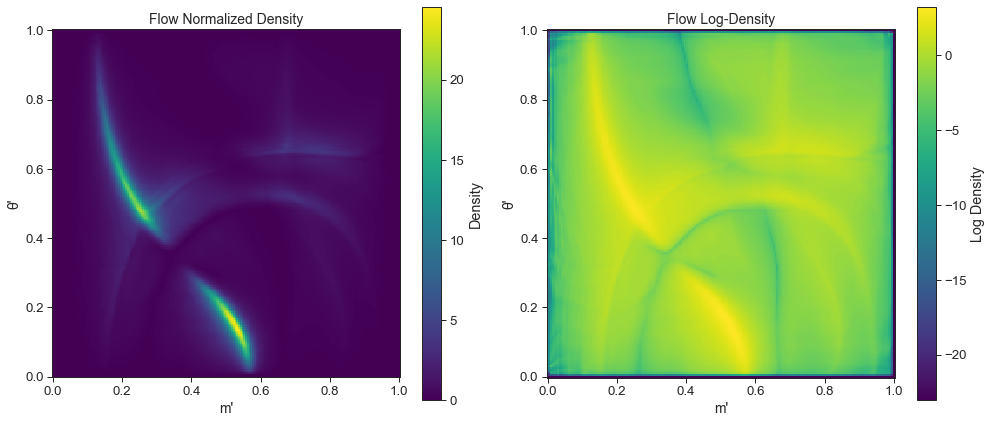


Density statistics:
  Min density: 0.000000e+00
  Max density: 2.453908e+01
  Mean density: 9.899323e-01
  Integral (approx): 0.989932

Plot saved to: flow_density_over_sdp.pdf


In [16]:
# Plot normalized density from the flow over the SDP
flow.eval()
flow.to(device)

# Create grid over [0,1]×[0,1]
U, V, pts = make_sdp_grid(nx=200, ny=200)

print("Computing density on grid...")
# Compute log probability on grid
with torch.no_grad():
    pts_tensor = torch.from_numpy(pts.astype(np.float32)).to(device)
    # Process in batches to avoid memory issues
    batch_size = 10000
    log_probs = []
    for i in range(0, len(pts_tensor), batch_size):
        batch = pts_tensor[i:i+batch_size]
        log_probs.append(flow.log_prob(batch).cpu().numpy())
    log_prob = np.concatenate(log_probs)

# Convert to probability density
density = np.exp(log_prob).reshape(U.shape)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 1. Density heatmap
im1 = axes[0].pcolormesh(U, V, density, cmap='viridis', shading='auto')
axes[0].set_xlabel("m'", fontsize=14)
axes[0].set_ylabel("θ'", fontsize=14)
axes[0].set_title('Flow Normalized Density', fontsize=14)
axes[0].set_aspect('equal')
plt.colorbar(im1, ax=axes[0], label='Density')

# 2. Log density heatmap (better for seeing structure)
log_density = np.log(density + 1e-10)  # Add small constant to avoid log(0)
im2 = axes[1].pcolormesh(U, V, log_density, cmap='viridis', shading='auto')
axes[1].set_xlabel("m'", fontsize=14)
axes[1].set_ylabel("θ'", fontsize=14)
axes[1].set_title('Flow Log-Density', fontsize=14)
axes[1].set_aspect('equal')
plt.colorbar(im2, ax=axes[1], label='Log Density')

plt.tight_layout()
plt.savefig('flow_density_over_sdp.pdf', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nDensity statistics:")
print(f"  Min density: {density.min():.6e}")
print(f"  Max density: {density.max():.6e}")
print(f"  Mean density: {density.mean():.6e}")
print(f"  Integral (approx): {density.sum() / (U.shape[0] * U.shape[1]):.6f}")
print(f"\nPlot saved to: flow_density_over_sdp.pdf")

In [18]:
def compute_mag_exact(pts, sdp_obj, flow, dkpp_model, device=None):
    
    S = sdp_to_dp(pts, sdp_obj)
    s12, s13 = S[:,0], S[:,1] 

    # amplitudes
    A12  = dkpp_model.full(np.column_stack([s12, s13]))
    mag12 = np.abs(A12)

    # Jacobian 
    _, invJ = mag_AD_from_flow(pts, flow, sdp_obj, idx = (1,2,3), device=device)
    invJ = _finite_pos(invJ)

    mag_exact = mag12 **2 * invJ
    return mag_exact

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

def plot_C_comparison_mtheta(
    C_flow,
    C_exact,
    *,
    extent=(0, 1, 0, 1),
    cmap="RdBu_r",            # back to previous scheme
    percentile=98,
    flow_title=r"Normalizing-flow estimate: $\mathcal{C}_{\mathrm{flow}}(m',\theta')$",
    exact_title=r"Isobar-model prediction: $\mathcal{C}_{\mathrm{exact}}(m',\theta')$",
    xlabel=r"$m'$",
    ylabel=r"$\theta'$",
    figsize=(12, 4.8),
    dpi=200,
    savepath=None,
):
    """
    Side-by-side comparison of C(m', theta') from a normalizing flow vs exact isobar model.
    - Shared robust, symmetric color normalization (centered at 0)
    - No colorbar
    - y-axis label shown on BOTH panels
    """

    # Robust symmetric color scale shared across panels
    ref = np.concatenate([np.ravel(C_exact), np.ravel(C_flow)])
    ref = ref[np.isfinite(ref)]
    vmax = np.nanpercentile(np.abs(ref), percentile) if ref.size else 1.0
    norm = TwoSlopeNorm(vcenter=0.0, vmin=-vmax, vmax=vmax)

    fig, axs = plt.subplots(1, 2, figsize=figsize, constrained_layout=True, dpi=dpi)

    axs[0].imshow(
        C_flow, origin="lower", extent=extent, norm=norm, cmap=cmap,
        interpolation="nearest", aspect="equal"
    )
    axs[0].set_title(flow_title, pad=8)
    axs[0].set_xlabel(xlabel)
    axs[0].set_ylabel(ylabel)

    axs[1].imshow(
        C_exact, origin="lower", extent=extent, norm=norm, cmap=cmap,
        interpolation="nearest", aspect="equal"
    )
    axs[1].set_title(exact_title, pad=8)
    axs[1].set_xlabel(xlabel)
    axs[1].set_ylabel(ylabel)

    # Subpanel labels
    axs[0].text(0.02, 0.98, "(a)", transform=axs[0].transAxes, va="top", ha="left")
    axs[1].text(0.02, 0.98, "(b)", transform=axs[1].transAxes, va="top", ha="left")

    # Paper-style ticks/spines
    for ax in axs:
        ax.tick_params(direction="out", length=3, width=0.8)
        for spine in ax.spines.values():
            spine.set_linewidth(0.8)

    if savepath is not None:
        fig.savefig(savepath, bbox_inches="tight")
    return fig, axs


Comparing flow density with exact isobar model...
Computing flow density...


/Users/san/opt/anaconda3/lib/python3.9/site-packages/nflows/transforms/coupling.py:561: UserWarning: Inputs to the softmax are not scaled down: initialization might be bad.
  warnings.warn(


Computing exact isobar model density...


/Users/san/Library/CloudStorage/OneDrive-CornellUniversity/Documents/GitHub/Gamma_Extraction/Amplitude.py:487: RuntimeWarning: divide by zero encountered in scalar divide
  dmp_dsij = -(1.0 / np.pi) * (1.0 / np.sqrt(one_minus_x2)) * (1.0 / (denom_m * np.sqrt(mijSq)))
/Users/san/Library/CloudStorage/OneDrive-CornellUniversity/Documents/GitHub/Gamma_Extraction/Amplitude.py:426: RuntimeWarning: divide by zero encountered in scalar divide
  cosHel = -(mikSq - self.mSq[i] - self.mSq[k] - 2.0 * EiCmsij * EkCmsij) / (2.0 * self.qi * self.qk)



Density statistics:
  Flow  - Min: 0.000000e+00, Max: 2.453908e+01, Mean: 9.899323e-01
  Exact - Min: 2.721803e-12, Max: 1.801406e+04, Mean: 7.321109e+02


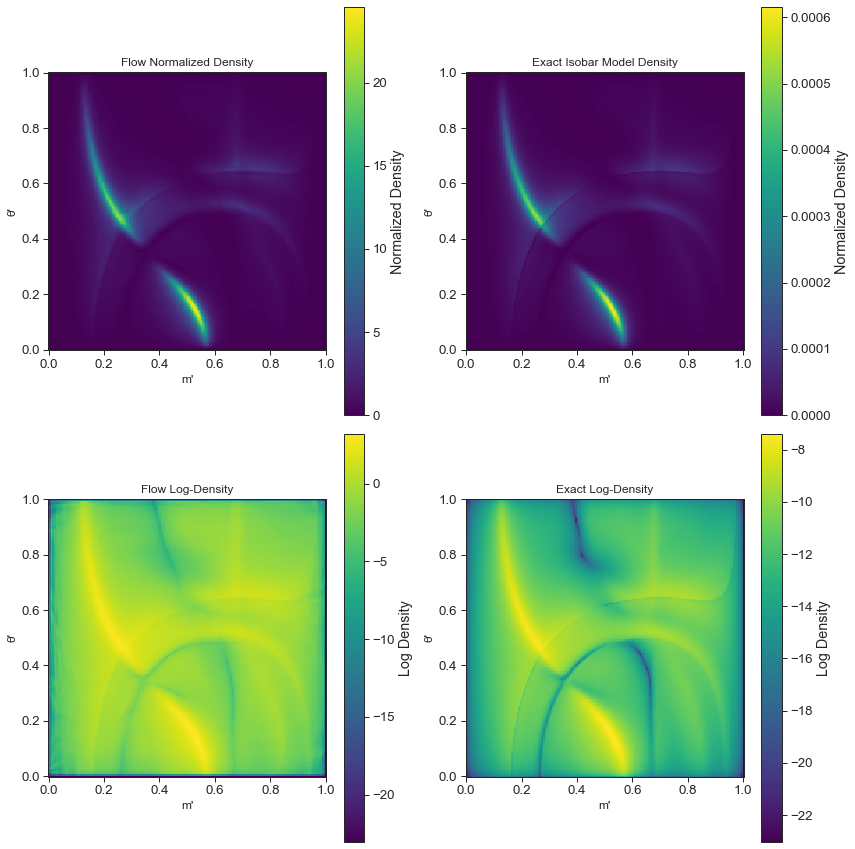


Comparison Metrics (normalized densities):
  MSE: 6.128212e+00
  MAE: 9.899074e-01
  Max absolute error: 2.453848e+01
  Correlation coefficient: 0.998869

Plot saved to: flow_vs_isobar_comparison.pdf


In [80]:
# Compare flow density with exact isobar model density
print("Comparing flow density with exact isobar model...")

# Initialize the isobar model
dkpp_model = DKpp()

# Create grid over [0,1]×[0,1] (reuse if already computed, or create new)
U, V, pts = make_sdp_grid(nx=200, ny=200)

# 1. Compute flow density (already done above, or recompute)
print("Computing flow density...")
flow.eval()
flow.to(device)

with torch.no_grad():
    pts_tensor = torch.from_numpy(pts.astype(np.float32)).to(device)
    batch_size = 10000
    log_probs = []
    for i in range(0, len(pts_tensor), batch_size):
        batch = pts_tensor[i:i+batch_size]
        log_probs.append(flow.log_prob(batch).cpu().numpy())
    log_prob_flow = np.concatenate(log_probs)

density_flow = np.exp(log_prob_flow).reshape(U.shape)

# 2. Compute exact density from isobar model
print("Computing exact isobar model density...")
density_exact = compute_mag_exact(pts, SDP, flow, dkpp_model, device=device).reshape(U.shape)

# Normalize both to have same integral (for fair comparison)
integral_exact = density_exact.sum()
density_flow_norm = density_flow 
density_exact_norm = density_exact / integral_exact

print(f"\nDensity statistics:")
print(f"  Flow  - Min: {density_flow.min():.6e}, Max: {density_flow.max():.6e}, Mean: {density_flow.mean():.6e}")
print(f"  Exact - Min: {density_exact.min():.6e}, Max: {density_exact.max():.6e}, Mean: {density_exact.mean():.6e}")

# 3. Plot comparison (2x2 grid)
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Row 1: Density comparisons
im0 = axes[0, 0].pcolormesh(U, V, density_flow_norm, cmap='viridis', shading='auto')
axes[0, 0].set_xlabel("m'", fontsize=12)
axes[0, 0].set_ylabel("θ'", fontsize=12)
axes[0, 0].set_title('Flow Normalized Density', fontsize=12)
axes[0, 0].set_aspect('equal')
plt.colorbar(im0, ax=axes[0, 0], label='Normalized Density')

im1 = axes[0, 1].pcolormesh(U, V, density_exact_norm, cmap='viridis', shading='auto')
axes[0, 1].set_xlabel("m'", fontsize=12)
axes[0, 1].set_ylabel("θ'", fontsize=12)
axes[0, 1].set_title('Exact Isobar Model Density', fontsize=12)
axes[0, 1].set_aspect('equal')
plt.colorbar(im1, ax=axes[0, 1], label='Normalized Density')

# Row 2: Log-scale comparisons
log_flow = np.log(density_flow_norm + 1e-10)
log_exact = np.log(density_exact_norm + 1e-10)

im3 = axes[1, 0].pcolormesh(U, V, log_flow, cmap='viridis', shading='auto')
axes[1, 0].set_xlabel("m'", fontsize=12)
axes[1, 0].set_ylabel("θ'", fontsize=12)
axes[1, 0].set_title('Flow Log-Density', fontsize=12)
axes[1, 0].set_aspect('equal')
plt.colorbar(im3, ax=axes[1, 0], label='Log Density')

im4 = axes[1, 1].pcolormesh(U, V, log_exact, cmap='viridis', shading='auto')
axes[1, 1].set_xlabel("m'", fontsize=12)
axes[1, 1].set_ylabel("θ'", fontsize=12)
axes[1, 1].set_title('Exact Log-Density', fontsize=12)
axes[1, 1].set_aspect('equal')
plt.colorbar(im4, ax=axes[1, 1], label='Log Density')

plt.tight_layout()
plt.savefig('flow_vs_isobar_comparison.pdf', dpi=150, bbox_inches='tight')
plt.show()

# 4. Compute and print comparison metrics
mse = np.mean((density_flow_norm - density_exact_norm)**2)
mae = np.mean(np.abs(density_flow_norm - density_exact_norm))
max_abs_error = np.max(np.abs(density_flow_norm - density_exact_norm))
correlation = np.corrcoef(density_flow_norm.ravel(), density_exact_norm.ravel())[0, 1]

print(f"\nComparison Metrics (normalized densities):")
print(f"  MSE: {mse:.6e}")
print(f"  MAE: {mae:.6e}")
print(f"  Max absolute error: {max_abs_error:.6e}")
print(f"  Correlation coefficient: {correlation:.6f}")
print(f"\nPlot saved to: flow_vs_isobar_comparison.pdf")

Creating publication-ready comparison plot...


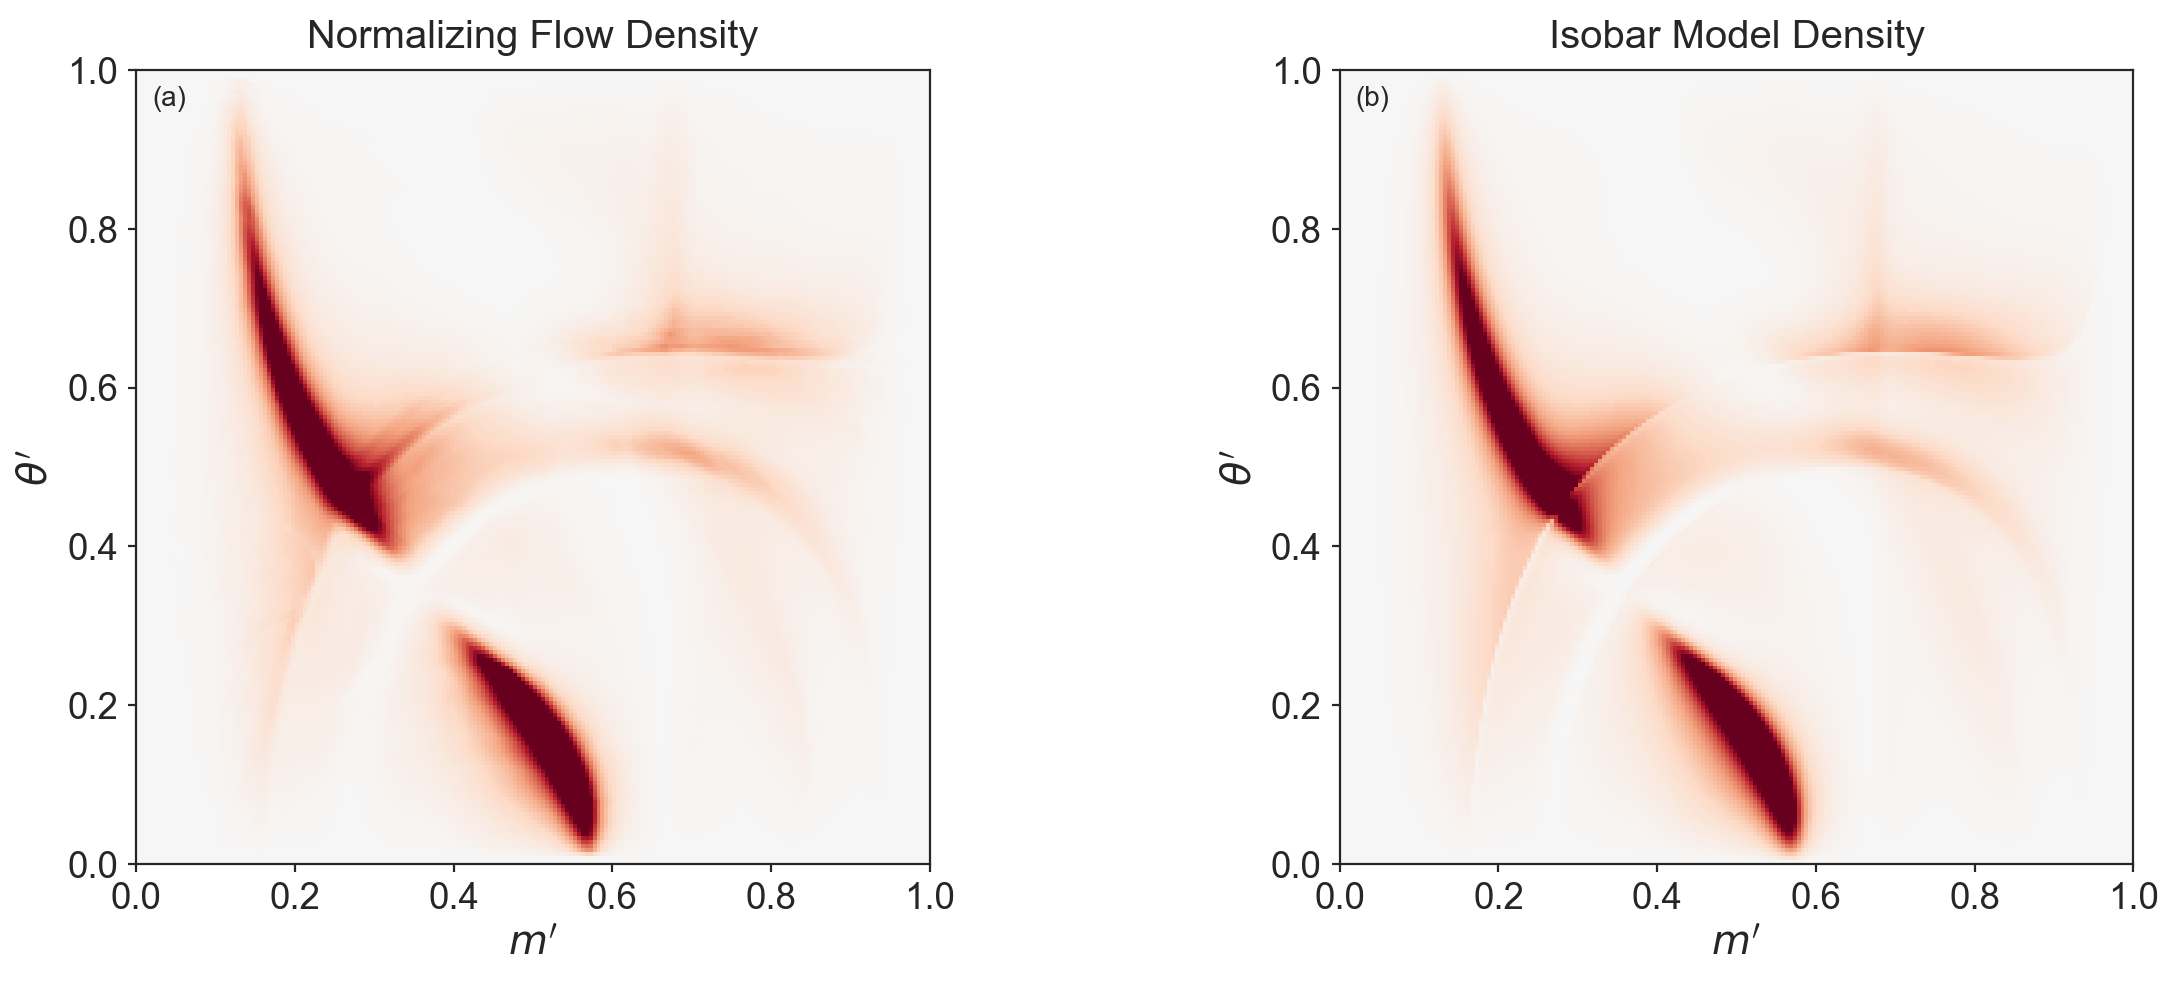

Publication-ready comparison saved to: C_comparison_mtheta.pdf


In [22]:
# Alternative visualization using the specialized plot_C_comparison_mtheta function

# Use the specialized comparison plotting function
fig, axs = plot_C_comparison_mtheta(
    C_flow=density_flow_norm,
    C_exact=density_exact_norm,
    extent=(0, 1, 0, 1),
    cmap="RdBu_r",
    percentile=98,
    flow_title=r"Normalizing Flow Density",
    exact_title=r"Isobar Model Density",
    xlabel=r"$m'$",
    ylabel=r"$\theta'$",
    figsize=(12, 4.8),
    dpi=200,
    savepath='C_comparison_mtheta.pdf'
)

plt.show()
print("Publication-ready comparison saved to: C_comparison_mtheta.pdf")

In [103]:
def make_sdp_grid_1d_slice(fixed_dim='m', fixed_value=0.5, n_points=200):
    """
    Create a 1D slice of the SDP grid with one dimension fixed.
    
    Parameters
    ----------
    fixed_dim : str
        Which dimension to fix: 'm' for m' or 'theta' for θ'
    fixed_value : float
        Value to fix the dimension at
    n_points : int
        Number of points along the varying dimension
    
    Returns
    -------
    varying_values : ndarray, shape (n_points,)
        Values along the varying dimension
    pts : ndarray, shape (n_points, 2)
        Points as (m', θ') pairs
    """
    if fixed_dim == 'm':
        # Fix m', vary θ'
        varying_values = np.linspace(0, 1, n_points)
        pts = np.column_stack([
            np.full(n_points, fixed_value),  # Fixed m'
            varying_values                    # Varying θ'
        ])
        return varying_values, pts
    elif fixed_dim == 'theta':
        # Fix θ', vary m'
        varying_values = np.linspace(0, 1, n_points)
        pts = np.column_stack([
            varying_values,                   # Varying m'
            np.full(n_points, fixed_value)   # Fixed θ'
        ])
        return varying_values, pts
    else:
        raise ValueError("fixed_dim must be 'm' or 'theta'")


def plot_density_slice_comparison(fixed_dim='m', fixed_value=0.5, n_points=200,
                                  flow_model=None, SDP_model=None, dkpp_model=None,
                                  device='cpu', savepath=None):
    """
    Compare flow density with exact isobar model density along a 1D slice.
    
    Parameters
    ----------
    fixed_dim : str
        Which dimension to fix: 'm' for m' or 'theta' for θ'
    fixed_value : float
        Value to fix the dimension at
    n_points : int
        Number of points along the varying dimension
    flow_model : torch model
        Trained flow model
    SDP_model : torch model
        SDP model for exact density computation
    dkpp_model : DKpp instance
        D→Kππ amplitude model
    device : str
        Device for computation
    savepath : str, optional
        Path to save the figure
    
    Returns
    -------
    varying_values : ndarray
        Values along the varying dimension
    density_exact_norm : ndarray
        Normalized exact density
    density_flow_norm : ndarray
        Normalized flow density
    """
    # Determine labels based on fixed dimension
    if fixed_dim == 'm':
        varying_label = "θ'"
        fixed_label = "m'"
    elif fixed_dim == 'theta':
        varying_label = "m'"
        fixed_label = "θ'"
    else:
        raise ValueError("fixed_dim must be 'm' or 'theta'")
    
    print(f"Comparing flow density with exact isobar model at fixed {fixed_label} = {fixed_value:.4f}...")
    
    # Create 1D grid
    varying_values, pts = make_sdp_grid_1d_slice(fixed_dim=fixed_dim, 
                                                  fixed_value=fixed_value, 
                                                  n_points=n_points)
    
    # 1. Compute flow density
    print(f"Computing flow density...")
    flow_model.eval()
    flow_model.to(device)
    
    with torch.no_grad():
        pts_tensor = torch.from_numpy(pts.astype(np.float32)).to(device)
        batch_size = 10000
        log_probs = []
        for i in range(0, len(pts_tensor), batch_size):
            batch = pts_tensor[i:i+batch_size]
            log_probs.append(flow_model.log_prob(batch).cpu().numpy())
        log_prob_flow = np.concatenate(log_probs)
    
    density_flow = np.exp(log_prob_flow)  # 1D array
    
    # 2. Compute exact density from isobar model
    print("Computing exact isobar model density...")
    density_exact = compute_mag_exact(pts, SDP_model, flow_model, dkpp_model, device=device)
    
    # Convert to numpy if tensor
    if torch.is_tensor(density_exact):
        density_exact = density_exact.cpu().numpy()
    
    density_exact = density_exact.flatten()  # Ensure 1D
    
    # Normalize both
    integral_exact = density_exact.sum()
    density_flow_norm = density_flow / density_flow.sum()
    density_exact_norm = density_exact / integral_exact
    
    print(f"\nDensity statistics:")
    print(f"  Flow  - Min: {density_flow.min():.6e}, Max: {density_flow.max():.6e}, Mean: {density_flow.mean():.6e}")
    print(f"  Exact - Min: {density_exact.min():.6e}, Max: {density_exact.max():.6e}, Mean: {density_exact.mean():.6e}")
    
    # 3. Plot comparison
    fig, ax = plt.subplots(figsize=(10, 6))
    
    ax.plot(varying_values, density_exact_norm, 'b-', linewidth=2.5, 
            label='Exact (Isobar)', marker='o', markersize=3)
    ax.plot(varying_values, density_flow_norm, 'r--', linewidth=2.5, 
            label='Flow', marker='s', markersize=3)
    ax.set_xlabel(varying_label, fontsize=14)
    ax.set_ylabel('Normalized Density', fontsize=14)
    ax.set_title(f"Density vs {varying_label} at {fixed_label} = {fixed_value:.4f}", 
                 fontsize=14, fontweight='bold')
    ax.legend(fontsize=12, loc='best')
    ax.grid(True, alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    
    # Generate default savepath if not provided
    if savepath is None:
        savepath = f'flow_vs_isobar_1d_slice_{fixed_dim}{fixed_value:.2f}.pdf'
    
    plt.savefig(savepath, dpi=150, bbox_inches='tight')
    plt.show()
    
    # 4. Compute and print comparison metrics
    mse = np.mean((density_flow_norm - density_exact_norm)**2)
    mae = np.mean(np.abs(density_flow_norm - density_exact_norm))
    max_abs_error = np.max(np.abs(density_flow_norm - density_exact_norm))
    correlation = np.corrcoef(density_flow_norm, density_exact_norm)[0, 1]
    
    print(f"\nComparison Metrics (normalized densities):")
    print(f"  MSE: {mse:.6e}")
    print(f"  MAE: {mae:.6e}")
    print(f"  Max absolute error: {max_abs_error:.6e}")
    print(f"  Correlation coefficient: {correlation:.6f}")
    print(f"\nPlot saved to: {savepath}")
    
    return varying_values, density_exact_norm, density_flow_norm



Comparing flow density with exact isobar model at fixed m' = 0.5000...
Computing flow density...
Computing exact isobar model density...


/Users/san/opt/anaconda3/lib/python3.9/site-packages/nflows/transforms/coupling.py:561: UserWarning: Inputs to the softmax are not scaled down: initialization might be bad.
  warnings.warn(



Density statistics:
  Flow  - Min: 2.644222e-40, Max: 2.203160e+01, Mean: 2.063099e+00
  Exact - Min: 2.396805e+00, Max: 1.651551e+04, Mean: 1.523762e+03


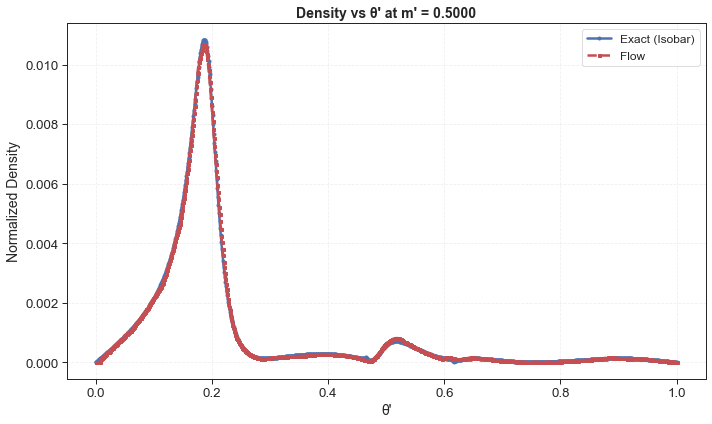


Comparison Metrics (normalized densities):
  MSE: 2.640281e-09
  MAE: 2.847364e-05
  Max absolute error: 2.852438e-04
  Correlation coefficient: 0.999760

Plot saved to: flow_vs_isobar_1d_slice_m0.50.pdf
Comparing flow density with exact isobar model at fixed θ' = 0.5000...
Computing flow density...
Computing exact isobar model density...

Density statistics:
  Flow  - Min: 2.522337e-44, Max: 1.933962e+01, Mean: 2.335267e+00
  Exact - Min: 2.721803e-12, Max: 1.470571e+04, Mean: 1.736948e+03


/Users/san/opt/anaconda3/lib/python3.9/site-packages/nflows/transforms/coupling.py:561: UserWarning: Inputs to the softmax are not scaled down: initialization might be bad.
  warnings.warn(
/Users/san/Library/CloudStorage/OneDrive-CornellUniversity/Documents/GitHub/Gamma_Extraction/Amplitude.py:487: RuntimeWarning: divide by zero encountered in scalar divide
  dmp_dsij = -(1.0 / np.pi) * (1.0 / np.sqrt(one_minus_x2)) * (1.0 / (denom_m * np.sqrt(mijSq)))
/Users/san/Library/CloudStorage/OneDrive-CornellUniversity/Documents/GitHub/Gamma_Extraction/Amplitude.py:426: RuntimeWarning: divide by zero encountered in scalar divide
  cosHel = -(mikSq - self.mSq[i] - self.mSq[k] - 2.0 * EiCmsij * EkCmsij) / (2.0 * self.qi * self.qk)


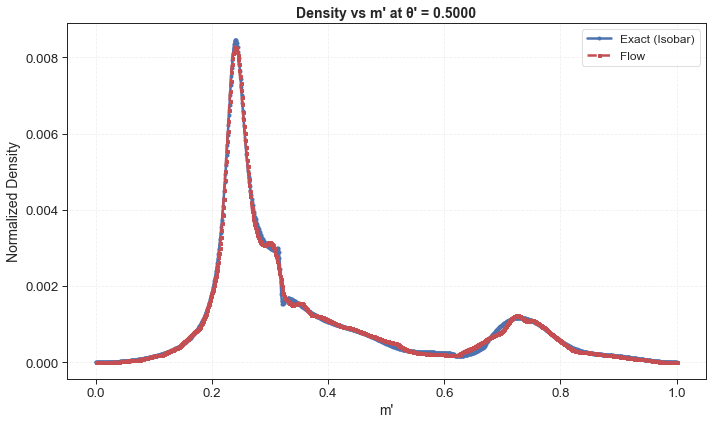


Comparison Metrics (normalized densities):
  MSE: 5.620381e-09
  MAE: 4.426799e-05
  Max absolute error: 4.650004e-04
  Correlation coefficient: 0.998840

Plot saved to: flow_vs_isobar_1d_slice_theta0.50.pdf


(array([0.        , 0.001001  , 0.002002  , 0.003003  , 0.004004  ,
        0.00500501, 0.00600601, 0.00700701, 0.00800801, 0.00900901,
        0.01001001, 0.01101101, 0.01201201, 0.01301301, 0.01401401,
        0.01501502, 0.01601602, 0.01701702, 0.01801802, 0.01901902,
        0.02002002, 0.02102102, 0.02202202, 0.02302302, 0.02402402,
        0.02502503, 0.02602603, 0.02702703, 0.02802803, 0.02902903,
        0.03003003, 0.03103103, 0.03203203, 0.03303303, 0.03403403,
        0.03503504, 0.03603604, 0.03703704, 0.03803804, 0.03903904,
        0.04004004, 0.04104104, 0.04204204, 0.04304304, 0.04404404,
        0.04504505, 0.04604605, 0.04704705, 0.04804805, 0.04904905,
        0.05005005, 0.05105105, 0.05205205, 0.05305305, 0.05405405,
        0.05505506, 0.05605606, 0.05705706, 0.05805806, 0.05905906,
        0.06006006, 0.06106106, 0.06206206, 0.06306306, 0.06406406,
        0.06506507, 0.06606607, 0.06706707, 0.06806807, 0.06906907,
        0.07007007, 0.07107107, 0.07207207, 0.07

In [107]:
# Example usage:

# Plot density vs θ' at fixed m' = 0.5
plot_density_slice_comparison(
    fixed_dim='m', 
    fixed_value=0.5, 
    n_points=1000,
    flow_model=flow, 
    SDP_model=SDP, 
    dkpp_model=dkpp_model,
    device=device
)

# Plot density vs m' at fixed θ' = 0.3
plot_density_slice_comparison(
    fixed_dim='theta', 
    fixed_value=0.5, 
    n_points=1000,
    flow_model=flow, 
    SDP_model=SDP, 
    dkpp_model=dkpp_model,
    device=device
)


Comparing ensemble flow density with exact isobar model at fixed m' = 0.5000...
Loading ensemble densities...
Combining models from 1 ensemble(s): ['test_ensemble2']

  Loading from test_ensemble2...
    Found 20 models
      Processing model 1/20...
      Processing model 2/20...
      Processing model 3/20...
      Processing model 4/20...


/Users/san/opt/anaconda3/lib/python3.9/site-packages/nflows/transforms/coupling.py:561: UserWarning: Inputs to the softmax are not scaled down: initialization might be bad.
  warnings.warn(


      Processing model 5/20...
      Processing model 6/20...
      Processing model 7/20...
      Processing model 8/20...
      Processing model 9/20...
      Processing model 10/20...
      Processing model 11/20...
      Processing model 12/20...
      Processing model 13/20...
      Processing model 14/20...
      Processing model 15/20...
      Processing model 16/20...
      Processing model 17/20...
      Processing model 18/20...
      Processing model 19/20...
      Processing model 20/20...

  Total models combined: 20
Computing exact isobar model density...

Density statistics:
  Ensemble Mean - Min: 1.976871e-39, Max: 5.386860e-02
  Ensemble Std  - Min: 0.000000e+00, Max: 1.884218e-03
  Exact         - Min: 7.896585e-06, Max: 5.438991e-02


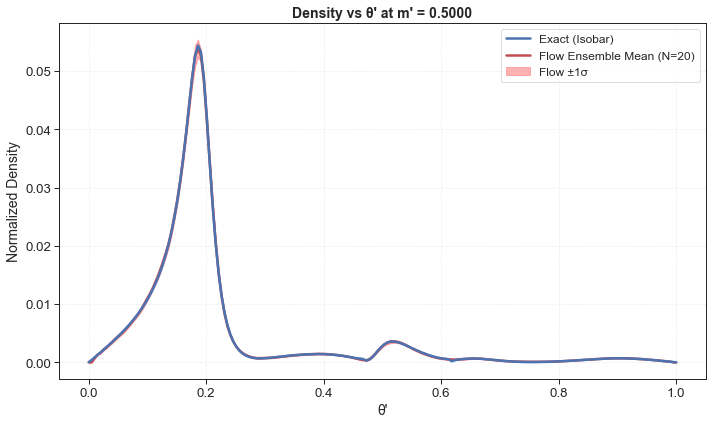


Comparison Metrics (normalized densities):
  MSE: 1.360530e-08
  MAE: 6.242690e-05
  Max absolute error: 6.048058e-04
  Correlation coefficient: 0.999945
  Coverage (exact within ±1σ): 89.0% (Expected: ~68%)

Plot saved to: ensemble_vs_isobar_1d_slice_m0.50.pdf
Comparing ensemble flow density with exact isobar model at fixed θ' = 0.3000...
Loading ensemble densities...
Combining models from 1 ensemble(s): ['test_ensemble2']

  Loading from test_ensemble2...
    Found 20 models
      Processing model 1/20...
      Processing model 2/20...


/Users/san/opt/anaconda3/lib/python3.9/site-packages/nflows/transforms/coupling.py:561: UserWarning: Inputs to the softmax are not scaled down: initialization might be bad.
  warnings.warn(


      Processing model 3/20...
      Processing model 4/20...
      Processing model 5/20...
      Processing model 6/20...
      Processing model 7/20...
      Processing model 8/20...
      Processing model 9/20...
      Processing model 10/20...
      Processing model 11/20...
      Processing model 12/20...
      Processing model 13/20...
      Processing model 14/20...
      Processing model 15/20...
      Processing model 16/20...
      Processing model 17/20...
      Processing model 18/20...
      Processing model 19/20...
      Processing model 20/20...

  Total models combined: 20
Computing exact isobar model density...

Density statistics:
  Ensemble Mean - Min: 1.639832e-39, Max: 2.472339e-02
  Ensemble Std  - Min: 0.000000e+00, Max: 2.143543e-03
  Exact         - Min: 3.640702e-17, Max: 2.578006e-02


/Users/san/Library/CloudStorage/OneDrive-CornellUniversity/Documents/GitHub/Gamma_Extraction/Amplitude.py:487: RuntimeWarning: divide by zero encountered in scalar divide
  dmp_dsij = -(1.0 / np.pi) * (1.0 / np.sqrt(one_minus_x2)) * (1.0 / (denom_m * np.sqrt(mijSq)))
/Users/san/Library/CloudStorage/OneDrive-CornellUniversity/Documents/GitHub/Gamma_Extraction/Amplitude.py:426: RuntimeWarning: divide by zero encountered in scalar divide
  cosHel = -(mikSq - self.mSq[i] - self.mSq[k] - 2.0 * EiCmsij * EkCmsij) / (2.0 * self.qi * self.qk)


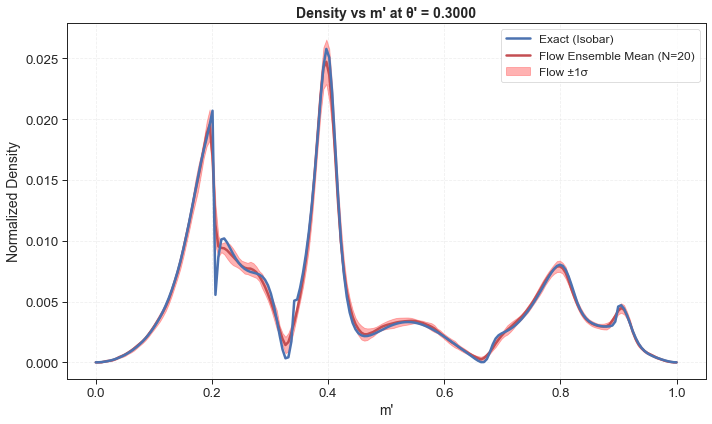


Comparison Metrics (normalized densities):
  MSE: 3.549643e-07
  MAE: 2.559180e-04
  Max absolute error: 5.749553e-03
  Correlation coefficient: 0.993603
  Coverage (exact within ±1σ): 84.0% (Expected: ~68%)

Plot saved to: ensemble_vs_isobar_1d_slice_theta0.30.pdf


(array([0.        , 0.00502513, 0.01005025, 0.01507538, 0.0201005 ,
        0.02512563, 0.03015075, 0.03517588, 0.04020101, 0.04522613,
        0.05025126, 0.05527638, 0.06030151, 0.06532663, 0.07035176,
        0.07537688, 0.08040201, 0.08542714, 0.09045226, 0.09547739,
        0.10050251, 0.10552764, 0.11055276, 0.11557789, 0.12060302,
        0.12562814, 0.13065327, 0.13567839, 0.14070352, 0.14572864,
        0.15075377, 0.15577889, 0.16080402, 0.16582915, 0.17085427,
        0.1758794 , 0.18090452, 0.18592965, 0.19095477, 0.1959799 ,
        0.20100503, 0.20603015, 0.21105528, 0.2160804 , 0.22110553,
        0.22613065, 0.23115578, 0.2361809 , 0.24120603, 0.24623116,
        0.25125628, 0.25628141, 0.26130653, 0.26633166, 0.27135678,
        0.27638191, 0.28140704, 0.28643216, 0.29145729, 0.29648241,
        0.30150754, 0.30653266, 0.31155779, 0.31658291, 0.32160804,
        0.32663317, 0.33165829, 0.33668342, 0.34170854, 0.34673367,
        0.35175879, 0.35678392, 0.36180905, 0.36

In [108]:
def plot_density_slice_ensemble_comparison(fixed_dim='m', fixed_value=0.5, n_points=200,
                                          ensemble_dirs='test_ensemble2_odd',
                                          num_flows=16, hidden_features=128, num_bins=16,
                                          SDP_model=None, dkpp_model=None,
                                          device='cpu', savepath=None):
    """
    Compare ensemble flow density (mean ± std) with exact isobar model density along a 1D slice.
    
    Parameters
    ----------
    fixed_dim : str
        Which dimension to fix: 'm' for m' or 'theta' for θ'
    fixed_value : float
        Value to fix the dimension at
    n_points : int
        Number of points along the varying dimension
    ensemble_dirs : str or list of str
        Ensemble directory/directories to load models from
    num_flows, hidden_features, num_bins : int
        Flow architecture parameters
    SDP_model : torch model
        SDP model for exact density computation
    dkpp_model : DKpp instance
        D→Kππ amplitude model
    device : str
        Device for computation
    savepath : str, optional
        Path to save the figure
    
    Returns
    -------
    varying_values : ndarray
        Values along the varying dimension
    density_exact_norm : ndarray
        Normalized exact density
    ensemble_mean : ndarray
        Mean of normalized ensemble densities
    ensemble_std : ndarray
        Std of normalized ensemble densities
    """
    # Determine labels based on fixed dimension
    if fixed_dim == 'm':
        varying_label = "θ'"
        fixed_label = "m'"
    elif fixed_dim == 'theta':
        varying_label = "m'"
        fixed_label = "θ'"
    else:
        raise ValueError("fixed_dim must be 'm' or 'theta'")
    
    print(f"Comparing ensemble flow density with exact isobar model at fixed {fixed_label} = {fixed_value:.4f}...")
    
    # Create 1D grid
    varying_values, pts = make_sdp_grid_1d_slice(fixed_dim=fixed_dim, 
                                                  fixed_value=fixed_value, 
                                                  n_points=n_points)
    
    # Grid shape for 1D slice
    grid_shape = (n_points,)
    
    # Load ensemble and compute densities
    print(f"Loading ensemble densities...")
    ensemble_densities, total_models, ensemble_info = load_combined_ensemble_densities(
        ensemble_dirs=ensemble_dirs,
        pts=pts,
        grid_shape=grid_shape,
        num_flows=num_flows,
        hidden_features=hidden_features,
        num_bins=num_bins,
        device=device
    )
    
    # Compute ensemble statistics
    # ensemble_densities shape: (total_models, n_points)
    ensemble_mean = np.mean(ensemble_densities, axis=0)
    ensemble_std = np.std(ensemble_densities, axis=0)
    
    # Compute exact density from isobar model
    print("Computing exact isobar model density...")
    
    # Load a flow model for compute_mag_exact (use first from ensemble or create dummy)
    flow_dummy = create_flow(num_flows=num_flows, hidden_features=hidden_features, num_bins=num_bins)
    flow_dummy.eval()
    flow_dummy.to(device)
    
    density_exact = compute_mag_exact(pts, SDP_model, flow_dummy, dkpp_model, device=device)
    
    # Convert to numpy if tensor
    if torch.is_tensor(density_exact):
        density_exact = density_exact.cpu().numpy()
    
    density_exact = density_exact.flatten()  # Ensure 1D
    
    # Normalize exact density
    density_exact_norm = density_exact / density_exact.sum()
    
    print(f"\nDensity statistics:")
    print(f"  Ensemble Mean - Min: {ensemble_mean.min():.6e}, Max: {ensemble_mean.max():.6e}")
    print(f"  Ensemble Std  - Min: {ensemble_std.min():.6e}, Max: {ensemble_std.max():.6e}")
    print(f"  Exact         - Min: {density_exact_norm.min():.6e}, Max: {density_exact_norm.max():.6e}")
    
    # Plot comparison
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot exact density
    ax.plot(varying_values, density_exact_norm, 'b-', linewidth=2.5, 
            label='Exact (Isobar)', zorder=3)
    
    # Plot ensemble mean
    ax.plot(varying_values, ensemble_mean, 'r-', linewidth=2.5, 
            label=f'Flow Ensemble Mean (N={total_models})', zorder=2)
    
    # Plot ±1σ band
    ax.fill_between(varying_values, 
                     ensemble_mean - ensemble_std, 
                     ensemble_mean + ensemble_std,
                     color='red', alpha=0.3, label='Flow ±1σ', zorder=1)
    
    ax.set_xlabel(varying_label, fontsize=14)
    ax.set_ylabel('Normalized Density', fontsize=14)
    ax.set_title(f"Density vs {varying_label} at {fixed_label} = {fixed_value:.4f}", 
                 fontsize=14, fontweight='bold')
    ax.legend(fontsize=12, loc='best')
    ax.grid(True, alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    
    # Generate default savepath if not provided
    if savepath is None:
        savepath = f'ensemble_vs_isobar_1d_slice_{fixed_dim}{fixed_value:.2f}.pdf'
    
    plt.savefig(savepath, dpi=150, bbox_inches='tight')
    plt.show()
    
    # Compute and print comparison metrics
    mse = np.mean((ensemble_mean - density_exact_norm)**2)
    mae = np.mean(np.abs(ensemble_mean - density_exact_norm))
    max_abs_error = np.max(np.abs(ensemble_mean - density_exact_norm))
    correlation = np.corrcoef(ensemble_mean, density_exact_norm)[0, 1]
    
    # Check coverage (how often exact falls within ±1σ)
    within_band = np.abs(density_exact_norm - ensemble_mean) <= ensemble_std
    coverage = np.mean(within_band)
    
    print(f"\nComparison Metrics (normalized densities):")
    print(f"  MSE: {mse:.6e}")
    print(f"  MAE: {mae:.6e}")
    print(f"  Max absolute error: {max_abs_error:.6e}")
    print(f"  Correlation coefficient: {correlation:.6f}")
    print(f"  Coverage (exact within ±1σ): {coverage:.1%} (Expected: ~68%)")
    print(f"\nPlot saved to: {savepath}")
    
    return varying_values, density_exact_norm, ensemble_mean, ensemble_std


# Example usage:

# Plot density vs θ' at fixed m' = 0.5 with ensemble
plot_density_slice_ensemble_comparison(
    fixed_dim='m', 
    fixed_value=0.5, 
    n_points=200,
    ensemble_dirs='test_ensemble2_odd',  # or ['test_ensemble', 'test_ensemble2_odd']
    num_flows=16,
    hidden_features=128,
    num_bins=16,
    SDP_model=SDP, 
    dkpp_model=dkpp_model,
    device=device
)

# Plot density vs m' at fixed θ' = 0.3 with ensemble
plot_density_slice_ensemble_comparison(
    fixed_dim='theta', 
    fixed_value=0.3, 
    n_points=200,
    ensemble_dirs='test_ensemble2_odd',
    SDP_model=SDP, 
    dkpp_model=dkpp_model,
    device=device
)

Comparing ensemble flow density with exact isobar model at fixed m' = 0.5000...
Loading ensemble densities...
Combining models from 1 ensemble(s): ['test_ensemble2']

  Loading from test_ensemble2...
    Found 20 models
      Processing model 1/20...
      Processing model 2/20...
      Processing model 3/20...
      Processing model 4/20...


/Users/san/opt/anaconda3/lib/python3.9/site-packages/nflows/transforms/coupling.py:561: UserWarning: Inputs to the softmax are not scaled down: initialization might be bad.
  warnings.warn(


      Processing model 5/20...
      Processing model 6/20...
      Processing model 7/20...
      Processing model 8/20...
      Processing model 9/20...
      Processing model 10/20...
      Processing model 11/20...
      Processing model 12/20...
      Processing model 13/20...
      Processing model 14/20...
      Processing model 15/20...
      Processing model 16/20...
      Processing model 17/20...
      Processing model 18/20...
      Processing model 19/20...
      Processing model 20/20...

  Total models combined: 20
Computing exact isobar model density...

Density statistics:
  Ensemble Mean - Min: 1.976871e-39, Max: 5.386860e-02
  Ensemble 16%  - Min: 1.608130e-43, Max: 5.259022e-02
  Ensemble 84%  - Min: 2.283212e-39, Max: 5.500293e-02
  Exact         - Min: 7.896585e-06, Max: 5.438991e-02


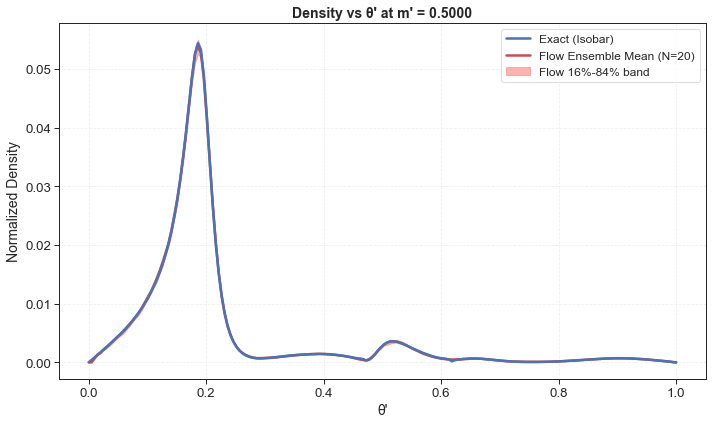


Comparison Metrics (normalized densities):
  MSE: 1.360530e-08
  MAE: 6.242690e-05
  Max absolute error: 6.048058e-04
  Correlation coefficient: 0.999945
  Coverage (exact within 16%-84% band): 86.0% (Expected: ~68%)

Plot saved to: ensemble_vs_isobar_1d_slice_m0.50.pdf
Comparing ensemble flow density with exact isobar model at fixed θ' = 0.3000...
Loading ensemble densities...
Combining models from 1 ensemble(s): ['test_ensemble2']

  Loading from test_ensemble2...
    Found 20 models
      Processing model 1/20...
      Processing model 2/20...
      Processing model 3/20...
      Processing model 4/20...
      Processing model 5/20...


/Users/san/opt/anaconda3/lib/python3.9/site-packages/nflows/transforms/coupling.py:561: UserWarning: Inputs to the softmax are not scaled down: initialization might be bad.
  warnings.warn(


      Processing model 6/20...
      Processing model 7/20...
      Processing model 8/20...
      Processing model 9/20...
      Processing model 10/20...
      Processing model 11/20...
      Processing model 12/20...
      Processing model 13/20...
      Processing model 14/20...
      Processing model 15/20...
      Processing model 16/20...
      Processing model 17/20...
      Processing model 18/20...
      Processing model 19/20...
      Processing model 20/20...

  Total models combined: 20
Computing exact isobar model density...

Density statistics:
  Ensemble Mean - Min: 1.639832e-39, Max: 2.472339e-02
  Ensemble 16%  - Min: 0.000000e+00, Max: 2.316998e-02
  Ensemble 84%  - Min: 9.465698e-41, Max: 2.590482e-02
  Exact         - Min: 3.640702e-17, Max: 2.578006e-02


/Users/san/Library/CloudStorage/OneDrive-CornellUniversity/Documents/GitHub/Gamma_Extraction/Amplitude.py:487: RuntimeWarning: divide by zero encountered in scalar divide
  dmp_dsij = -(1.0 / np.pi) * (1.0 / np.sqrt(one_minus_x2)) * (1.0 / (denom_m * np.sqrt(mijSq)))
/Users/san/Library/CloudStorage/OneDrive-CornellUniversity/Documents/GitHub/Gamma_Extraction/Amplitude.py:426: RuntimeWarning: divide by zero encountered in scalar divide
  cosHel = -(mikSq - self.mSq[i] - self.mSq[k] - 2.0 * EiCmsij * EkCmsij) / (2.0 * self.qi * self.qk)


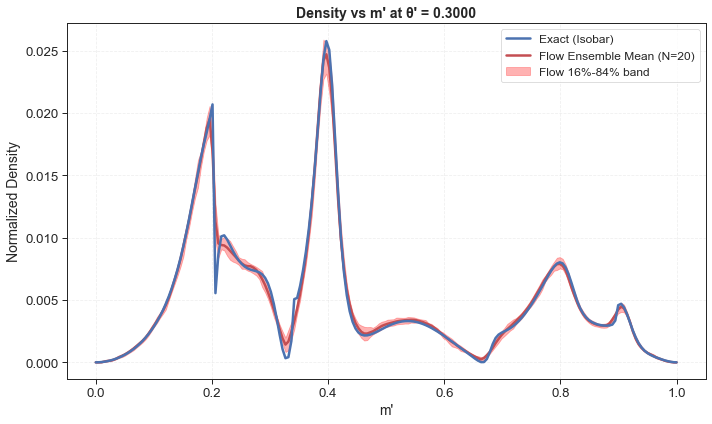


Comparison Metrics (normalized densities):
  MSE: 3.549643e-07
  MAE: 2.559180e-04
  Max absolute error: 5.749553e-03
  Correlation coefficient: 0.993603
  Coverage (exact within 16%-84% band): 78.0% (Expected: ~68%)

Plot saved to: ensemble_vs_isobar_1d_slice_theta0.30.pdf


(array([0.        , 0.00502513, 0.01005025, 0.01507538, 0.0201005 ,
        0.02512563, 0.03015075, 0.03517588, 0.04020101, 0.04522613,
        0.05025126, 0.05527638, 0.06030151, 0.06532663, 0.07035176,
        0.07537688, 0.08040201, 0.08542714, 0.09045226, 0.09547739,
        0.10050251, 0.10552764, 0.11055276, 0.11557789, 0.12060302,
        0.12562814, 0.13065327, 0.13567839, 0.14070352, 0.14572864,
        0.15075377, 0.15577889, 0.16080402, 0.16582915, 0.17085427,
        0.1758794 , 0.18090452, 0.18592965, 0.19095477, 0.1959799 ,
        0.20100503, 0.20603015, 0.21105528, 0.2160804 , 0.22110553,
        0.22613065, 0.23115578, 0.2361809 , 0.24120603, 0.24623116,
        0.25125628, 0.25628141, 0.26130653, 0.26633166, 0.27135678,
        0.27638191, 0.28140704, 0.28643216, 0.29145729, 0.29648241,
        0.30150754, 0.30653266, 0.31155779, 0.31658291, 0.32160804,
        0.32663317, 0.33165829, 0.33668342, 0.34170854, 0.34673367,
        0.35175879, 0.35678392, 0.36180905, 0.36

In [109]:
def plot_density_slice_ensemble_comparison(fixed_dim='m', fixed_value=0.5, n_points=200,
                                          ensemble_dirs='test_ensemble2_odd',
                                          num_flows=16, hidden_features=128, num_bins=16,
                                          SDP_model=None, dkpp_model=None,
                                          device='cpu', savepath=None):
    """
    Compare ensemble flow density (mean with 16%-84% percentile band) with exact isobar model density along a 1D slice.
    
    Parameters
    ----------
    fixed_dim : str
        Which dimension to fix: 'm' for m' or 'theta' for θ'
    fixed_value : float
        Value to fix the dimension at
    n_points : int
        Number of points along the varying dimension
    ensemble_dirs : str or list of str
        Ensemble directory/directories to load models from
    num_flows, hidden_features, num_bins : int
        Flow architecture parameters
    SDP_model : torch model
        SDP model for exact density computation
    dkpp_model : DKpp instance
        D→Kππ amplitude model
    device : str
        Device for computation
    savepath : str, optional
        Path to save the figure
    
    Returns
    -------
    varying_values : ndarray
        Values along the varying dimension
    density_exact_norm : ndarray
        Normalized exact density
    ensemble_mean : ndarray
        Mean of normalized ensemble densities
    ensemble_p16 : ndarray
        16th percentile of ensemble densities
    ensemble_p84 : ndarray
        84th percentile of ensemble densities
    """
    # Determine labels based on fixed dimension
    if fixed_dim == 'm':
        varying_label = "θ'"
        fixed_label = "m'"
    elif fixed_dim == 'theta':
        varying_label = "m'"
        fixed_label = "θ'"
    else:
        raise ValueError("fixed_dim must be 'm' or 'theta'")
    
    print(f"Comparing ensemble flow density with exact isobar model at fixed {fixed_label} = {fixed_value:.4f}...")
    
    # Create 1D grid
    varying_values, pts = make_sdp_grid_1d_slice(fixed_dim=fixed_dim, 
                                                  fixed_value=fixed_value, 
                                                  n_points=n_points)
    
    # Grid shape for 1D slice
    grid_shape = (n_points,)
    
    # Load ensemble and compute densities
    print(f"Loading ensemble densities...")
    ensemble_densities, total_models, ensemble_info = load_combined_ensemble_densities(
        ensemble_dirs=ensemble_dirs,
        pts=pts,
        grid_shape=grid_shape,
        num_flows=num_flows,
        hidden_features=hidden_features,
        num_bins=num_bins,
        device=device
    )
    
    # Compute ensemble statistics
    # ensemble_densities shape: (total_models, n_points)
    ensemble_mean = np.mean(ensemble_densities, axis=0)
    ensemble_p16 = np.percentile(ensemble_densities, 16, axis=0)
    ensemble_p84 = np.percentile(ensemble_densities, 84, axis=0)
    
    # Compute exact density from isobar model
    print("Computing exact isobar model density...")
    
    # Load a flow model for compute_mag_exact (use first from ensemble or create dummy)
    flow_dummy = create_flow(num_flows=num_flows, hidden_features=hidden_features, num_bins=num_bins)
    flow_dummy.eval()
    flow_dummy.to(device)
    
    density_exact = compute_mag_exact(pts, SDP_model, flow_dummy, dkpp_model, device=device)
    
    # Convert to numpy if tensor
    if torch.is_tensor(density_exact):
        density_exact = density_exact.cpu().numpy()
    
    density_exact = density_exact.flatten()  # Ensure 1D
    
    # Normalize exact density
    density_exact_norm = density_exact / density_exact.sum()
    
    print(f"\nDensity statistics:")
    print(f"  Ensemble Mean - Min: {ensemble_mean.min():.6e}, Max: {ensemble_mean.max():.6e}")
    print(f"  Ensemble 16%  - Min: {ensemble_p16.min():.6e}, Max: {ensemble_p16.max():.6e}")
    print(f"  Ensemble 84%  - Min: {ensemble_p84.min():.6e}, Max: {ensemble_p84.max():.6e}")
    print(f"  Exact         - Min: {density_exact_norm.min():.6e}, Max: {density_exact_norm.max():.6e}")
    
    # Plot comparison
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot exact density
    ax.plot(varying_values, density_exact_norm, 'b-', linewidth=2.5, 
            label='Exact (Isobar)', zorder=3)
    
    # Plot ensemble mean
    ax.plot(varying_values, ensemble_mean, 'r-', linewidth=2.5, 
            label=f'Flow Ensemble Mean (N={total_models})', zorder=2)
    
    # Plot 16%-84% percentile band
    ax.fill_between(varying_values, 
                     ensemble_p16, 
                     ensemble_p84,
                     color='red', alpha=0.3, label='Flow 16%-84% band', zorder=1)
    
    ax.set_xlabel(varying_label, fontsize=14)
    ax.set_ylabel('Normalized Density', fontsize=14)
    ax.set_title(f"Density vs {varying_label} at {fixed_label} = {fixed_value:.4f}", 
                 fontsize=14, fontweight='bold')
    ax.legend(fontsize=12, loc='best')
    ax.grid(True, alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    
    # Generate default savepath if not provided
    if savepath is None:
        savepath = f'ensemble_vs_isobar_1d_slice_{fixed_dim}{fixed_value:.2f}.pdf'
    
    plt.savefig(savepath, dpi=150, bbox_inches='tight')
    plt.show()
    
    # Compute and print comparison metrics
    mse = np.mean((ensemble_mean - density_exact_norm)**2)
    mae = np.mean(np.abs(ensemble_mean - density_exact_norm))
    max_abs_error = np.max(np.abs(ensemble_mean - density_exact_norm))
    correlation = np.corrcoef(ensemble_mean, density_exact_norm)[0, 1]
    
    # Check coverage (how often exact falls within 16%-84% band)
    within_band = (density_exact_norm >= ensemble_p16) & (density_exact_norm <= ensemble_p84)
    coverage = np.mean(within_band)
    
    print(f"\nComparison Metrics (normalized densities):")
    print(f"  MSE: {mse:.6e}")
    print(f"  MAE: {mae:.6e}")
    print(f"  Max absolute error: {max_abs_error:.6e}")
    print(f"  Correlation coefficient: {correlation:.6f}")
    print(f"  Coverage (exact within 16%-84% band): {coverage:.1%} (Expected: ~68%)")
    print(f"\nPlot saved to: {savepath}")
    
    return varying_values, density_exact_norm, ensemble_mean, ensemble_p16, ensemble_p84


# Example usage:

# Plot density vs θ' at fixed m' = 0.5 with ensemble
plot_density_slice_ensemble_comparison(
    fixed_dim='m', 
    fixed_value=0.5, 
    n_points=200,
    ensemble_dirs='test_ensemble2_odd',  # or ['test_ensemble', 'test_ensemble2_odd']
    num_flows=16,
    hidden_features=128,
    num_bins=16,
    SDP_model=SDP, 
    dkpp_model=dkpp_model,
    device=device
)

# Plot density vs m' at fixed θ' = 0.3 with ensemble
plot_density_slice_ensemble_comparison(
    fixed_dim='theta', 
    fixed_value=0.3, 
    n_points=200,
    ensemble_dirs='test_ensemble2_odd',
    SDP_model=SDP, 
    dkpp_model=dkpp_model,
    device=device
)

In [110]:
def plot_coverage_indicator_map(U, V, exact_density, ensemble_densities, 
                                num_models, savepath='coverage_indicator_map.pdf'):
    """
    Plot indicator map showing where exact density falls within ensemble 16%-84% band.
    
    Parameters
    ----------
    U, V : ndarray
        Meshgrid coordinates for the Dalitz plot
    exact_density : ndarray
        Exact density from isobar model
    ensemble_densities : ndarray, shape (num_models, ny, nx)
        Densities from all ensemble models
    num_models : int
        Number of models in ensemble
    savepath : str
        Path to save the figure
    """
    # Compute ensemble percentiles
    ensemble_p16 = np.percentile(ensemble_densities, 16, axis=0)
    ensemble_p84 = np.percentile(ensemble_densities, 84, axis=0)
    ensemble_mean = np.mean(ensemble_densities, axis=0)
    
    # Create indicator: 1 where exact is within band, 0 otherwise
    within_band = (exact_density >= ensemble_p16) & (exact_density <= ensemble_p84)
    indicator = within_band.astype(float)
    
    # For visualization: use NaN for outside band (white), 1 for inside (green)
    indicator_viz = np.where(within_band, 1, np.nan)
    
    # Calculate statistics
    total_points = exact_density.size
    points_in_band = np.sum(within_band)
    coverage = points_in_band / total_points
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Plot only regions where exact falls within band (in green)
    im = ax.pcolormesh(U, V, indicator_viz, cmap='Greens', shading='auto', 
                       vmin=0, vmax=1, alpha=0.8)
    
    ax.set_xlabel("m'", fontsize=14)
    ax.set_ylabel("θ'", fontsize=14)
    ax.set_title(f'Coverage Map: Exact Within Ensemble 16%-84% Band (N={num_models})', 
                 fontsize=14, fontweight='bold')
    ax.set_aspect('equal')
    
    # Add text with statistics
    stats_text = f'Points within band: {points_in_band}/{total_points}\n'
    stats_text += f'Coverage: {coverage:.1%}\n'
    stats_text += f'Expected: ~68%\n\n'
    stats_text += f'Green = Within band\n'
    stats_text += f'White = Outside band'
    
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
            verticalalignment='top', fontsize=11,
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.9))
    
    plt.tight_layout()
    plt.savefig(savepath, dpi=300, bbox_inches='tight')
    print(f"Coverage indicator map saved to: {savepath}")
    plt.show()
    
    print(f"\nCoverage Summary:")
    print(f"  Coverage: {coverage:.1%} (Expected: ~68%)")
    print(f"  Points within band: {points_in_band}/{total_points}")
    
    return indicator, coverage


def plot_coverage_detailed(U, V, exact_density, ensemble_densities, 
                          num_models, savepath='coverage_detailed.pdf'):
    """
    Create detailed 2x2 plot showing ensemble mean, exact density, band widths, and coverage.
    
    Parameters
    ----------
    U, V : ndarray
        Meshgrid coordinates for the Dalitz plot
    exact_density : ndarray
        Exact density from isobar model
    ensemble_densities : ndarray, shape (num_models, ny, nx)
        Densities from all ensemble models
    num_models : int
        Number of models in ensemble
    savepath : str
        Path to save the figure
    """
    # Compute ensemble statistics
    ensemble_mean = np.mean(ensemble_densities, axis=0)
    ensemble_p16 = np.percentile(ensemble_densities, 16, axis=0)
    ensemble_p84 = np.percentile(ensemble_densities, 84, axis=0)
    band_width = ensemble_p84 - ensemble_p16
    
    # Coverage indicator
    within_band = (exact_density >= ensemble_p16) & (exact_density <= ensemble_p84)
    indicator_viz = np.where(within_band, 1, np.nan)
    coverage = np.mean(within_band)
    
    # Create 2x2 plot
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    
    # Top left: Ensemble mean
    im0 = axes[0, 0].pcolormesh(U, V, ensemble_mean, cmap='viridis', shading='auto')
    axes[0, 0].set_xlabel("m'", fontsize=12)
    axes[0, 0].set_ylabel("θ'", fontsize=12)
    axes[0, 0].set_title(f'Ensemble Mean Density (N={num_models})', fontsize=12)
    axes[0, 0].set_aspect('equal')
    plt.colorbar(im0, ax=axes[0, 0], label='Density')
    
    # Top right: Exact density
    im1 = axes[0, 1].pcolormesh(U, V, exact_density, cmap='viridis', shading='auto')
    axes[0, 1].set_xlabel("m'", fontsize=12)
    axes[0, 1].set_ylabel("θ'", fontsize=12)
    axes[0, 1].set_title('Exact (Isobar) Density', fontsize=12)
    axes[0, 1].set_aspect('equal')
    plt.colorbar(im1, ax=axes[0, 1], label='Density')
    
    # Bottom left: Band width (84% - 16%)
    im2 = axes[1, 0].pcolormesh(U, V, band_width, cmap='plasma', shading='auto')
    axes[1, 0].set_xlabel("m'", fontsize=12)
    axes[1, 0].set_ylabel("θ'", fontsize=12)
    axes[1, 0].set_title('Uncertainty (84th - 16th Percentile)', fontsize=12)
    axes[1, 0].set_aspect('equal')
    plt.colorbar(im2, ax=axes[1, 0], label='Band Width')
    
    # Bottom right: Coverage indicator
    im3 = axes[1, 1].pcolormesh(U, V, indicator_viz, cmap='Greens', shading='auto', 
                                vmin=0, vmax=1, alpha=0.8)
    axes[1, 1].set_xlabel("m'", fontsize=12)
    axes[1, 1].set_ylabel("θ'", fontsize=12)
    axes[1, 1].set_title(f'Coverage Map (Green=Within Band, White=Outside)', fontsize=12)
    axes[1, 1].set_aspect('equal')
    
    # Add coverage text
    axes[1, 1].text(0.05, 0.95, f'Coverage: {coverage:.1%}\n(Expected: ~68%)', 
                    transform=axes[1, 1].transAxes,
                    verticalalignment='top', fontsize=11,
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.9))
    
    plt.tight_layout()
    plt.savefig(savepath, dpi=300, bbox_inches='tight')
    print(f"Detailed coverage plot saved to: {savepath}")
    plt.show()
    
    print(f"\nCoverage: {coverage:.1%}")



In [115]:
# 1. Create full grid
U, V, pts = make_sdp_grid(nx=200, ny=200)

# 2. Load ensemble and compute densities
ensemble_densities, total_models, ensemble_info = load_combined_ensemble_densities(
    ensemble_dirs = ["test_ensemble", "test_ensemble2_odd"],
    pts=pts,
    grid_shape=U.shape,
    num_flows=16,
    hidden_features=128,
    num_bins=16,
    device=device
)

## 3. Compute exact density
density_exact_flat = compute_mag_exact(pts, SDP, flow, dkpp_model, device=device)

# Convert to numpy if tensor
if torch.is_tensor(density_exact_flat):
    density_exact_flat = density_exact_flat.cpu().numpy()

# Ensure 1D and normalize
density_exact_flat = density_exact_flat.flatten()
density_exact_normalized = density_exact_flat / density_exact_flat.sum()

# Reshape to 2D for plotting
density_exact = density_exact_normalized.reshape(U.shape)


Combining models from 2 ensemble(s): ['test_ensemble', 'test_ensemble2']

  Loading from test_ensemble...
    Found 5 models
      Processing model 1/5...


/Users/san/opt/anaconda3/lib/python3.9/site-packages/nflows/transforms/coupling.py:561: UserWarning: Inputs to the softmax are not scaled down: initialization might be bad.
  warnings.warn(


      Processing model 2/5...
      Processing model 3/5...
      Processing model 4/5...
      Processing model 5/5...

  Loading from test_ensemble2...
    Found 20 models
      Processing model 1/20...
      Processing model 2/20...
      Processing model 3/20...
      Processing model 4/20...
      Processing model 5/20...
      Processing model 6/20...
      Processing model 7/20...
      Processing model 8/20...
      Processing model 9/20...
      Processing model 10/20...
      Processing model 11/20...
      Processing model 12/20...
      Processing model 13/20...
      Processing model 14/20...
      Processing model 15/20...
      Processing model 16/20...
      Processing model 17/20...
      Processing model 18/20...
      Processing model 19/20...
      Processing model 20/20...

  Total models combined: 25


/Users/san/Library/CloudStorage/OneDrive-CornellUniversity/Documents/GitHub/Gamma_Extraction/Amplitude.py:487: RuntimeWarning: divide by zero encountered in scalar divide
  dmp_dsij = -(1.0 / np.pi) * (1.0 / np.sqrt(one_minus_x2)) * (1.0 / (denom_m * np.sqrt(mijSq)))
/Users/san/Library/CloudStorage/OneDrive-CornellUniversity/Documents/GitHub/Gamma_Extraction/Amplitude.py:426: RuntimeWarning: divide by zero encountered in scalar divide
  cosHel = -(mikSq - self.mSq[i] - self.mSq[k] - 2.0 * EiCmsij * EkCmsij) / (2.0 * self.qi * self.qk)


Coverage indicator map saved to: coverage_indicator_map.pdf


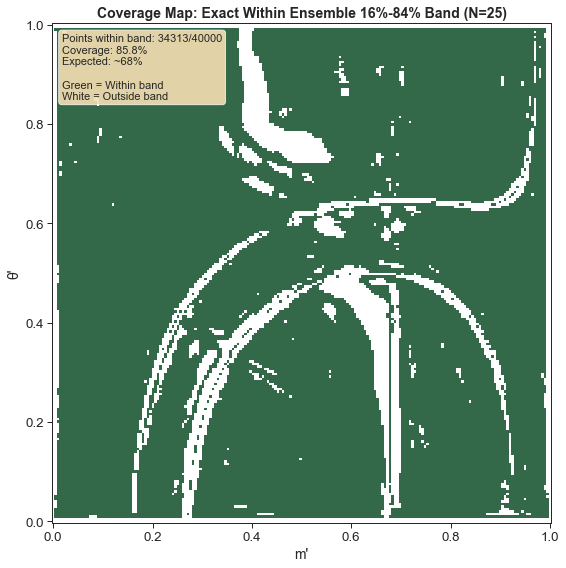


Coverage Summary:
  Coverage: 85.8% (Expected: ~68%)
  Points within band: 34313/40000
Detailed coverage plot saved to: coverage_detailed.pdf


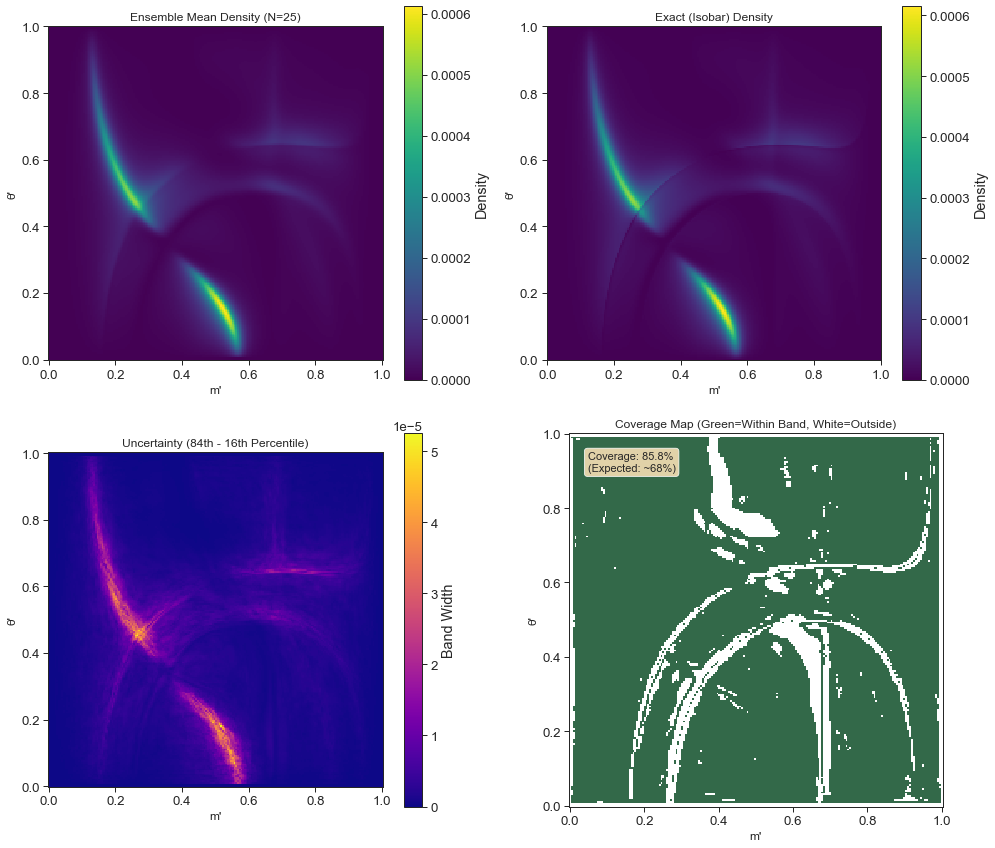


Coverage: 85.8%


In [116]:
# 4. Plot coverage maps
plot_coverage_indicator_map(U, V, density_exact, ensemble_densities, total_models)
plot_coverage_detailed(U, V, density_exact, ensemble_densities, total_models)

In [117]:
def plot_coverage_indicator_map_with_low_density(U, V, exact_density, ensemble_densities, 
                                                  num_models, threshold=0.0001,
                                                  savepath='coverage_indicator_map_red.pdf'):
    """
    Plot indicator map showing where exact density falls within ensemble 16%-84% band.
    - Green: Exact within band
    - Red: Exact outside band AND ensemble mean < threshold
    - White: Exact outside band AND ensemble mean >= threshold
    
    Parameters
    ----------
    U, V : ndarray
        Meshgrid coordinates for the Dalitz plot
    exact_density : ndarray
        Exact density from isobar model
    ensemble_densities : ndarray, shape (num_models, ny, nx)
        Densities from all ensemble models
    num_models : int
        Number of models in ensemble
    threshold : float
        Threshold for low ensemble mean density (default: 0.0001)
    savepath : str
        Path to save the figure
    """
    # Compute ensemble percentiles
    ensemble_p16 = np.percentile(ensemble_densities, 16, axis=0)
    ensemble_p84 = np.percentile(ensemble_densities, 84, axis=0)
    ensemble_mean = np.mean(ensemble_densities, axis=0)
    
    # Create indicator categories
    within_band = (exact_density >= ensemble_p16) & (exact_density <= ensemble_p84)
    outside_band = ~within_band
    low_mean = ensemble_mean < threshold
    
    # Create color map:
    # 0 = white (outside band, normal density)
    # 1 = green (within band)
    # 2 = red (outside band AND low mean)
    indicator = np.zeros_like(exact_density)
    indicator[within_band] = 1  # Green
    indicator[outside_band & low_mean] = 2  # Red
    indicator[outside_band & ~low_mean] = 0  # White (will be NaN for visualization)
    
    # For visualization: use custom colormap
    indicator_viz = indicator.copy().astype(float)
    indicator_viz[indicator == 0] = np.nan  # White for outside band with normal density
    
    # Calculate statistics
    total_points = exact_density.size
    points_in_band = np.sum(within_band)
    points_outside_low = np.sum(outside_band & low_mean)
    points_outside_normal = np.sum(outside_band & ~low_mean)
    coverage = points_in_band / total_points
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Create custom colormap: green (1) and red (2)
    from matplotlib.colors import ListedColormap, BoundaryNorm
    colors = ['white', 'green', 'red']  # 0, 1, 2
    n_bins = 3
    cmap = ListedColormap(['green', 'red'])
    bounds = [0.5, 1.5, 2.5]
    norm = BoundaryNorm(bounds, cmap.N)
    
    # Plot
    im = ax.pcolormesh(U, V, indicator_viz, cmap=cmap, norm=norm, shading='auto')
    
    ax.set_xlabel("m'", fontsize=14)
    ax.set_ylabel("θ'", fontsize=14)
    ax.set_title(f'Coverage Map with Low Density Flag (N={num_models})', 
                 fontsize=14, fontweight='bold')
    ax.set_aspect('equal')
    
    # Add text with statistics
    stats_text = f'Within band: {points_in_band}/{total_points} ({coverage:.1%})\n'
    stats_text += f'Outside (low ρ): {points_outside_low} ({points_outside_low/total_points:.1%})\n'
    stats_text += f'Outside (normal): {points_outside_normal} ({points_outside_normal/total_points:.1%})\n\n'
    stats_text += f'Green = Within 16%-84% band\n'
    stats_text += f'Red = Outside band & ρ̄ < {threshold}\n'
    stats_text += f'White = Outside band & ρ̄ ≥ {threshold}'
    
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
            verticalalignment='top', fontsize=10,
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.9))
    
    plt.tight_layout()
    plt.savefig(savepath, dpi=300, bbox_inches='tight')
    print(f"Coverage indicator map with low density flag saved to: {savepath}")
    plt.show()
    
    print(f"\nCoverage Summary:")
    print(f"  Within band: {coverage:.1%} (Expected: ~68%)")
    print(f"  Outside band with low density (ρ̄ < {threshold}): {points_outside_low/total_points:.1%}")
    print(f"  Outside band with normal density: {points_outside_normal/total_points:.1%}")
    
    return indicator, coverage


def plot_coverage_detailed_with_red(U, V, exact_density, ensemble_densities, 
                                   num_models, threshold=0.0001,
                                   savepath='coverage_detailed_red.pdf'):
    """
    Create detailed 2x2 plot with red indicator for low density regions outside band.
    
    Parameters
    ----------
    U, V : ndarray
        Meshgrid coordinates for the Dalitz plot
    exact_density : ndarray
        Exact density from isobar model
    ensemble_densities : ndarray, shape (num_models, ny, nx)
        Densities from all ensemble models
    num_models : int
        Number of models in ensemble
    threshold : float
        Threshold for low ensemble mean density
    savepath : str
        Path to save the figure
    """
    # Compute ensemble statistics
    ensemble_mean = np.mean(ensemble_densities, axis=0)
    ensemble_p16 = np.percentile(ensemble_densities, 16, axis=0)
    ensemble_p84 = np.percentile(ensemble_densities, 84, axis=0)
    band_width = ensemble_p84 - ensemble_p16
    
    # Coverage indicator with categories
    within_band = (exact_density >= ensemble_p16) & (exact_density <= ensemble_p84)
    outside_band = ~within_band
    low_mean = ensemble_mean < threshold
    
    indicator = np.zeros_like(exact_density)
    indicator[within_band] = 1  # Green
    indicator[outside_band & low_mean] = 2  # Red
    indicator_viz = indicator.copy().astype(float)
    indicator_viz[indicator == 0] = np.nan  # White
    
    coverage = np.mean(within_band)
    points_outside_low = np.sum(outside_band & low_mean)
    
    # Create 2x2 plot
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    
    # Top left: Ensemble mean
    im0 = axes[0, 0].pcolormesh(U, V, ensemble_mean, cmap='viridis', shading='auto')
    axes[0, 0].set_xlabel("m'", fontsize=12)
    axes[0, 0].set_ylabel("θ'", fontsize=12)
    axes[0, 0].set_title(f'Ensemble Mean Density (N={num_models})', fontsize=12)
    axes[0, 0].set_aspect('equal')
    plt.colorbar(im0, ax=axes[0, 0], label='Density')
    
    # Top right: Exact density
    im1 = axes[0, 1].pcolormesh(U, V, exact_density, cmap='viridis', shading='auto')
    axes[0, 1].set_xlabel("m'", fontsize=12)
    axes[0, 1].set_ylabel("θ'", fontsize=12)
    axes[0, 1].set_title('Exact (Isobar) Density', fontsize=12)
    axes[0, 1].set_aspect('equal')
    plt.colorbar(im1, ax=axes[0, 1], label='Density')
    
    # Bottom left: Band width (84% - 16%)
    im2 = axes[1, 0].pcolormesh(U, V, band_width, cmap='plasma', shading='auto')
    axes[1, 0].set_xlabel("m'", fontsize=12)
    axes[1, 0].set_ylabel("θ'", fontsize=12)
    axes[1, 0].set_title('Uncertainty (84th - 16th Percentile)', fontsize=12)
    axes[1, 0].set_aspect('equal')
    plt.colorbar(im2, ax=axes[1, 0], label='Band Width')
    
    # Bottom right: Coverage indicator with red
    from matplotlib.colors import ListedColormap, BoundaryNorm
    cmap = ListedColormap(['green', 'red'])
    bounds = [0.5, 1.5, 2.5]
    norm = BoundaryNorm(bounds, cmap.N)
    
    im3 = axes[1, 1].pcolormesh(U, V, indicator_viz, cmap=cmap, norm=norm, shading='auto')
    axes[1, 1].set_xlabel("m'", fontsize=12)
    axes[1, 1].set_ylabel("θ'", fontsize=12)
    axes[1, 1].set_title(f'Coverage Map (Green/Red/White)', fontsize=12)
    axes[1, 1].set_aspect('equal')
    
    # Add coverage text
    stats_text = f'Coverage: {coverage:.1%}\n'
    stats_text += f'Outside (low ρ): {points_outside_low/exact_density.size:.1%}\n\n'
    stats_text += f'Green: Within band\n'
    stats_text += f'Red: Outside & ρ̄<{threshold}\n'
    stats_text += f'White: Outside & ρ̄≥{threshold}'
    
    axes[1, 1].text(0.05, 0.95, stats_text, 
                    transform=axes[1, 1].transAxes,
                    verticalalignment='top', fontsize=10,
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.9))
    
    plt.tight_layout()
    plt.savefig(savepath, dpi=300, bbox_inches='tight')
    print(f"Detailed coverage plot with red flag saved to: {savepath}")
    plt.show()
    
    print(f"\nCoverage: {coverage:.1%}")
    print(f"Outside band with low density: {points_outside_low/exact_density.size:.1%}")


Coverage indicator map with low density flag saved to: coverage_indicator_map_red.pdf


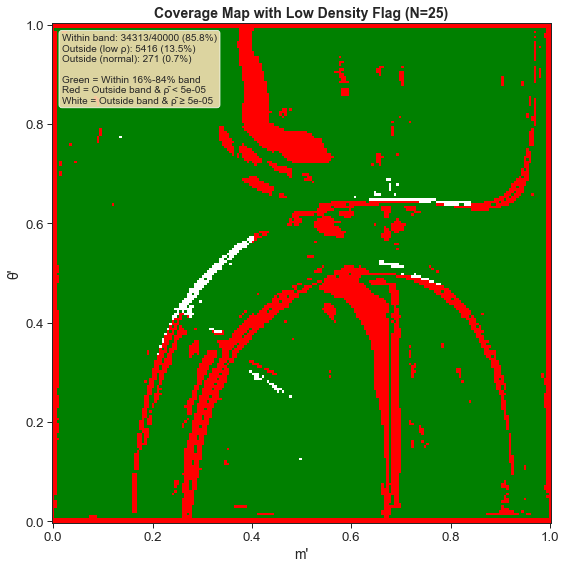


Coverage Summary:
  Within band: 85.8% (Expected: ~68%)
  Outside band with low density (ρ̄ < 5e-05): 13.5%
  Outside band with normal density: 0.7%
Detailed coverage plot with red flag saved to: coverage_detailed_red.pdf


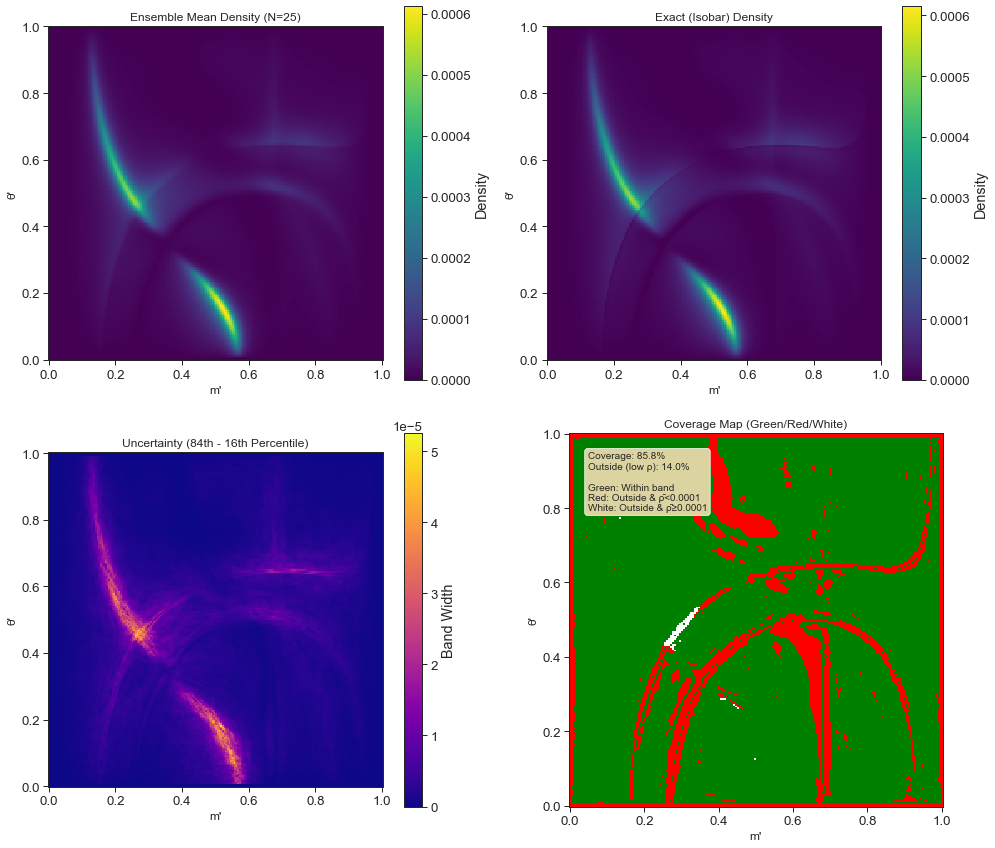


Coverage: 85.8%
Outside band with low density: 14.0%


In [119]:
# Example usage:
plot_coverage_indicator_map_with_low_density(U, V, density_exact, ensemble_densities, 
                                             total_models, threshold=0.00005)
plot_coverage_detailed_with_red(U, V, density_exact, ensemble_densities, 
                               total_models, threshold=0.0001)

COMBINED MULTI-ENSEMBLE PULL MAP ANALYSIS

Found 2 ensemble(s) to combine: ['test_ensemble', 'test_ensemble2']

Computing exact density from isobar model...


/Users/san/opt/anaconda3/lib/python3.9/site-packages/nflows/transforms/coupling.py:561: UserWarning: Inputs to the softmax are not scaled down: initialization might be bad.
  warnings.warn(
/Users/san/Library/CloudStorage/OneDrive-CornellUniversity/Documents/GitHub/Gamma_Extraction/Amplitude.py:487: RuntimeWarning: divide by zero encountered in scalar divide
  dmp_dsij = -(1.0 / np.pi) * (1.0 / np.sqrt(one_minus_x2)) * (1.0 / (denom_m * np.sqrt(mijSq)))
/Users/san/Library/CloudStorage/OneDrive-CornellUniversity/Documents/GitHub/Gamma_Extraction/Amplitude.py:426: RuntimeWarning: divide by zero encountered in scalar divide
  cosHel = -(mikSq - self.mSq[i] - self.mSq[k] - 2.0 * EiCmsij * EkCmsij) / (2.0 * self.qi * self.qk)



LOADING AND COMBINING ENSEMBLES
Combining models from 2 ensemble(s): ['test_ensemble', 'test_ensemble2']

  Loading from test_ensemble...
    Found 5 models
      Processing model 1/5...
      Processing model 2/5...
      Processing model 3/5...
      Processing model 4/5...
      Processing model 5/5...

  Loading from test_ensemble2...
    Found 20 models
      Processing model 1/20...
      Processing model 2/20...
      Processing model 3/20...
      Processing model 4/20...
      Processing model 5/20...
      Processing model 6/20...
      Processing model 7/20...
      Processing model 8/20...
      Processing model 9/20...
      Processing model 10/20...
      Processing model 11/20...
      Processing model 12/20...
      Processing model 13/20...
      Processing model 14/20...
      Processing model 15/20...
      Processing model 16/20...
      Processing model 17/20...
      Processing model 18/20...
      Processing model 19/20...
      Processing model 20/20...

  Tota

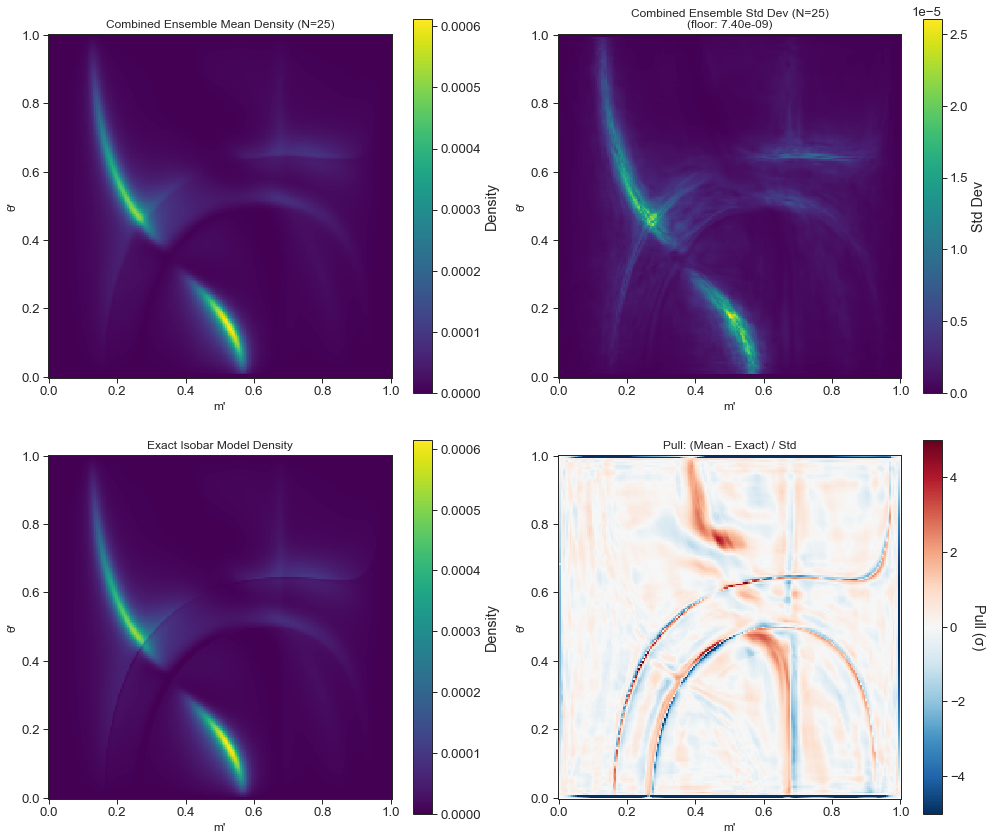


Pull map saved to: ensemble_pull_map_combined_2.pdf

PULL DISTRIBUTION ANALYSIS


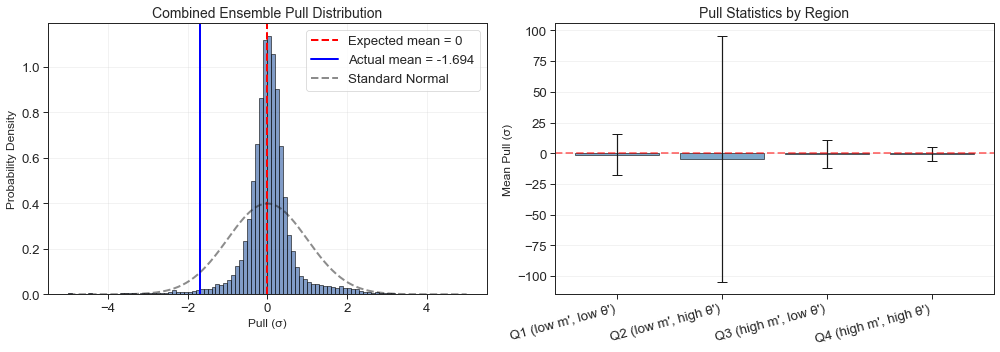


Pull distribution plot saved to: pull_distribution_combined_2.pdf

Pull Distribution Statistics:
  Sample size: 40,000 grid points
  Mean: -1.6941 (should be ~0)
  Std:  51.2384 (should be ~1)
  Median: 0.0329
  2.5%:  -2.40 (expected: -1.96)
  97.5%: 1.69 (expected: +1.96)
  Fraction outside ±2σ: 4.56% (expected: ~5%)
  Fraction outside ±3σ: 2.45% (expected: ~0.3%)

COMBINED ANALYSIS COMPLETE
Combined 25 models from 2 ensemble(s)
Generated files:
  - ensemble_pull_map_combined_2.pdf
  - pull_distribution_combined_2.pdf


In [85]:
# ============================================================================
# COMBINED MULTI-ENSEMBLE PULL MAP ANALYSIS
# ============================================================================
# This cell combines models from multiple ensemble directories into one
# larger ensemble for analysis. Easily reusable for any combination.

def load_combined_ensemble_densities(ensemble_dirs, pts, grid_shape, num_flows=16, 
                                     hidden_features=128, num_bins=16, device='cpu'):
    """
    Load and combine models from multiple ensemble directories into one ensemble.
    
    Parameters
    ----------
    ensemble_dirs : str or list of str
        Single ensemble directory or list of ensemble directories to combine
        Examples: "test_ensemble" or ["test_ensemble", "test_ensemble2_odd"]
    pts : ndarray, shape (N, 2)
        Grid points in SDP coordinates
    grid_shape : tuple
        Shape of grid (ny, nx) for reshaping
    num_flows, hidden_features, num_bins : int
        Flow architecture parameters
    device : str
        Device for computation
    
    Returns
    -------
    ensemble_densities : ndarray, shape (total_models, ny, nx)
        Combined normalized densities from all models in all ensembles
    total_models : int
        Total number of models loaded
    ensemble_info : dict
        Information about which models came from which ensemble
    """
    from pathlib import Path
    import glob
    
    # Make ensemble_dirs a list if it's a single string
    if isinstance(ensemble_dirs, str):
        ensemble_dirs = [ensemble_dirs]
    
    print(f"Combining models from {len(ensemble_dirs)} ensemble(s): {ensemble_dirs}")
    
    all_densities = []
    ensemble_info = {'ensemble_dirs': ensemble_dirs, 'models_per_ensemble': []}
    
    for ens_idx, ensemble_dir in enumerate(ensemble_dirs, 1):
        print(f"\n  Loading from {ensemble_dir}...")
        
        # Find all model files in this ensemble
        model_files = sorted(glob.glob(f"{ensemble_dir}/trial_seed*.pth"))
        model_files = [f for f in model_files if not f.endswith('_best.pth')]
        num_models_this_ensemble = len(model_files)
        
        if num_models_this_ensemble == 0:
            print(f"    WARNING: No models found in {ensemble_dir}, skipping")
            continue
        
        print(f"    Found {num_models_this_ensemble} models")
        ensemble_info['models_per_ensemble'].append({
            'dir': ensemble_dir,
            'num_models': num_models_this_ensemble
        })
        
        for model_idx, model_path in enumerate(model_files, 1):
            print(f"      Processing model {model_idx}/{num_models_this_ensemble}...")
            
            # Load model
            model_flow = create_flow(num_flows=num_flows, hidden_features=hidden_features, 
                                     num_bins=num_bins)
            model_flow.load_state_dict(torch.load(model_path, map_location=device))
            model_flow.eval()
            model_flow.to(device)
            
            # Compute density
            with torch.no_grad():
                pts_tensor = torch.from_numpy(pts.astype(np.float32)).to(device)
                batch_size = 10000
                log_probs = []
                for i in range(0, len(pts_tensor), batch_size):
                    batch = pts_tensor[i:i+batch_size]
                    log_probs.append(model_flow.log_prob(batch).cpu().numpy())
                log_prob = np.concatenate(log_probs)
            
            density = np.exp(log_prob).reshape(grid_shape)
            density_norm = density / density.sum()  # Normalize
            all_densities.append(density_norm)
    
    if len(all_densities) == 0:
        raise ValueError("No models loaded from any ensemble!")
    
    total_models = len(all_densities)
    print(f"\n  Total models combined: {total_models}")
    
    return np.array(all_densities), total_models, ensemble_info


def compute_pull_map_combined(ensemble_mean, ensemble_std, exact_density, sigma_floor=None):
    """
    Compute pull map: (ensemble_mean - exact) / ensemble_std
    
    Parameters
    ----------
    ensemble_mean : ndarray
        Mean density from ensemble
    ensemble_std : ndarray
        Standard deviation from ensemble
    exact_density : ndarray
        Exact density from isobar model
    sigma_floor : float, optional
        Minimum allowed value for ensemble_std. If None, automatically set to
        a small fraction of the median std (default: 1% of median std).
    
    Returns
    -------
    pull : ndarray
        Pull values everywhere
    sigma_floor_used : float
        The actual sigma floor that was applied
    """
    # Set sigma floor: prevent unrealistically small variance
    if sigma_floor is None:
        # Auto-set floor to 1% of median std (reasonable default)
        sigma_floor = 0.01 * np.median(ensemble_std[ensemble_std > 0])
        print(f"  Auto-setting sigma floor: {sigma_floor:.6e} (1% of median std)")
    
    # Apply floor to ensemble std
    ensemble_std_floored = np.maximum(ensemble_std, sigma_floor)
    
    # Compute pull with floored sigma everywhere
    pull = (ensemble_mean - exact_density) / ensemble_std_floored

    return pull, sigma_floor


def plot_combined_pull_map(U, V, ensemble_mean, ensemble_std, exact_density, pull, 
                           num_models, sigma_floor=None, savepath='ensemble_pull_map_combined.pdf'):
    """
    Create 2x2 plot showing ensemble mean, std, exact density, and pull map.
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    
    # Top left: Ensemble mean
    im0 = axes[0, 0].pcolormesh(U, V, ensemble_mean, cmap='viridis', shading='auto')
    axes[0, 0].set_xlabel("m'", fontsize=12)
    axes[0, 0].set_ylabel("θ'", fontsize=12)
    axes[0, 0].set_title(f'Combined Ensemble Mean Density (N={num_models})', fontsize=12)
    axes[0, 0].set_aspect('equal')
    plt.colorbar(im0, ax=axes[0, 0], label='Density')
    
    # Top right: Ensemble std
    im1 = axes[0, 1].pcolormesh(U, V, ensemble_std, cmap='viridis', shading='auto')
    axes[0, 1].set_xlabel("m'", fontsize=12)
    axes[0, 1].set_ylabel("θ'", fontsize=12)
    title_std = f'Combined Ensemble Std Dev (N={num_models})'
    if sigma_floor is not None:
        title_std += f'\n(floor: {sigma_floor:.2e})'
    axes[0, 1].set_title(title_std, fontsize=12)
    axes[0, 1].set_aspect('equal')
    plt.colorbar(im1, ax=axes[0, 1], label='Std Dev')
    
    # Bottom left: Exact density
    im2 = axes[1, 0].pcolormesh(U, V, exact_density, cmap='viridis', shading='auto')
    axes[1, 0].set_xlabel("m'", fontsize=12)
    axes[1, 0].set_ylabel("θ'", fontsize=12)
    axes[1, 0].set_title('Exact Isobar Model Density', fontsize=12)
    axes[1, 0].set_aspect('equal')
    plt.colorbar(im2, ax=axes[1, 0], label='Density')
    
    # Bottom right: Pull map
    # Clip to ±5 sigma for visualization
    pull_clipped = np.clip(pull, -5, 5)
    im3 = axes[1, 1].pcolormesh(U, V, pull_clipped, cmap='RdBu_r', shading='auto',
                                vmin=-5, vmax=5)
    axes[1, 1].set_xlabel("m'", fontsize=12)
    axes[1, 1].set_ylabel("θ'", fontsize=12)
    axes[1, 1].set_title('Pull: (Mean - Exact) / Std', fontsize=12)
    axes[1, 1].set_aspect('equal')
    cbar = plt.colorbar(im3, ax=axes[1, 1], label='Pull (σ)')
    cbar.set_label('Pull (σ)', rotation=270, labelpad=20)
    
    plt.tight_layout()
    plt.savefig(savepath, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\nPull map saved to: {savepath}")


def plot_combined_pull_distribution(pull, U, savepath='pull_distribution_combined.pdf'):
    """
    Plot pull distribution histogram and regional statistics.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Left: Pull histogram
    pull_flat = pull.ravel()
    pull_flat = pull_flat[np.isfinite(pull_flat)]  # Remove NaN/inf values
    
    axes[0].hist(pull_flat, bins=100, range=(-5, 5), alpha=0.7, edgecolor='black', density=True)
    axes[0].axvline(0, color='red', linestyle='--', linewidth=2, label='Expected mean = 0')
    axes[0].axvline(pull_flat.mean(), color='blue', linestyle='-', linewidth=2, 
                    label=f'Actual mean = {pull_flat.mean():.3f}')
    
    # Add Gaussian reference
    x_gauss = np.linspace(-5, 5, 200)
    y_gauss = (1/np.sqrt(2*np.pi)) * np.exp(-0.5 * x_gauss**2)
    axes[0].plot(x_gauss, y_gauss, 'k--', linewidth=2, alpha=0.5, label='Standard Normal')
    
    axes[0].set_xlabel('Pull (σ)', fontsize=12)
    axes[0].set_ylabel('Probability Density', fontsize=12)
    axes[0].set_title('Combined Ensemble Pull Distribution', fontsize=14)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Right: Pull statistics by region
    # Divide SDP into quadrants
    mid_x = U.shape[1] // 2
    mid_y = U.shape[0] // 2
    
    quadrants = {
        'Q1 (low m\', low θ\')': pull[:mid_y, :mid_x],
        'Q2 (low m\', high θ\')': pull[:mid_y, mid_x:],
        'Q3 (high m\', low θ\')': pull[mid_y:, :mid_x],
        'Q4 (high m\', high θ\')': pull[mid_y:, mid_x:]
    }
    
    quad_means = []
    quad_stds = []
    quad_labels = []
    
    for label, quad_pull in quadrants.items():
        quad_flat = quad_pull.ravel()
        quad_flat = quad_flat[np.isfinite(quad_flat)]
        if len(quad_flat) > 0:
            quad_means.append(quad_flat.mean())
            quad_stds.append(quad_flat.std())
            quad_labels.append(label)
        else:
            quad_means.append(0)
            quad_stds.append(0)
            quad_labels.append(label)
    
    x_pos = np.arange(len(quad_labels))
    axes[1].bar(x_pos, quad_means, yerr=quad_stds, capsize=5, alpha=0.7, 
                edgecolor='black', color='steelblue')
    axes[1].axhline(0, color='red', linestyle='--', linewidth=2, alpha=0.5)
    axes[1].set_xticks(x_pos)
    axes[1].set_xticklabels(quad_labels, rotation=15, ha='right')
    axes[1].set_ylabel('Mean Pull (σ)', fontsize=12)
    axes[1].set_title('Pull Statistics by Region', fontsize=14)
    axes[1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig(savepath, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\nPull distribution plot saved to: {savepath}")
    
    return pull_flat


# ============================================================================
# EXAMPLE USAGE: Combine multiple ensembles and analyze as one
# ============================================================================

print("="*80)
print("COMBINED MULTI-ENSEMBLE PULL MAP ANALYSIS")
print("="*80)

# List all ensembles to combine into one large ensemble
# Add more as you train them: ["test_ensemble", "test_ensemble2_odd", "test_ensemble3", ...]
ensemble_list = ["test_ensemble", "test_ensemble2_odd"]

# Filter to only existing directories
import os
existing_ensembles = [e for e in ensemble_list if os.path.exists(e)]

if not existing_ensembles:
    print("\nNo ensembles found! Available ensembles will be analyzed when they exist.")
    print(f"Looking for: {ensemble_list}")
else:
    print(f"\nFound {len(existing_ensembles)} ensemble(s) to combine: {existing_ensembles}")
    
    # Configuration
    grid_nx, grid_ny = 200, 200
    sigma_floor = None  # Auto-set to 1% of median std
    
    # Create grid
    U, V, pts = make_sdp_grid(nx=grid_nx, ny=grid_ny)
    grid_shape = (grid_ny, grid_nx)
    
    # Compute exact density from isobar model
    print("\nComputing exact density from isobar model...")
    dkpp_model = DKpp()
    density_exact = compute_mag_exact(pts, SDP, flow, dkpp_model, device=device).reshape(grid_shape)
    density_exact_norm = density_exact / density_exact.sum()
    
    # Load and combine all ensembles into one
    print("\n" + "="*80)
    print("LOADING AND COMBINING ENSEMBLES")
    print("="*80)
    ensemble_densities, num_models, ensemble_info = load_combined_ensemble_densities(
        existing_ensembles, pts, grid_shape, 
        num_flows=16, hidden_features=128, num_bins=16, device=device
    )
    
    # Compute ensemble statistics (treating all models as one ensemble)
    print("\n" + "="*80)
    print("COMPUTING COMBINED ENSEMBLE STATISTICS")
    print("="*80)
    ensemble_mean = np.mean(ensemble_densities, axis=0)
    ensemble_std = np.std(ensemble_densities, axis=0, ddof=1)  # Sample std
    
    # Compute pull with sigma floor
    pull, sigma_floor_used = compute_pull_map_combined(ensemble_mean, ensemble_std, 
                                                       density_exact_norm, sigma_floor=sigma_floor)
    
    # Print statistics
    print(f"\nCombined Ensemble Statistics:")
    print(f"  Ensembles combined: {existing_ensembles}")
    for info in ensemble_info['models_per_ensemble']:
        print(f"    - {info['dir']}: {info['num_models']} models")
    print(f"  Total models: {num_models}")
    print(f"  Mean density - Min: {ensemble_mean.min():.6e}, Max: {ensemble_mean.max():.6e}")
    print(f"  Std density  - Min: {ensemble_std.min():.6e}, Max: {ensemble_std.max():.6e}")
    print(f"  Sigma floor used: {sigma_floor_used:.6e}")
    print(f"  Pull - Min: {pull.min():.2f}, Max: {pull.max():.2f}, Mean: {pull.mean():.2f}")
    print(f"  Pull std dev: {pull.std():.2f}")
    
    # Plot combined pull map
    print("\n" + "="*80)
    print("CREATING PULL MAP")
    print("="*80)
    
    plot_combined_pull_map(U, V, ensemble_mean, ensemble_std, density_exact_norm, pull, 
                          num_models, sigma_floor=sigma_floor_used, 
                          savepath=f'ensemble_pull_map_combined_{len(existing_ensembles)}.pdf')
    
    # Plot pull distribution
    print("\n" + "="*80)
    print("PULL DISTRIBUTION ANALYSIS")
    print("="*80)
    
    pull_flat = plot_combined_pull_distribution(pull, U, 
                                                savepath=f'pull_distribution_combined_{len(existing_ensembles)}.pdf')
    
    # Print detailed statistics
    print(f"\nPull Distribution Statistics:")
    print(f"  Sample size: {len(pull_flat):,} grid points")
    print(f"  Mean: {pull_flat.mean():.4f} (should be ~0)")
    print(f"  Std:  {pull_flat.std():.4f} (should be ~1)")
    print(f"  Median: {np.median(pull_flat):.4f}")
    print(f"  2.5%:  {np.percentile(pull_flat, 2.5):.2f} (expected: -1.96)")
    print(f"  97.5%: {np.percentile(pull_flat, 97.5):.2f} (expected: +1.96)")
    print(f"  Fraction outside ±2σ: {np.sum(np.abs(pull_flat) > 2) / len(pull_flat) * 100:.2f}% (expected: ~5%)")
    print(f"  Fraction outside ±3σ: {np.sum(np.abs(pull_flat) > 3) / len(pull_flat) * 100:.2f}% (expected: ~0.3%)")
    
    print("\n" + "="*80)
    print("COMBINED ANALYSIS COMPLETE")
    print("="*80)
    print(f"Combined {num_models} models from {len(existing_ensembles)} ensemble(s)")
    print("Generated files:")
    print(f"  - ensemble_pull_map_combined_{len(existing_ensembles)}.pdf")
    print(f"  - pull_distribution_combined_{len(existing_ensembles)}.pdf")

In [68]:
# ============================================================================
# COMBINED MULTI-ENSEMBLE PULL MAP ANALYSIS
# ============================================================================
# This cell combines models from multiple ensemble directories into one
# larger ensemble for analysis. Easily reusable for any combination.

def load_combined_ensemble_densities(ensemble_dirs, pts, grid_shape, num_flows=16, 
                                     hidden_features=128, num_bins=16, device='cpu'):
    """
    Load and combine models from multiple ensemble directories into one ensemble.
    
    Parameters
    ----------
    ensemble_dirs : str or list of str
        Single ensemble directory or list of ensemble directories to combine
        Examples: "test_ensemble" or ["test_ensemble", "test_ensemble2_odd"]
    pts : ndarray, shape (N, 2)
        Grid points in SDP coordinates
    grid_shape : tuple
        Shape of grid (ny, nx) for reshaping
    num_flows, hidden_features, num_bins : int
        Flow architecture parameters
    device : str
        Device for computation
    
    Returns
    -------
    ensemble_densities : ndarray, shape (total_models, ny, nx)
        Combined normalized densities from all models in all ensembles
    total_models : int
        Total number of models loaded
    ensemble_info : dict
        Information about which models came from which ensemble
    """
    from pathlib import Path
    import glob
    
    # Make ensemble_dirs a list if it's a single string
    if isinstance(ensemble_dirs, str):
        ensemble_dirs = [ensemble_dirs]
    
    print(f"Combining models from {len(ensemble_dirs)} ensemble(s): {ensemble_dirs}")
    
    all_densities = []
    ensemble_info = {'ensemble_dirs': ensemble_dirs, 'models_per_ensemble': []}
    
    for ens_idx, ensemble_dir in enumerate(ensemble_dirs, 1):
        print(f"\n  Loading from {ensemble_dir}...")
        
        # Find all model files in this ensemble
        model_files = sorted(glob.glob(f"{ensemble_dir}/trial_seed*.pth"))
        model_files = [f for f in model_files if not f.endswith('_best.pth')]
        num_models_this_ensemble = len(model_files)
        
        if num_models_this_ensemble == 0:
            print(f"    WARNING: No models found in {ensemble_dir}, skipping")
            continue
        
        print(f"    Found {num_models_this_ensemble} models")
        ensemble_info['models_per_ensemble'].append({
            'dir': ensemble_dir,
            'num_models': num_models_this_ensemble
        })
        
        for model_idx, model_path in enumerate(model_files, 1):
            print(f"      Processing model {model_idx}/{num_models_this_ensemble}...")
            
            # Load model
            model_flow = create_flow(num_flows=num_flows, hidden_features=hidden_features, 
                                     num_bins=num_bins)
            model_flow.load_state_dict(torch.load(model_path, map_location=device))
            model_flow.eval()
            model_flow.to(device)
            
            # Compute density
            with torch.no_grad():
                pts_tensor = torch.from_numpy(pts.astype(np.float32)).to(device)
                batch_size = 10000
                log_probs = []
                for i in range(0, len(pts_tensor), batch_size):
                    batch = pts_tensor[i:i+batch_size]
                    log_probs.append(model_flow.log_prob(batch).cpu().numpy())
                log_prob = np.concatenate(log_probs)
            
            density = np.exp(log_prob).reshape(grid_shape)
            density_norm = density / density.sum()  # Normalize
            all_densities.append(density_norm)
    
    if len(all_densities) == 0:
        raise ValueError("No models loaded from any ensemble!")
    
    total_models = len(all_densities)
    print(f"\n  Total models combined: {total_models}")
    
    return np.array(all_densities), total_models, ensemble_info


def compute_pull_map_combined(ensemble_mean, ensemble_std, exact_density, sigma_floor=None):
    """
    Compute pull map: (ensemble_mean - exact) / ensemble_std
    
    Parameters
    ----------
    ensemble_mean : ndarray
        Mean density from ensemble
    ensemble_std : ndarray
        Standard deviation from ensemble
    exact_density : ndarray
        Exact density from isobar model
    sigma_floor : float, optional
        Minimum allowed value for ensemble_std. If None, automatically set to
        a small fraction of the median std (default: 1% of median std).
    
    Returns
    -------
    pull : ndarray
        Pull values everywhere
    sigma_floor_used : float
        The actual sigma floor that was applied
    """
    # Set sigma floor: prevent unrealistically small variance
    if sigma_floor is None:
        # Auto-set floor to 1% of median std (reasonable default)
        sigma_floor = 0.01 * np.median(ensemble_std[ensemble_std > 0])
        print(f"  Auto-setting sigma floor: {sigma_floor:.6e} (1% of median std)")
    
    # Apply floor to ensemble std
    ensemble_std_floored = np.maximum(ensemble_std, sigma_floor)

    # Compute pull, handling zero exact_density values
    # pull = np.where(exact_density < 0.00001, 0, (ensemble_mean - exact_density) / ensemble_std_floored)  
    pull = (ensemble_mean - exact_density) / ensemble_std_floored
    return pull, sigma_floor


def plot_combined_pull_map(U, V, ensemble_mean, ensemble_std, exact_density, pull, 
                           num_models, sigma_floor=None, savepath='ensemble_pull_map_combined.pdf'):
    """
    Create 2x2 plot showing ensemble mean, std, exact density, and pull map.
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    
    # Top left: Ensemble mean
    im0 = axes[0, 0].pcolormesh(U, V, ensemble_mean, cmap='viridis', shading='auto')
    axes[0, 0].set_xlabel("m'", fontsize=12)
    axes[0, 0].set_ylabel("θ'", fontsize=12)
    axes[0, 0].set_title(f'Combined Ensemble Mean Density (N={num_models})', fontsize=12)
    axes[0, 0].set_aspect('equal')
    plt.colorbar(im0, ax=axes[0, 0], label='Density')
    
    # Top right: Ensemble std
    im1 = axes[0, 1].pcolormesh(U, V, ensemble_std, cmap='viridis', shading='auto')
    axes[0, 1].set_xlabel("m'", fontsize=12)
    axes[0, 1].set_ylabel("θ'", fontsize=12)
    title_std = f'Combined Ensemble Std Dev (N={num_models})'
    if sigma_floor is not None:
        title_std += f'\n(floor: {sigma_floor:.2e})'
    axes[0, 1].set_title(title_std, fontsize=12)
    axes[0, 1].set_aspect('equal')
    plt.colorbar(im1, ax=axes[0, 1], label='Std Dev')
    
    # Bottom left: Exact density
    im2 = axes[1, 0].pcolormesh(U, V, exact_density, cmap='viridis', shading='auto')
    axes[1, 0].set_xlabel("m'", fontsize=12)
    axes[1, 0].set_ylabel("θ'", fontsize=12)
    axes[1, 0].set_title('Exact Isobar Model Density', fontsize=12)
    axes[1, 0].set_aspect('equal')
    plt.colorbar(im2, ax=axes[1, 0], label='Density')
    
    # Bottom right: Pull map
    # Clip to ±5 sigma for visualization
    pull_clipped = np.clip(pull, -5, 5)
    im3 = axes[1, 1].pcolormesh(U, V, pull_clipped, cmap='RdBu_r', shading='auto',
                                vmin=-5, vmax=5)
    axes[1, 1].set_xlabel("m'", fontsize=12)
    axes[1, 1].set_ylabel("θ'", fontsize=12)
    axes[1, 1].set_title('Pull: (Mean - Exact) / Std', fontsize=12)
    axes[1, 1].set_aspect('equal')
    cbar = plt.colorbar(im3, ax=axes[1, 1], label='Pull (σ)')
    cbar.set_label('Pull (σ)', rotation=270, labelpad=20)
    
    plt.tight_layout()
    plt.savefig(savepath, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\nPull map saved to: {savepath}")


def plot_combined_pull_distribution(pull, U, savepath='pull_distribution_combined.pdf'):
    """
    Plot pull distribution histogram and regional statistics.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Left: Pull histogram
    pull_flat = pull.ravel()
    pull_flat = pull_flat[np.isfinite(pull_flat)]  # Remove NaN/inf values
    
    axes[0].hist(pull_flat, bins=100, range=(-5, 5), alpha=0.7, edgecolor='black', density=True)
    axes[0].axvline(0, color='red', linestyle='--', linewidth=2, label='Expected mean = 0')
    axes[0].axvline(pull_flat.mean(), color='blue', linestyle='-', linewidth=2, 
                    label=f'Actual mean = {pull_flat.mean():.3f}')
    
    # Add Gaussian reference
    x_gauss = np.linspace(-5, 5, 200)
    y_gauss = (1/np.sqrt(2*np.pi)) * np.exp(-0.5 * x_gauss**2)
    axes[0].plot(x_gauss, y_gauss, 'k--', linewidth=2, alpha=0.5, label='Standard Normal')
    
    axes[0].set_xlabel('Pull (σ)', fontsize=12)
    axes[0].set_ylabel('Probability Density', fontsize=12)
    axes[0].set_title('Combined Ensemble Pull Distribution', fontsize=14)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Right: Pull statistics by region
    # Divide SDP into quadrants
    mid_x = U.shape[1] // 2
    mid_y = U.shape[0] // 2
    
    quadrants = {
        'Q1 (low m\', low θ\')': pull[:mid_y, :mid_x],
        'Q2 (low m\', high θ\')': pull[:mid_y, mid_x:],
        'Q3 (high m\', low θ\')': pull[mid_y:, :mid_x],
        'Q4 (high m\', high θ\')': pull[mid_y:, mid_x:]
    }
    
    quad_means = []
    quad_stds = []
    quad_labels = []
    
    for label, quad_pull in quadrants.items():
        quad_flat = quad_pull.ravel()
        quad_flat = quad_flat[np.isfinite(quad_flat)]
        if len(quad_flat) > 0:
            quad_means.append(quad_flat.mean())
            quad_stds.append(quad_flat.std())
            quad_labels.append(label)
        else:
            quad_means.append(0)
            quad_stds.append(0)
            quad_labels.append(label)
    
    x_pos = np.arange(len(quad_labels))
    axes[1].bar(x_pos, quad_means, yerr=quad_stds, capsize=5, alpha=0.7, 
                edgecolor='black', color='steelblue')
    axes[1].axhline(0, color='red', linestyle='--', linewidth=2, alpha=0.5)
    axes[1].set_xticks(x_pos)
    axes[1].set_xticklabels(quad_labels, rotation=15, ha='right')
    axes[1].set_ylabel('Mean Pull (σ)', fontsize=12)
    axes[1].set_title('Pull Statistics by Region', fontsize=14)
    axes[1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig(savepath, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\nPull distribution plot saved to: {savepath}")
    
    return pull_flat


COMBINED MULTI-ENSEMBLE PULL MAP ANALYSIS

Found 1 ensemble(s) to combine: ['test_ensemble']

Computing exact density from isobar model...


/Users/san/opt/anaconda3/lib/python3.9/site-packages/nflows/transforms/coupling.py:561: UserWarning: Inputs to the softmax are not scaled down: initialization might be bad.
  warnings.warn(
/Users/san/Library/CloudStorage/OneDrive-CornellUniversity/Documents/GitHub/Gamma_Extraction/Amplitude.py:487: RuntimeWarning: divide by zero encountered in scalar divide
  dmp_dsij = -(1.0 / np.pi) * (1.0 / np.sqrt(one_minus_x2)) * (1.0 / (denom_m * np.sqrt(mijSq)))
/Users/san/Library/CloudStorage/OneDrive-CornellUniversity/Documents/GitHub/Gamma_Extraction/Amplitude.py:426: RuntimeWarning: divide by zero encountered in scalar divide
  cosHel = -(mikSq - self.mSq[i] - self.mSq[k] - 2.0 * EiCmsij * EkCmsij) / (2.0 * self.qi * self.qk)



LOADING AND COMBINING ENSEMBLES
Combining models from 1 ensemble(s): ['test_ensemble']

  Loading from test_ensemble...
    Found 5 models
      Processing model 1/5...
      Processing model 2/5...
      Processing model 3/5...
      Processing model 4/5...
      Processing model 5/5...

  Total models combined: 5

COMPUTING COMBINED ENSEMBLE STATISTICS
  Auto-setting sigma floor: 6.757220e-09 (1% of median std)

Combined Ensemble Statistics:
  Ensembles combined: ['test_ensemble']
    - test_ensemble: 5 models
  Total models: 5
  Mean density - Min: 0.000000e+00, Max: 6.090658e-04
  Std density  - Min: 0.000000e+00, Max: 2.865170e-05
  Sigma floor used: 6.757220e-09
  Pull - Min: -4611.65, Max: 35.07, Mean: -1.88
  Pull std dev: 56.12

CREATING PULL MAP


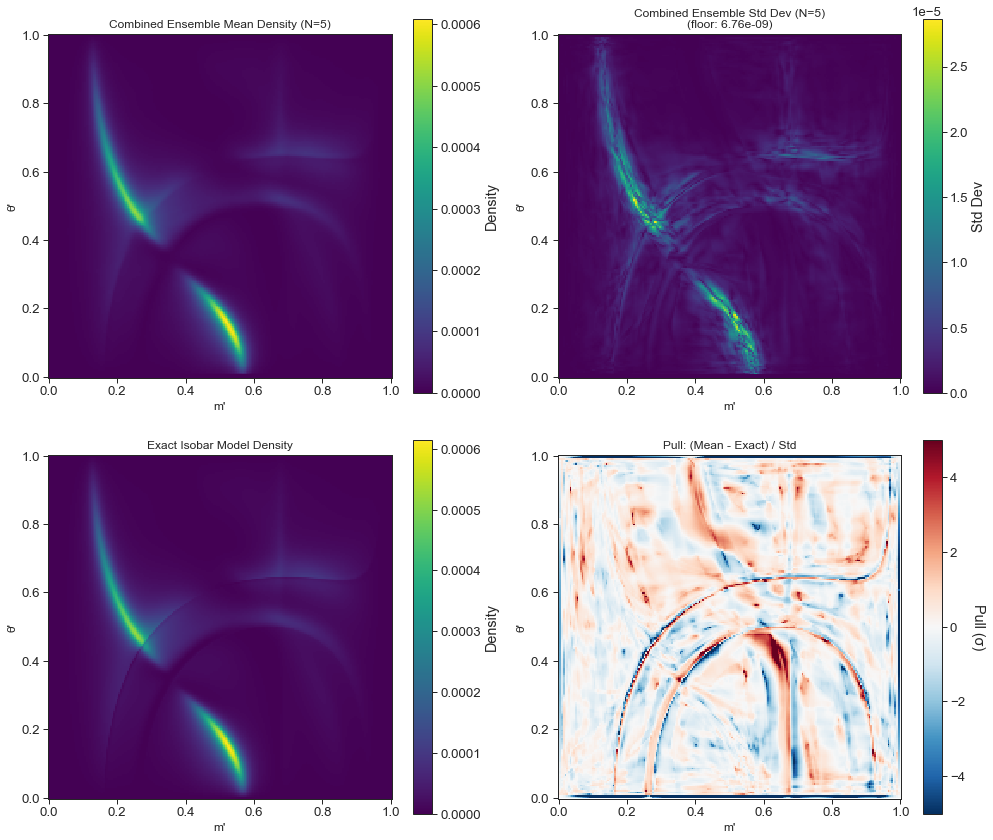


Pull map saved to: ensemble_pull_map_combined_1.pdf

PULL DISTRIBUTION ANALYSIS


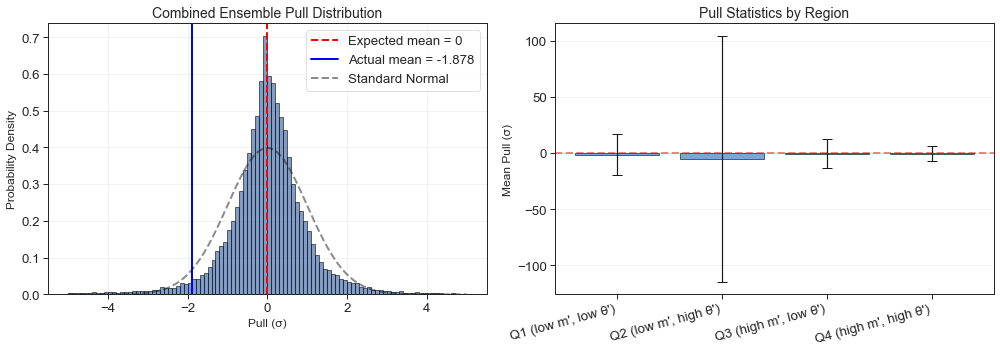


Pull distribution plot saved to: pull_distribution_combined_1.pdf

Pull Distribution Statistics:
  Sample size: 40,000 grid points
  Mean: -1.8777 (should be ~0)
  Std:  56.1227 (should be ~1)
  Median: 0.0011
  2.5%:  -3.45 (expected: -1.96)
  97.5%: 2.15 (expected: +1.96)
  Fraction outside ±2σ: 7.70% (expected: ~5%)
  Fraction outside ±3σ: 3.93% (expected: ~0.3%)

COMBINED ANALYSIS COMPLETE
Combined 5 models from 1 ensemble(s)
Generated files:
  - ensemble_pull_map_combined_1.pdf
  - pull_distribution_combined_1.pdf


In [71]:

# ============================================================================
# EXAMPLE USAGE: Combine multiple ensembles and analyze as one
# ============================================================================

print("="*80)
print("COMBINED MULTI-ENSEMBLE PULL MAP ANALYSIS")
print("="*80)

# List all ensembles to combine into one large ensemble
# Add more as you train them: ["test_ensemble", "test_ensemble2_odd", "test_ensemble3", ...]
ensemble_list = ["test_ensemble_odd"]

# Filter to only existing directories
import os
existing_ensembles = [e for e in ensemble_list if os.path.exists(e)]

if not existing_ensembles:
    print("\nNo ensembles found! Available ensembles will be analyzed when they exist.")
    print(f"Looking for: {ensemble_list}")
else:
    print(f"\nFound {len(existing_ensembles)} ensemble(s) to combine: {existing_ensembles}")
    
    # Configuration
    grid_nx, grid_ny = 200, 200
    sigma_floor = None  # Auto-set to 1% of median std
    
    # Create grid
    U, V, pts = make_sdp_grid(nx=grid_nx, ny=grid_ny)
    grid_shape = (grid_ny, grid_nx)
    
    # Compute exact density from isobar model
    print("\nComputing exact density from isobar model...")
    dkpp_model = DKpp()
    density_exact = compute_mag_exact(pts, SDP, flow, dkpp_model, device=device).reshape(grid_shape)
    density_exact_norm = density_exact / density_exact.sum()
    
    # Load and combine all ensembles into one
    print("\n" + "="*80)
    print("LOADING AND COMBINING ENSEMBLES")
    print("="*80)
    ensemble_densities, num_models, ensemble_info = load_combined_ensemble_densities(
        existing_ensembles, pts, grid_shape, 
        num_flows=16, hidden_features=128, num_bins=16, device=device
    )
    
    # Compute ensemble statistics (treating all models as one ensemble)
    print("\n" + "="*80)
    print("COMPUTING COMBINED ENSEMBLE STATISTICS")
    print("="*80)
    ensemble_mean = np.mean(ensemble_densities, axis=0)
    ensemble_std = np.std(ensemble_densities, axis=0, ddof=1)  # Sample std
    
    # Compute pull with sigma floor
    pull, sigma_floor_used = compute_pull_map_combined(ensemble_mean, ensemble_std, 
                                                       density_exact_norm, sigma_floor=sigma_floor)
    
    # Print statistics
    print(f"\nCombined Ensemble Statistics:")
    print(f"  Ensembles combined: {existing_ensembles}")
    for info in ensemble_info['models_per_ensemble']:
        print(f"    - {info['dir']}: {info['num_models']} models")
    print(f"  Total models: {num_models}")
    print(f"  Mean density - Min: {ensemble_mean.min():.6e}, Max: {ensemble_mean.max():.6e}")
    print(f"  Std density  - Min: {ensemble_std.min():.6e}, Max: {ensemble_std.max():.6e}")
    print(f"  Sigma floor used: {sigma_floor_used:.6e}")
    print(f"  Pull - Min: {pull.min():.2f}, Max: {pull.max():.2f}, Mean: {pull.mean():.2f}")
    print(f"  Pull std dev: {pull.std():.2f}")
    
    # Plot combined pull map
    print("\n" + "="*80)
    print("CREATING PULL MAP")
    print("="*80)
    
    plot_combined_pull_map(U, V, ensemble_mean, ensemble_std, density_exact_norm, pull, 
                          num_models, sigma_floor=sigma_floor_used, 
                          savepath=f'ensemble_pull_map_combined_{len(existing_ensembles)}.pdf')
    
    # Plot pull distribution
    print("\n" + "="*80)
    print("PULL DISTRIBUTION ANALYSIS")
    print("="*80)
    
    pull_flat = plot_combined_pull_distribution(pull, U, 
                                                savepath=f'pull_distribution_combined_{len(existing_ensembles)}.pdf')
    
    # Print detailed statistics
    print(f"\nPull Distribution Statistics:")
    print(f"  Sample size: {len(pull_flat):,} grid points")
    print(f"  Mean: {pull_flat.mean():.4f} (should be ~0)")
    print(f"  Std:  {pull_flat.std():.4f} (should be ~1)")
    print(f"  Median: {np.median(pull_flat):.4f}")
    print(f"  2.5%:  {np.percentile(pull_flat, 2.5):.2f} (expected: -1.96)")
    print(f"  97.5%: {np.percentile(pull_flat, 97.5):.2f} (expected: +1.96)")
    print(f"  Fraction outside ±2σ: {np.sum(np.abs(pull_flat) > 2) / len(pull_flat) * 100:.2f}% (expected: ~5%)")
    print(f"  Fraction outside ±3σ: {np.sum(np.abs(pull_flat) > 3) / len(pull_flat) * 100:.2f}% (expected: ~0.3%)")
    
    print("\n" + "="*80)
    print("COMBINED ANALYSIS COMPLETE")
    print("="*80)
    print(f"Combined {num_models} models from {len(existing_ensembles)} ensemble(s)")
    print("Generated files:")
    print(f"  - ensemble_pull_map_combined_{len(existing_ensembles)}.pdf")
    print(f"  - pull_distribution_combined_{len(existing_ensembles)}.pdf")

COMBINED MULTI-ENSEMBLE PULL MAP ANALYSIS

Found 2 ensemble(s) to combine: ['test_ensemble', 'test_ensemble2']

Computing exact density from isobar model...


/Users/san/opt/anaconda3/lib/python3.9/site-packages/nflows/transforms/coupling.py:561: UserWarning: Inputs to the softmax are not scaled down: initialization might be bad.
  warnings.warn(
/Users/san/Library/CloudStorage/OneDrive-CornellUniversity/Documents/GitHub/Gamma_Extraction/Amplitude.py:487: RuntimeWarning: divide by zero encountered in scalar divide
  dmp_dsij = -(1.0 / np.pi) * (1.0 / np.sqrt(one_minus_x2)) * (1.0 / (denom_m * np.sqrt(mijSq)))
/Users/san/Library/CloudStorage/OneDrive-CornellUniversity/Documents/GitHub/Gamma_Extraction/Amplitude.py:426: RuntimeWarning: divide by zero encountered in scalar divide
  cosHel = -(mikSq - self.mSq[i] - self.mSq[k] - 2.0 * EiCmsij * EkCmsij) / (2.0 * self.qi * self.qk)



LOADING AND COMBINING ENSEMBLES
Combining models from 2 ensemble(s): ['test_ensemble', 'test_ensemble2']

  Loading from test_ensemble...
    Found 5 models
      Processing model 1/5...
      Processing model 2/5...
      Processing model 3/5...
      Processing model 4/5...
      Processing model 5/5...

  Loading from test_ensemble2...
    Found 15 models
      Processing model 1/15...
      Processing model 2/15...
      Processing model 3/15...
      Processing model 4/15...
      Processing model 5/15...
      Processing model 6/15...
      Processing model 7/15...
      Processing model 8/15...
      Processing model 9/15...
      Processing model 10/15...
      Processing model 11/15...
      Processing model 12/15...
      Processing model 13/15...
      Processing model 14/15...
      Processing model 15/15...

  Total models combined: 20

COMPUTING COMBINED ENSEMBLE STATISTICS
  Auto-setting sigma floor: 7.361900e-09 (1% of median std)

Combined Ensemble Statistics:
  Ensem

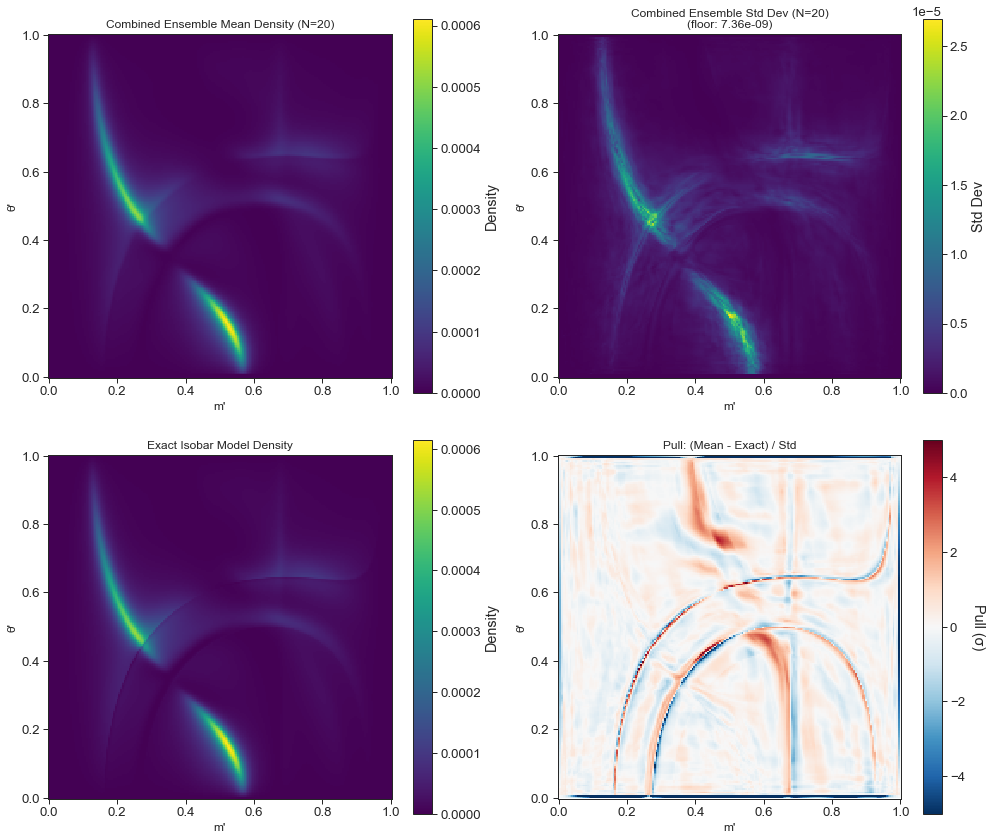


Pull map saved to: ensemble_pull_map_combined_2.pdf

PULL DISTRIBUTION ANALYSIS


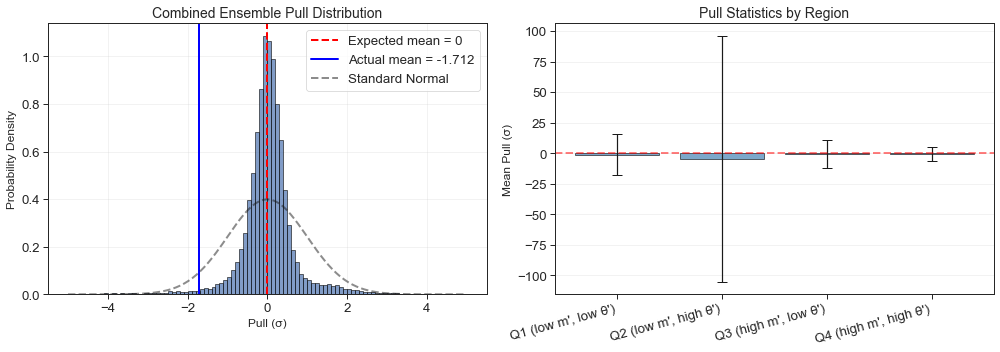


Pull distribution plot saved to: pull_distribution_combined_2.pdf

Pull Distribution Statistics:
  Sample size: 40,000 grid points
  Mean: -1.7123 (should be ~0)
  Std:  51.5075 (should be ~1)
  Median: 0.0165
  2.5%:  -2.44 (expected: -1.96)
  97.5%: 1.69 (expected: +1.96)
  Fraction outside ±2σ: 4.53% (expected: ~5%)
  Fraction outside ±3σ: 2.49% (expected: ~0.3%)

COMBINED ANALYSIS COMPLETE
Combined 20 models from 2 ensemble(s)
Generated files:
  - ensemble_pull_map_combined_2.pdf
  - pull_distribution_combined_2.pdf


In [75]:

# ============================================================================
# EXAMPLE USAGE: Combine multiple ensembles and analyze as one
# ============================================================================

print("="*80)
print("COMBINED MULTI-ENSEMBLE PULL MAP ANALYSIS")
print("="*80)

# List all ensembles to combine into one large ensemble
# Add more as you train them: ["test_ensemble", "test_ensemble2_odd", "test_ensemble3", ...]
ensemble_list = ["test_ensemble","test_ensemble2_odd" ]

# Filter to only existing directories
import os
existing_ensembles = [e for e in ensemble_list if os.path.exists(e)]

if not existing_ensembles:
    print("\nNo ensembles found! Available ensembles will be analyzed when they exist.")
    print(f"Looking for: {ensemble_list}")
else:
    print(f"\nFound {len(existing_ensembles)} ensemble(s) to combine: {existing_ensembles}")
    
    # Configuration
    grid_nx, grid_ny = 200, 200
    sigma_floor = None  # Auto-set to 1% of median std
    
    # Create grid
    U, V, pts = make_sdp_grid(nx=grid_nx, ny=grid_ny)
    grid_shape = (grid_ny, grid_nx)
    
    # Compute exact density from isobar model
    print("\nComputing exact density from isobar model...")
    dkpp_model = DKpp()
    density_exact = compute_mag_exact(pts, SDP, flow, dkpp_model, device=device).reshape(grid_shape)
    density_exact_norm = density_exact / density_exact.sum()
    
    # Load and combine all ensembles into one
    print("\n" + "="*80)
    print("LOADING AND COMBINING ENSEMBLES")
    print("="*80)
    ensemble_densities, num_models, ensemble_info = load_combined_ensemble_densities(
        existing_ensembles, pts, grid_shape, 
        num_flows=16, hidden_features=128, num_bins=16, device=device
    )
    
    # Compute ensemble statistics (treating all models as one ensemble)
    print("\n" + "="*80)
    print("COMPUTING COMBINED ENSEMBLE STATISTICS")
    print("="*80)
    ensemble_mean = np.mean(ensemble_densities, axis=0)
    ensemble_std = np.std(ensemble_densities, axis=0, ddof=1)  # Sample std
    
    # Compute pull with sigma floor
    pull, sigma_floor_used = compute_pull_map_combined(ensemble_mean, ensemble_std, 
                                                       density_exact_norm, sigma_floor=sigma_floor)
    
    # Print statistics
    print(f"\nCombined Ensemble Statistics:")
    print(f"  Ensembles combined: {existing_ensembles}")
    for info in ensemble_info['models_per_ensemble']:
        print(f"    - {info['dir']}: {info['num_models']} models")
    print(f"  Total models: {num_models}")
    print(f"  Mean density - Min: {ensemble_mean.min():.6e}, Max: {ensemble_mean.max():.6e}")
    print(f"  Std density  - Min: {ensemble_std.min():.6e}, Max: {ensemble_std.max():.6e}")
    print(f"  Sigma floor used: {sigma_floor_used:.6e}")
    print(f"  Pull - Min: {pull.min():.2f}, Max: {pull.max():.2f}, Mean: {pull.mean():.2f}")
    print(f"  Pull std dev: {pull.std():.2f}")
    
    # Plot combined pull map
    print("\n" + "="*80)
    print("CREATING PULL MAP")
    print("="*80)
    
    plot_combined_pull_map(U, V, ensemble_mean, ensemble_std, density_exact_norm, pull, 
                          num_models, sigma_floor=sigma_floor_used, 
                          savepath=f'ensemble_pull_map_combined_{len(existing_ensembles)}.pdf')
    
    # Plot pull distribution
    print("\n" + "="*80)
    print("PULL DISTRIBUTION ANALYSIS")
    print("="*80)
    
    pull_flat = plot_combined_pull_distribution(pull, U, 
                                                savepath=f'pull_distribution_combined_{len(existing_ensembles)}.pdf')
    
    # Print detailed statistics
    print(f"\nPull Distribution Statistics:")
    print(f"  Sample size: {len(pull_flat):,} grid points")
    print(f"  Mean: {pull_flat.mean():.4f} (should be ~0)")
    print(f"  Std:  {pull_flat.std():.4f} (should be ~1)")
    print(f"  Median: {np.median(pull_flat):.4f}")
    print(f"  2.5%:  {np.percentile(pull_flat, 2.5):.2f} (expected: -1.96)")
    print(f"  97.5%: {np.percentile(pull_flat, 97.5):.2f} (expected: +1.96)")
    print(f"  Fraction outside ±2σ: {np.sum(np.abs(pull_flat) > 2) / len(pull_flat) * 100:.2f}% (expected: ~5%)")
    print(f"  Fraction outside ±3σ: {np.sum(np.abs(pull_flat) > 3) / len(pull_flat) * 100:.2f}% (expected: ~0.3%)")
    
    print("\n" + "="*80)
    print("COMBINED ANALYSIS COMPLETE")
    print("="*80)
    print(f"Combined {num_models} models from {len(existing_ensembles)} ensemble(s)")
    print("Generated files:")
    print(f"  - ensemble_pull_map_combined_{len(existing_ensembles)}.pdf")
    print(f"  - pull_distribution_combined_{len(existing_ensembles)}.pdf")

COMBINED MULTI-ENSEMBLE PULL MAP ANALYSIS

Found 2 ensemble(s) to combine: ['test_ensemble', 'test_ensemble2']

Computing exact density from isobar model...


/Users/san/Library/CloudStorage/OneDrive-CornellUniversity/Documents/GitHub/Gamma_Extraction/Amplitude.py:487: RuntimeWarning: divide by zero encountered in scalar divide
  dmp_dsij = -(1.0 / np.pi) * (1.0 / np.sqrt(one_minus_x2)) * (1.0 / (denom_m * np.sqrt(mijSq)))
/Users/san/Library/CloudStorage/OneDrive-CornellUniversity/Documents/GitHub/Gamma_Extraction/Amplitude.py:426: RuntimeWarning: divide by zero encountered in scalar divide
  cosHel = -(mikSq - self.mSq[i] - self.mSq[k] - 2.0 * EiCmsij * EkCmsij) / (2.0 * self.qi * self.qk)



LOADING AND COMBINING ENSEMBLES
Combining models from 2 ensemble(s): ['test_ensemble', 'test_ensemble2']

  Loading from test_ensemble...
    Found 5 models
      Processing model 1/5...
      Processing model 2/5...
      Processing model 3/5...
      Processing model 4/5...
      Processing model 5/5...

  Loading from test_ensemble2...
    Found 20 models
      Processing model 1/20...
      Processing model 2/20...
      Processing model 3/20...
      Processing model 4/20...
      Processing model 5/20...
      Processing model 6/20...
      Processing model 7/20...
      Processing model 8/20...
      Processing model 9/20...
      Processing model 10/20...
      Processing model 11/20...
      Processing model 12/20...
      Processing model 13/20...
      Processing model 14/20...
      Processing model 15/20...
      Processing model 16/20...
      Processing model 17/20...
      Processing model 18/20...
      Processing model 19/20...
      Processing model 20/20...

  Tota

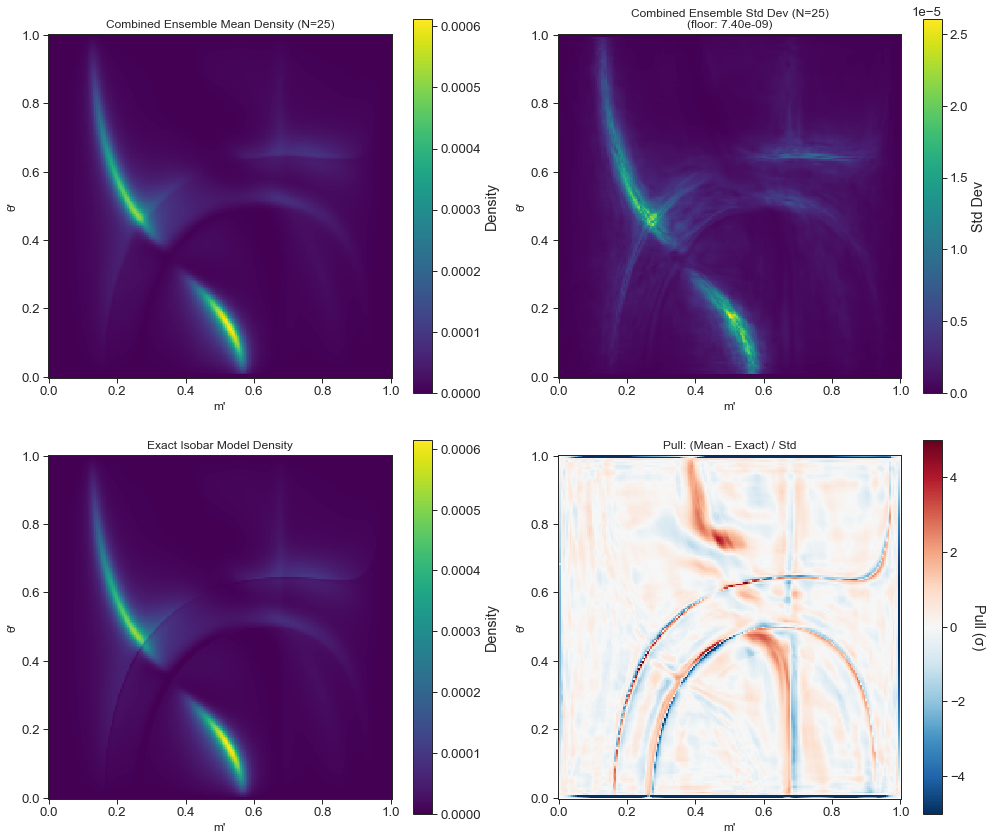


Pull map saved to: ensemble_pull_map_combined_2.pdf

PULL DISTRIBUTION ANALYSIS


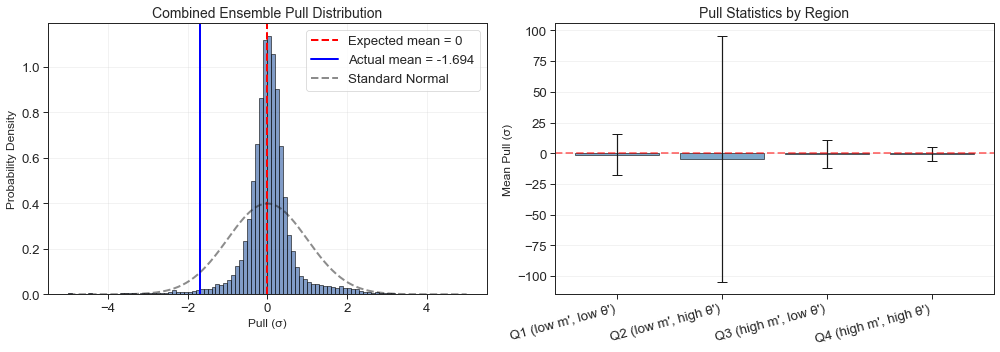


Pull distribution plot saved to: pull_distribution_combined_2.pdf

Pull Distribution Statistics:
  Sample size: 40,000 grid points
  Mean: -1.6941 (should be ~0)
  Std:  51.2384 (should be ~1)
  Median: 0.0329
  2.5%:  -2.40 (expected: -1.96)
  97.5%: 1.69 (expected: +1.96)
  Fraction outside ±2σ: 4.56% (expected: ~5%)
  Fraction outside ±3σ: 2.45% (expected: ~0.3%)

COMBINED ANALYSIS COMPLETE
Combined 25 models from 2 ensemble(s)
Generated files:
  - ensemble_pull_map_combined_2.pdf
  - pull_distribution_combined_2.pdf


In [78]:

# ============================================================================
# EXAMPLE USAGE: Combine multiple ensembles and analyze as one
# ============================================================================

print("="*80)
print("COMBINED MULTI-ENSEMBLE PULL MAP ANALYSIS")
print("="*80)

# List all ensembles to combine into one large ensemble
# Add more as you train them: ["test_ensemble", "test_ensemble2_odd", "test_ensemble3", ...]
ensemble_list = ["test_ensemble","test_ensemble2_odd" ]

# Filter to only existing directories
import os
existing_ensembles = [e for e in ensemble_list if os.path.exists(e)]

if not existing_ensembles:
    print("\nNo ensembles found! Available ensembles will be analyzed when they exist.")
    print(f"Looking for: {ensemble_list}")
else:
    print(f"\nFound {len(existing_ensembles)} ensemble(s) to combine: {existing_ensembles}")
    
    # Configuration
    grid_nx, grid_ny = 200, 200
    sigma_floor = None  # Auto-set to 1% of median std
    
    # Create grid
    U, V, pts = make_sdp_grid(nx=grid_nx, ny=grid_ny)
    grid_shape = (grid_ny, grid_nx)
    
    # Compute exact density from isobar model
    print("\nComputing exact density from isobar model...")
    dkpp_model = DKpp()
    density_exact = compute_mag_exact(pts, SDP, flow, dkpp_model, device=device).reshape(grid_shape)
    density_exact_norm = density_exact / density_exact.sum()
    
    # Load and combine all ensembles into one
    print("\n" + "="*80)
    print("LOADING AND COMBINING ENSEMBLES")
    print("="*80)
    ensemble_densities, num_models, ensemble_info = load_combined_ensemble_densities(
        existing_ensembles, pts, grid_shape, 
        num_flows=16, hidden_features=128, num_bins=16, device=device
    )
    
    # Compute ensemble statistics (treating all models as one ensemble)
    print("\n" + "="*80)
    print("COMPUTING COMBINED ENSEMBLE STATISTICS")
    print("="*80)
    ensemble_mean = np.mean(ensemble_densities, axis=0)
    ensemble_std = np.std(ensemble_densities, axis=0, ddof=1)  # Sample std
    
    # Compute pull with sigma floor
    pull, sigma_floor_used = compute_pull_map_combined(ensemble_mean, ensemble_std, 
                                                       density_exact_norm, sigma_floor=sigma_floor)
    
    # Print statistics
    print(f"\nCombined Ensemble Statistics:")
    print(f"  Ensembles combined: {existing_ensembles}")
    for info in ensemble_info['models_per_ensemble']:
        print(f"    - {info['dir']}: {info['num_models']} models")
    print(f"  Total models: {num_models}")
    print(f"  Mean density - Min: {ensemble_mean.min():.6e}, Max: {ensemble_mean.max():.6e}")
    print(f"  Std density  - Min: {ensemble_std.min():.6e}, Max: {ensemble_std.max():.6e}")
    print(f"  Sigma floor used: {sigma_floor_used:.6e}")
    print(f"  Pull - Min: {pull.min():.2f}, Max: {pull.max():.2f}, Mean: {pull.mean():.2f}")
    print(f"  Pull std dev: {pull.std():.2f}")
    
    # Plot combined pull map
    print("\n" + "="*80)
    print("CREATING PULL MAP")
    print("="*80)
    
    plot_combined_pull_map(U, V, ensemble_mean, ensemble_std, density_exact_norm, pull, 
                          num_models, sigma_floor=sigma_floor_used, 
                          savepath=f'ensemble_pull_map_combined_{len(existing_ensembles)}.pdf')
    
    # Plot pull distribution
    print("\n" + "="*80)
    print("PULL DISTRIBUTION ANALYSIS")
    print("="*80)
    
    pull_flat = plot_combined_pull_distribution(pull, U, 
                                                savepath=f'pull_distribution_combined_{len(existing_ensembles)}.pdf')
    
    # Print detailed statistics
    print(f"\nPull Distribution Statistics:")
    print(f"  Sample size: {len(pull_flat):,} grid points")
    print(f"  Mean: {pull_flat.mean():.4f} (should be ~0)")
    print(f"  Std:  {pull_flat.std():.4f} (should be ~1)")
    print(f"  Median: {np.median(pull_flat):.4f}")
    print(f"  2.5%:  {np.percentile(pull_flat, 2.5):.2f} (expected: -1.96)")
    print(f"  97.5%: {np.percentile(pull_flat, 97.5):.2f} (expected: +1.96)")
    print(f"  Fraction outside ±2σ: {np.sum(np.abs(pull_flat) > 2) / len(pull_flat) * 100:.2f}% (expected: ~5%)")
    print(f"  Fraction outside ±3σ: {np.sum(np.abs(pull_flat) > 3) / len(pull_flat) * 100:.2f}% (expected: ~0.3%)")
    
    print("\n" + "="*80)
    print("COMBINED ANALYSIS COMPLETE")
    print("="*80)
    print(f"Combined {num_models} models from {len(existing_ensembles)} ensemble(s)")
    print("Generated files:")
    print(f"  - ensemble_pull_map_combined_{len(existing_ensembles)}.pdf")
    print(f"  - pull_distribution_combined_{len(existing_ensembles)}.pdf")

Pull indicator map saved to: pull_indicator_map.pdf


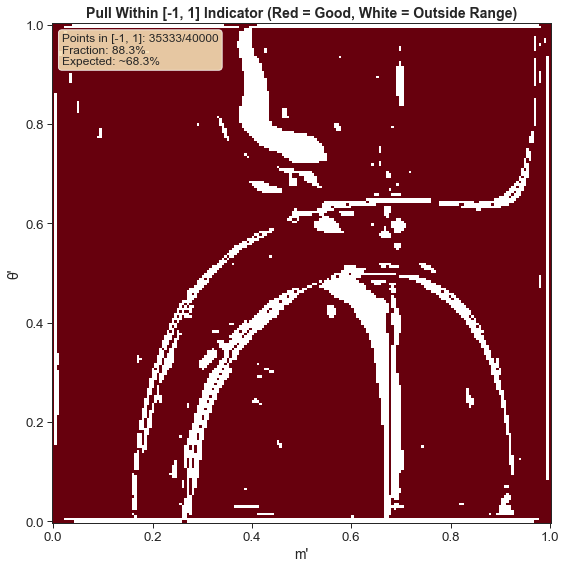


Summary: 88.3% of Dalitz plot has pull within [-1, 1]


In [70]:
def plot_pull_indicator_map(U, V, pull, savepath='pull_indicator_map.pdf'):
    """
    Plot 2D map showing regions where pull is within [-1, 1] in red, empty otherwise.
    
    Parameters
    ----------
    U, V : ndarray
        Meshgrid coordinates for the Dalitz plot
    pull : ndarray
        Pull values from compute_pull_map_combined
    savepath : str
        Path to save the figure
    """
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Create indicator: 1 where |pull| <= 1, NaN otherwise (for empty/white)
    indicator = np.where(np.abs(pull) <= 1, 1, np.nan)
    
    # Plot only the regions within [-1, 1] in red
    im = ax.pcolormesh(U, V, indicator, cmap='Reds', shading='auto', vmin=0, vmax=1)
    
    ax.set_xlabel("m'", fontsize=14)
    ax.set_ylabel("θ'", fontsize=14)
    ax.set_title('Pull Within [-1, 1] Indicator (Red = Good, White = Outside Range)', 
                 fontsize=14, fontweight='bold')
    ax.set_aspect('equal')
    
    # Calculate statistics
    total_points = pull.size
    points_in_range = np.sum(np.abs(pull) <= 1)
    fraction_in_range = points_in_range / total_points
    
    # Add text with statistics
    stats_text = f'Points in [-1, 1]: {points_in_range}/{total_points}\n'
    stats_text += f'Fraction: {fraction_in_range:.1%}\n'
    stats_text += f'Expected: ~68.3%'
    
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
            verticalalignment='top', fontsize=12,
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.9))
    
    plt.tight_layout()
    plt.savefig(savepath, dpi=300, bbox_inches='tight')
    print(f"Pull indicator map saved to: {savepath}")
    plt.show()
    
    print(f"\nSummary: {fraction_in_range:.1%} of Dalitz plot has pull within [-1, 1]")


plot_pull_indicator_map(U, V, pull, savepath='pull_indicator_map.pdf')


Pull indicator map saved to: pull_indicator_map.pdf


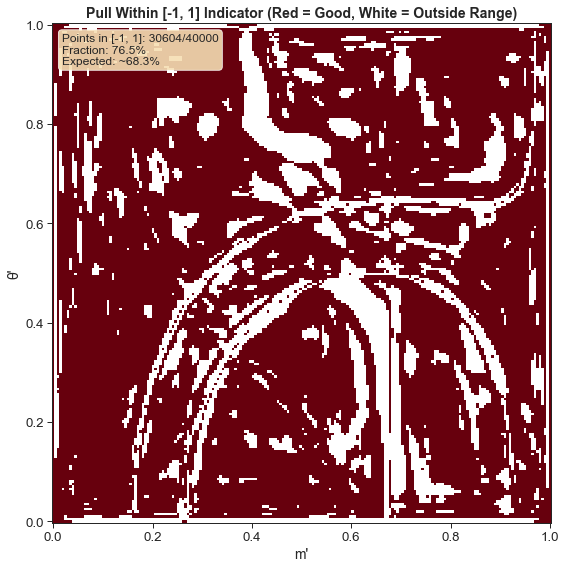


Summary: 76.5% of Dalitz plot has pull within [-1, 1]


In [72]:
def plot_pull_indicator_map(U, V, pull, savepath='pull_indicator_map.pdf'):
    """
    Plot 2D map showing regions where pull is within [-1, 1] in red, empty otherwise.
    
    Parameters
    ----------
    U, V : ndarray
        Meshgrid coordinates for the Dalitz plot
    pull : ndarray
        Pull values from compute_pull_map_combined
    savepath : str
        Path to save the figure
    """
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Create indicator: 1 where |pull| <= 1, NaN otherwise (for empty/white)
    indicator = np.where(np.abs(pull) <= 1, 1, np.nan)
    
    # Plot only the regions within [-1, 1] in red
    im = ax.pcolormesh(U, V, indicator, cmap='Reds', shading='auto', vmin=0, vmax=1)
    
    ax.set_xlabel("m'", fontsize=14)
    ax.set_ylabel("θ'", fontsize=14)
    ax.set_title('Pull Within [-1, 1] Indicator (Red = Good, White = Outside Range)', 
                 fontsize=14, fontweight='bold')
    ax.set_aspect('equal')
    
    # Calculate statistics
    total_points = pull.size
    points_in_range = np.sum(np.abs(pull) <= 1)
    fraction_in_range = points_in_range / total_points
    
    # Add text with statistics
    stats_text = f'Points in [-1, 1]: {points_in_range}/{total_points}\n'
    stats_text += f'Fraction: {fraction_in_range:.1%}\n'
    stats_text += f'Expected: ~68.3%'
    
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
            verticalalignment='top', fontsize=12,
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.9))
    
    plt.tight_layout()
    plt.savefig(savepath, dpi=300, bbox_inches='tight')
    print(f"Pull indicator map saved to: {savepath}")
    plt.show()
    
    print(f"\nSummary: {fraction_in_range:.1%} of Dalitz plot has pull within [-1, 1]")


plot_pull_indicator_map(U, V, pull, savepath='pull_indicator_map.pdf')


Pull indicator map saved to: pull_indicator_map.pdf


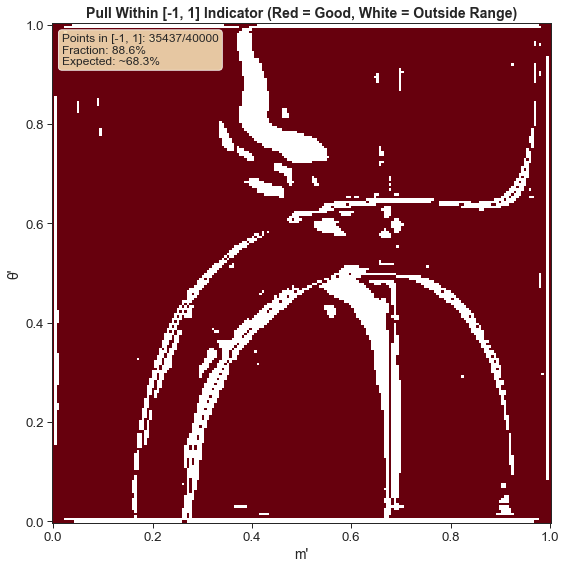


Summary: 88.6% of Dalitz plot has pull within [-1, 1]


In [76]:
plot_pull_indicator_map(U, V, pull, savepath='pull_indicator_map.pdf')

Pull indicator map saved to: pull_indicator_map.pdf


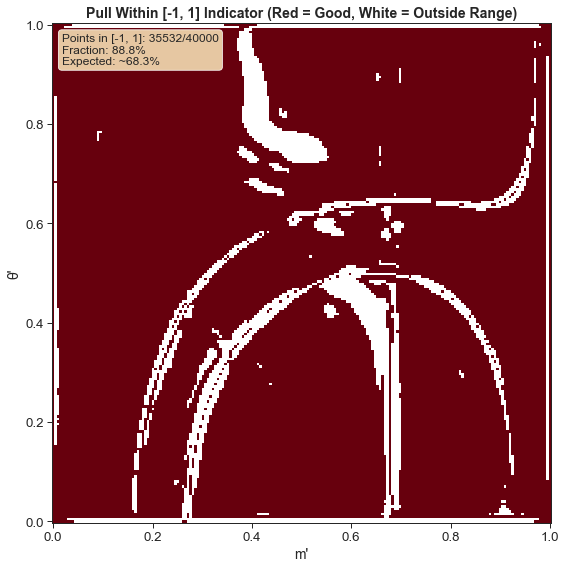


Summary: 88.8% of Dalitz plot has pull within [-1, 1]


In [79]:
plot_pull_indicator_map(U, V, pull, savepath='pull_indicator_map.pdf')

COMBINED MULTI-ENSEMBLE PULL MAP ANALYSIS

Found 2 ensemble(s) to combine: ['test_ensemble', 'test_ensemble2']

Computing exact density from isobar model...


/Users/san/Library/CloudStorage/OneDrive-CornellUniversity/Documents/GitHub/Gamma_Extraction/Amplitude.py:487: RuntimeWarning: divide by zero encountered in scalar divide
  dmp_dsij = -(1.0 / np.pi) * (1.0 / np.sqrt(one_minus_x2)) * (1.0 / (denom_m * np.sqrt(mijSq)))
/Users/san/Library/CloudStorage/OneDrive-CornellUniversity/Documents/GitHub/Gamma_Extraction/Amplitude.py:426: RuntimeWarning: divide by zero encountered in scalar divide
  cosHel = -(mikSq - self.mSq[i] - self.mSq[k] - 2.0 * EiCmsij * EkCmsij) / (2.0 * self.qi * self.qk)



LOADING AND COMBINING ENSEMBLES
Combining models from 2 ensemble(s): ['test_ensemble', 'test_ensemble2']

  Loading from test_ensemble...
    Found 5 models
      Processing model 1/5...
      Processing model 2/5...
      Processing model 3/5...
      Processing model 4/5...
      Processing model 5/5...

  Loading from test_ensemble2...
    Found 10 models
      Processing model 1/10...
      Processing model 2/10...
      Processing model 3/10...
      Processing model 4/10...
      Processing model 5/10...
      Processing model 6/10...
      Processing model 7/10...
      Processing model 8/10...
      Processing model 9/10...
      Processing model 10/10...

  Total models combined: 15

COMPUTING COMBINED ENSEMBLE STATISTICS
  Auto-setting sigma floor: 7.369488e-09 (1% of median std)

Combined Ensemble Statistics:
  Ensembles combined: ['test_ensemble', 'test_ensemble2']
    - test_ensemble: 5 models
    - test_ensemble2: 10 models
  Total models: 15
  Mean density - Min: 0.0000

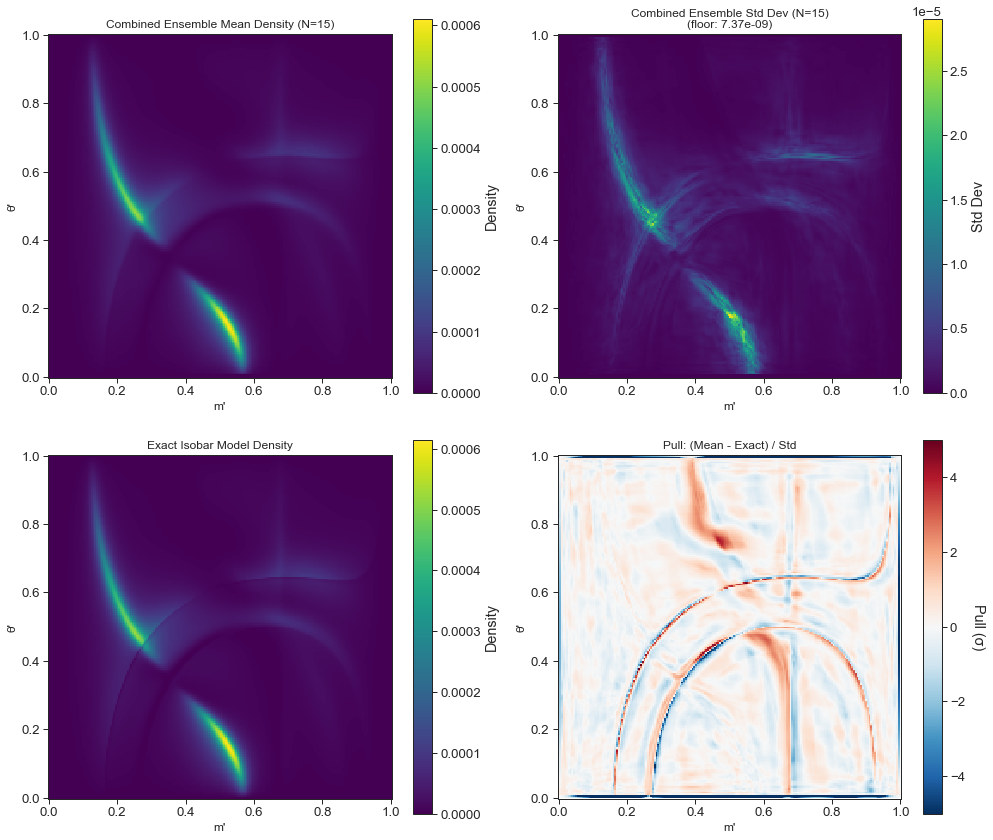


Pull map saved to: ensemble_pull_map_combined_2.pdf

PULL DISTRIBUTION ANALYSIS


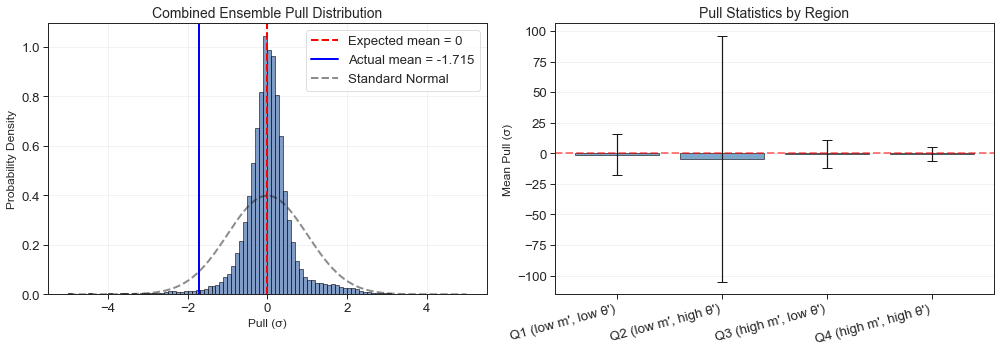


Pull distribution plot saved to: pull_distribution_combined_2.pdf

Pull Distribution Statistics:
  Sample size: 40,000 grid points
  Mean: -1.7148 (should be ~0)
  Std:  51.4547 (should be ~1)
  Median: 0.0142
  2.5%:  -2.42 (expected: -1.96)
  97.5%: 1.69 (expected: +1.96)
  Fraction outside ±2σ: 4.50% (expected: ~5%)
  Fraction outside ±3σ: 2.42% (expected: ~0.3%)

COMBINED ANALYSIS COMPLETE
Combined 15 models from 2 ensemble(s)
Generated files:
  - ensemble_pull_map_combined_2.pdf
  - pull_distribution_combined_2.pdf


In [55]:
# ============================================================================
# EXAMPLE USAGE: Combine multiple ensembles and analyze as one
# ============================================================================

print("="*80)
print("COMBINED MULTI-ENSEMBLE PULL MAP ANALYSIS")
print("="*80)

# List all ensembles to combine into one large ensemble
# Add more as you train them: ["test_ensemble", "test_ensemble2_odd", "test_ensemble3", ...]
ensemble_list = ["test_ensemble", "test_ensemble2_odd"]

# Filter to only existing directories
import os
existing_ensembles = [e for e in ensemble_list if os.path.exists(e)]

if not existing_ensembles:
    print("\nNo ensembles found! Available ensembles will be analyzed when they exist.")
    print(f"Looking for: {ensemble_list}")
else:
    print(f"\nFound {len(existing_ensembles)} ensemble(s) to combine: {existing_ensembles}")
    
    # Configuration
    grid_nx, grid_ny = 200, 200
    sigma_floor = None  # Auto-set to 1% of median std
    
    # Create grid
    U, V, pts = make_sdp_grid(nx=grid_nx, ny=grid_ny)
    grid_shape = (grid_ny, grid_nx)
    
    # Compute exact density from isobar model
    print("\nComputing exact density from isobar model...")
    dkpp_model = DKpp()
    density_exact = compute_mag_exact(pts, SDP, flow, dkpp_model, device=device).reshape(grid_shape)
    density_exact_norm = density_exact / density_exact.sum()
    
    # Load and combine all ensembles into one
    print("\n" + "="*80)
    print("LOADING AND COMBINING ENSEMBLES")
    print("="*80)
    ensemble_densities, num_models, ensemble_info = load_combined_ensemble_densities(
        existing_ensembles, pts, grid_shape, 
        num_flows=16, hidden_features=128, num_bins=16, device=device
    )
    
    # Compute ensemble statistics (treating all models as one ensemble)
    print("\n" + "="*80)
    print("COMPUTING COMBINED ENSEMBLE STATISTICS")
    print("="*80)
    ensemble_mean = np.mean(ensemble_densities, axis=0)
    ensemble_std = np.std(ensemble_densities, axis=0, ddof=1)  # Sample std
    
    # Compute pull with sigma floor
    pull, sigma_floor_used = compute_pull_map_combined(ensemble_mean, ensemble_std, 
                                                       density_exact_norm, sigma_floor=sigma_floor)
    
    # Print statistics
    print(f"\nCombined Ensemble Statistics:")
    print(f"  Ensembles combined: {existing_ensembles}")
    for info in ensemble_info['models_per_ensemble']:
        print(f"    - {info['dir']}: {info['num_models']} models")
    print(f"  Total models: {num_models}")
    print(f"  Mean density - Min: {ensemble_mean.min():.6e}, Max: {ensemble_mean.max():.6e}")
    print(f"  Std density  - Min: {ensemble_std.min():.6e}, Max: {ensemble_std.max():.6e}")
    print(f"  Sigma floor used: {sigma_floor_used:.6e}")
    print(f"  Pull - Min: {pull.min():.2f}, Max: {pull.max():.2f}, Mean: {pull.mean():.2f}")
    print(f"  Pull std dev: {pull.std():.2f}")
    
    # Plot combined pull map
    print("\n" + "="*80)
    print("CREATING PULL MAP")
    print("="*80)
    
    plot_combined_pull_map(U, V, ensemble_mean, ensemble_std, density_exact_norm, pull, 
                          num_models, sigma_floor=sigma_floor_used, 
                          savepath=f'ensemble_pull_map_combined_{len(existing_ensembles)}.pdf')
    
    # Plot pull distribution
    print("\n" + "="*80)
    print("PULL DISTRIBUTION ANALYSIS")
    print("="*80)
    
    pull_flat = plot_combined_pull_distribution(pull, U, 
                                                savepath=f'pull_distribution_combined_{len(existing_ensembles)}.pdf')
    
    # Print detailed statistics
    print(f"\nPull Distribution Statistics:")
    print(f"  Sample size: {len(pull_flat):,} grid points")
    print(f"  Mean: {pull_flat.mean():.4f} (should be ~0)")
    print(f"  Std:  {pull_flat.std():.4f} (should be ~1)")
    print(f"  Median: {np.median(pull_flat):.4f}")
    print(f"  2.5%:  {np.percentile(pull_flat, 2.5):.2f} (expected: -1.96)")
    print(f"  97.5%: {np.percentile(pull_flat, 97.5):.2f} (expected: +1.96)")
    print(f"  Fraction outside ±2σ: {np.sum(np.abs(pull_flat) > 2) / len(pull_flat) * 100:.2f}% (expected: ~5%)")
    print(f"  Fraction outside ±3σ: {np.sum(np.abs(pull_flat) > 3) / len(pull_flat) * 100:.2f}% (expected: ~0.3%)")
    
    print("\n" + "="*80)
    print("COMBINED ANALYSIS COMPLETE")
    print("="*80)
    print(f"Combined {num_models} models from {len(existing_ensembles)} ensemble(s)")
    print("Generated files:")
    print(f"  - ensemble_pull_map_combined_{len(existing_ensembles)}.pdf")
    print(f"  - pull_distribution_combined_{len(existing_ensembles)}.pdf")

SIGMA DIAGNOSTICS


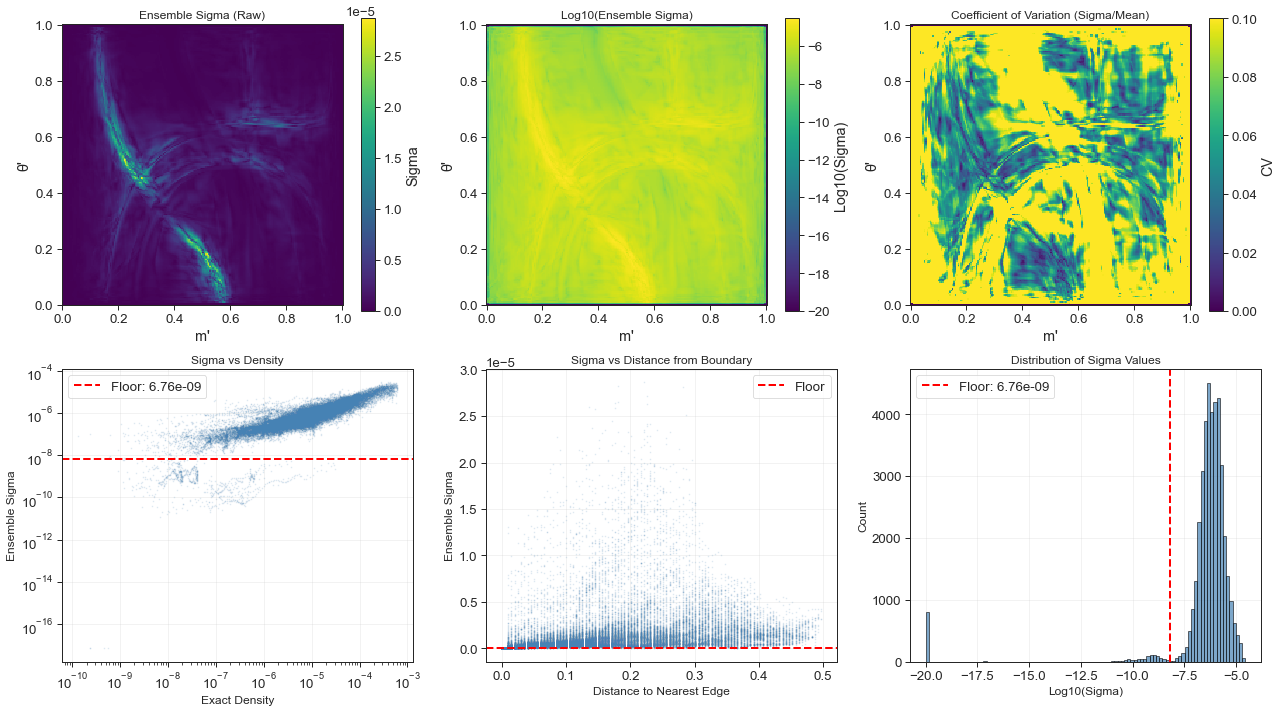


Sigma diagnostics saved to: sigma_diagnostics.pdf

SIGMA STATISTICS BY DENSITY REGION

Density > 1e-04 (5.1% of SDP):
  Sigma mean: 9.254302e-06
  Sigma std:  4.999453e-06
  Sigma range: [6.662811e-07, 2.865170e-05]
  Sigma/floor ratio: 1369.54

Density > 1e-05 (43.4% of SDP):
  Sigma mean: 2.744094e-06
  Sigma std:  3.196499e-06
  Sigma range: [1.128635e-09, 2.865170e-05]
  Sigma/floor ratio: 406.10

Density > 1e-06 (83.3% of SDP):
  Sigma mean: 1.688324e-06
  Sigma std:  2.572300e-06
  Sigma range: [0.000000e+00, 2.865170e-05]
  Sigma/floor ratio: 249.85

Density > 1e-07 (94.6% of SDP):
  Sigma mean: 1.512458e-06
  Sigma std:  2.463872e-06
  Sigma range: [0.000000e+00, 2.865170e-05]
  Sigma/floor ratio: 223.83

Density > 1e-08 (98.3% of SDP):
  Sigma mean: 1.457182e-06
  Sigma std:  2.432596e-06
  Sigma range: [0.000000e+00, 2.865170e-05]
  Sigma/floor ratio: 215.65

SIGMA STATISTICS BY DISTANCE FROM EDGE

Interior (dist > 0.05):
  Mean sigma: 1.690290e-06
  Fraction of pixels: 81.0

In [42]:
# ============================================================================
# DIAGNOSTIC: Analyze where and why sigma is low
# ============================================================================

print("="*80)
print("SIGMA DIAGNOSTICS")
print("="*80)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Sigma map
im0 = axes[0, 0].pcolormesh(U, V, ensemble_std, cmap='viridis', shading='auto')
axes[0, 0].set_title('Ensemble Sigma (Raw)', fontsize=12)
axes[0, 0].set_xlabel("m'")
axes[0, 0].set_ylabel("θ'")
axes[0, 0].set_aspect('equal')
plt.colorbar(im0, ax=axes[0, 0], label='Sigma')

# 2. Log sigma map (better for wide ranges)
log_sigma = np.log10(ensemble_std + 1e-20)
im1 = axes[0, 1].pcolormesh(U, V, log_sigma, cmap='viridis', shading='auto')
axes[0, 1].set_title('Log10(Ensemble Sigma)', fontsize=12)
axes[0, 1].set_xlabel("m'")
axes[0, 1].set_ylabel("θ'")
axes[0, 1].set_aspect('equal')
plt.colorbar(im1, ax=axes[0, 1], label='Log10(Sigma)')

# 3. Coefficient of variation: Sigma / Mean
cv = ensemble_std / (ensemble_mean + 1e-20)
im2 = axes[0, 2].pcolormesh(U, V, cv, cmap='viridis', shading='auto', vmax=0.1)
axes[0, 2].set_title('Coefficient of Variation (Sigma/Mean)', fontsize=12)
axes[0, 2].set_xlabel("m'")
axes[0, 2].set_ylabel("θ'")
axes[0, 2].set_aspect('equal')
plt.colorbar(im2, ax=axes[0, 2], label='CV')

# 4. Sigma vs Density (scatter)
mask_plot = density_exact_norm > 1e-10
axes[1, 0].scatter(density_exact_norm[mask_plot], ensemble_std[mask_plot],
                   alpha=0.1, s=1, rasterized=True, c='steelblue')
axes[1, 0].set_xscale('log')
axes[1, 0].set_yscale('log')
axes[1, 0].set_xlabel('Exact Density', fontsize=12)
axes[1, 0].set_ylabel('Ensemble Sigma', fontsize=12)
axes[1, 0].set_title('Sigma vs Density', fontsize=12)
axes[1, 0].grid(True, alpha=0.3)

# Add sigma floor line
axes[1, 0].axhline(sigma_floor_used, color='red', linestyle='--',
                   linewidth=2, label=f'Floor: {sigma_floor_used:.2e}')
axes[1, 0].legend()

# 5. Sigma vs Distance from Edge
dist_to_edge = np.minimum(np.minimum(U, 1-U), np.minimum(V, 1-V))
axes[1, 1].scatter(dist_to_edge.ravel(), ensemble_std.ravel(),
                   alpha=0.1, s=1, rasterized=True, c='steelblue')
axes[1, 1].set_xlabel('Distance to Nearest Edge', fontsize=12)
axes[1, 1].set_ylabel('Ensemble Sigma', fontsize=12)
axes[1, 1].set_title('Sigma vs Distance from Boundary', fontsize=12)
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].axhline(sigma_floor_used, color='red', linestyle='--',
                   linewidth=2, label='Floor')
axes[1, 1].legend()

# 6. Histogram of Sigma (log scale)
log_sigma_flat = np.log10(ensemble_std.ravel() + 1e-20)
axes[1, 2].hist(log_sigma_flat, bins=100, edgecolor='black', alpha=0.7, color='steelblue')
axes[1, 2].axvline(np.log10(sigma_floor_used), color='red',
                   linestyle='--', linewidth=2, label=f'Floor: {sigma_floor_used:.2e}')
axes[1, 2].set_xlabel('Log10(Sigma)', fontsize=12)
axes[1, 2].set_ylabel('Count', fontsize=12)
axes[1, 2].set_title('Distribution of Sigma Values', fontsize=12)
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('sigma_diagnostics.pdf', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nSigma diagnostics saved to: sigma_diagnostics.pdf")

# ============================================================================
# Statistics by density region
# ============================================================================

print("\n" + "="*80)
print("SIGMA STATISTICS BY DENSITY REGION")
print("="*80)

density_thresholds = [1e-4, 1e-5, 1e-6, 1e-7, 1e-8]

for threshold in density_thresholds:
    mask_region = density_exact_norm > threshold
    if mask_region.sum() > 0:
        sigma_mean = ensemble_std[mask_region].mean()
        sigma_std = ensemble_std[mask_region].std()
        sigma_min = ensemble_std[mask_region].min()
        sigma_max = ensemble_std[mask_region].max()
        frac_pixels = mask_region.sum() / mask_region.size * 100
        
        print(f"\nDensity > {threshold:.0e} ({frac_pixels:.1f}% of SDP):")
        print(f"  Sigma mean: {sigma_mean:.6e}")
        print(f"  Sigma std:  {sigma_std:.6e}")
        print(f"  Sigma range: [{sigma_min:.6e}, {sigma_max:.6e}]")
        print(f"  Sigma/floor ratio: {sigma_mean/sigma_floor_used:.2f}")

# ============================================================================
# Edge effect analysis
# ============================================================================

print("\n" + "="*80)
print("SIGMA STATISTICS BY DISTANCE FROM EDGE")
print("="*80)

edge_thresholds = [0.05, 0.10, 0.20, 0.50]

for threshold in edge_thresholds:
    # Far from edge
    mask_interior = dist_to_edge.ravel() > threshold
    if mask_interior.sum() > 0:
        sigma_interior = ensemble_std.ravel()[mask_interior]
        
        # Near edge
        mask_edge = dist_to_edge.ravel() <= 0.05
        sigma_edge = ensemble_std.ravel()[mask_edge]
        
        print(f"\nInterior (dist > {threshold}):")
        print(f"  Mean sigma: {sigma_interior.mean():.6e}")
        print(f"  Fraction of pixels: {mask_interior.sum() / len(mask_interior) * 100:.1f}%")
        
        if len(sigma_edge) > 0:
            ratio = sigma_edge.mean() / sigma_interior.mean() if sigma_interior.mean() > 0 else 0
            print(f"  Edge/Interior sigma ratio: {ratio:.3f}")

# ============================================================================
# Model-to-model correlation analysis
# ============================================================================

print("\n" + "="*80)
print("ENSEMBLE DIVERSITY: Model-to-Model Correlations")
print("="*80)

correlations = []
for i in range(num_models):
    for j in range(i+1, num_models):
        corr = np.corrcoef(
            ensemble_densities[i].ravel(),
            ensemble_densities[j].ravel()
        )[0, 1]
        correlations.append(corr)
        if num_models <= 10:  # Only print if small ensemble
            print(f"  Model {i+1} vs Model {j+1}: correlation = {corr:.6f}")

if correlations:
    print(f"\nCorrelation statistics:")
    print(f"  Mean correlation: {np.mean(correlations):.6f}")
    print(f"  Std correlation:  {np.std(correlations):.6f}")
    print(f"  Min correlation:  {np.min(correlations):.6f}")
    print(f"  Max correlation:  {np.max(correlations):.6f}")
    
    if np.mean(correlations) > 0.99:
        print("\n  ⚠️  WARNING: Models are very highly correlated (>0.99)")
        print("     This indicates low ensemble diversity.")
        print("     Possible causes:")
        print("       - Training data too similar across models")
        print("       - Early stopping too aggressive")
        print("       - Need larger training pool")
    elif np.mean(correlations) > 0.95:
        print("\n  ⚠️  Models are highly correlated (>0.95)")
        print("     Ensemble diversity could be improved.")
    else:
        print("\n  ✓ Ensemble diversity looks reasonable")

# ============================================================================
# Fraction of sigma below floor
# ============================================================================

print("\n" + "="*80)
print("SIGMA FLOOR EFFECTIVENESS")
print("="*80)

frac_below_floor = np.sum(ensemble_std < sigma_floor_used) / ensemble_std.size * 100
frac_at_floor = np.sum(np.abs(ensemble_std - sigma_floor_used) < 1e-15) / ensemble_std.size * 100

print(f"Fraction of pixels with original sigma < floor: {frac_below_floor:.2f}%")
print(f"Fraction of pixels clamped to floor:           {frac_at_floor:.2f}%")

if frac_below_floor > 20:
    print(f"\n  ⚠️  >20% of pixels below floor - consider:")
    print(f"     - Increasing ensemble size (currently N={num_models})")
    print(f"     - Checking training diversity")
    print(f"     - Using alternative sigma floor strategy")
elif frac_below_floor > 10:
    print(f"\n  ⚠️  10-20% of pixels below floor")
    print(f"     This is expected for small ensembles (N={num_models})")
else:
    print(f"\n  ✓ Floor affecting <10% of pixels - good!")

print("\n" + "="*80)

ENSEMBLE PULL MAP ANALYSIS (LOG-DENSITY)

Computing exact log-density from isobar model...


/Users/san/opt/anaconda3/lib/python3.9/site-packages/nflows/transforms/coupling.py:561: UserWarning: Inputs to the softmax are not scaled down: initialization might be bad.
  warnings.warn(
/Users/san/Library/CloudStorage/OneDrive-CornellUniversity/Documents/GitHub/Gamma_Extraction/Amplitude.py:487: RuntimeWarning: divide by zero encountered in scalar divide
  dmp_dsij = -(1.0 / np.pi) * (1.0 / np.sqrt(one_minus_x2)) * (1.0 / (denom_m * np.sqrt(mijSq)))
/Users/san/Library/CloudStorage/OneDrive-CornellUniversity/Documents/GitHub/Gamma_Extraction/Amplitude.py:426: RuntimeWarning: divide by zero encountered in scalar divide
  cosHel = -(mikSq - self.mSq[i] - self.mSq[k] - 2.0 * EiCmsij * EkCmsij) / (2.0 * self.qi * self.qk)


Loading 5 models from test_ensemble (computing log-densities)...
  Processing model 1/5...
  Processing model 2/5...
  Processing model 3/5...
  Processing model 4/5...
  Processing model 5/5...

Computing ensemble statistics in log-space...

Ensemble statistics (log-density):
  Number of models: 5
  Mean log-density - Min: -175.66, Max: -7.40
  Std log-density  - Min: 0.0001, Max: 12.1394
  Log-density threshold: -100.00
  Valid region: 100.0% of SDP (log-density > threshold)
  Pull (log-space, valid region) - Min: -2127074.55, Max: 123.29, Mean: -449.70
  Pull std dev (log-space, valid region): 26463.88


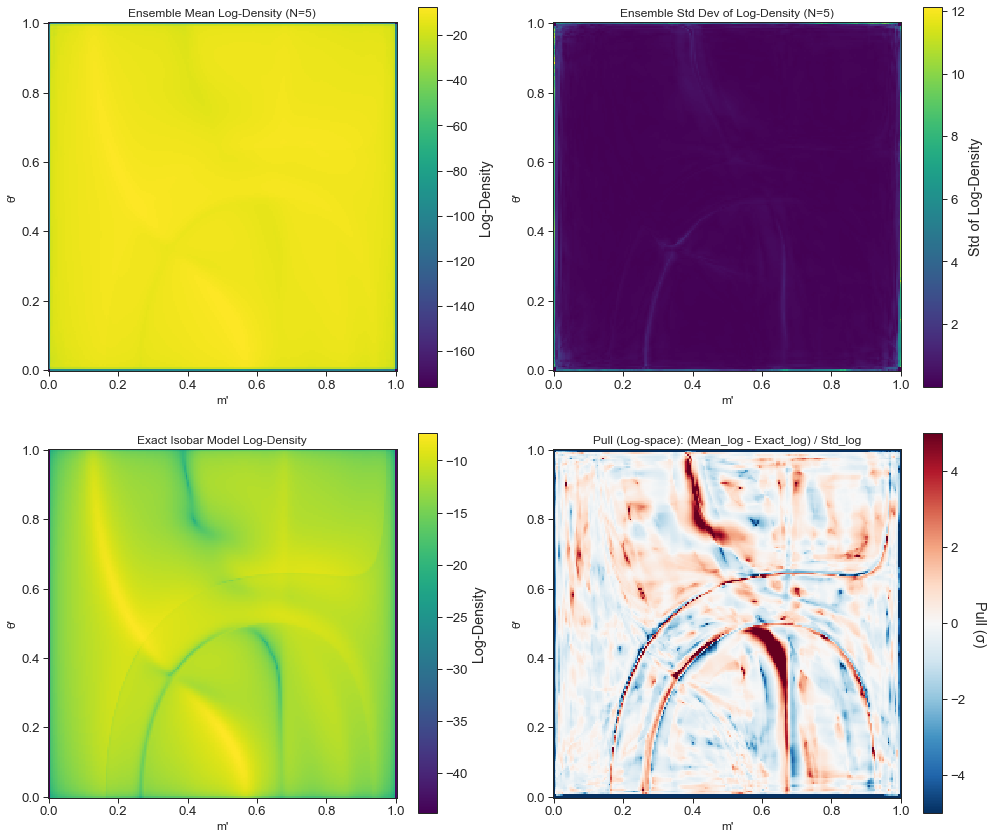


Log-density pull map saved to: ensemble_pull_map_log.pdf

LOG-DENSITY PULL DISTRIBUTION


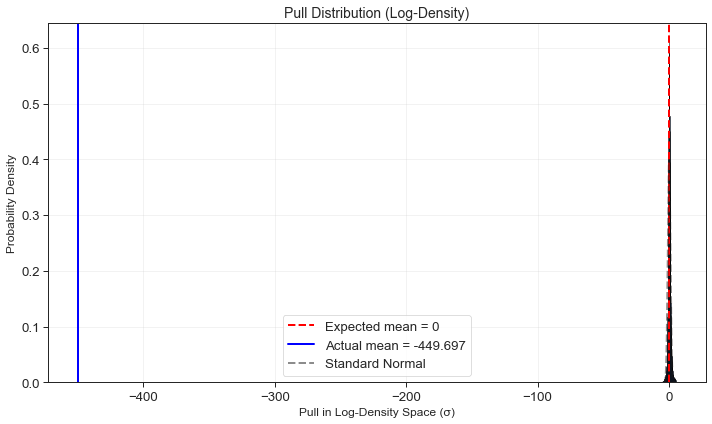


Log-density pull distribution statistics:
  Sample size: 40,000 grid points
  Mean: -449.6968 (should be ~0)
  Std:  26463.8820 (should be ~1)
  Median: -0.0603
  2.5%:  -7.42 (expected: -1.96)
  97.5%: 2.90 (expected: +1.96)
  Fraction outside ±2σ: 9.79% (expected: ~5%)
  Fraction outside ±3σ: 6.35% (expected: ~0.3%)

Plot saved to: pull_distribution_log.pdf


In [44]:
def load_ensemble_log_densities(ensemble_dir, pts, grid_shape, num_flows=16, 
                                hidden_features=128, num_bins=16, device='cpu'):
    """
    Load ensemble models and compute LOG-densities on a grid.
    
    Parameters
    ----------
    ensemble_dir : str
        Path to directory containing ensemble models
    pts : ndarray, shape (N, 2)
        Grid points in SDP coordinates
    grid_shape : tuple
        Shape of grid (ny, nx) for reshaping
    num_flows : int
        Number of coupling layers in flow architecture
    hidden_features : int
        Hidden layer size in flow architecture
    num_bins : int
        Number of spline bins in flow architecture
    device : str
        Device for computation ('cpu' or 'cuda')
    
    Returns
    -------
    ensemble_log_densities : ndarray, shape (num_models, ny, nx)
        Log-densities (normalized) from each model
    num_models : int
        Number of models loaded
    """
    from pathlib import Path
    import glob
    
    # Find all model files
    model_files = sorted(glob.glob(f"{ensemble_dir}/trial_seed*.pth"))
    # Exclude *_best.pth files
    model_files = [f for f in model_files if not f.endswith('_best.pth')]
    num_models = len(model_files)
    
    print(f"Loading {num_models} models from {ensemble_dir} (computing log-densities)...")
    ensemble_log_densities = []
    
    for idx, model_path in enumerate(model_files, 1):
        print(f"  Processing model {idx}/{num_models}...")
        
        # Load model
        model_flow = create_flow(num_flows=num_flows, hidden_features=hidden_features, 
                                 num_bins=num_bins)
        model_flow.load_state_dict(torch.load(model_path, map_location=device))
        model_flow.eval()
        model_flow.to(device)
        
        # Compute log-density directly (more numerically stable)
        with torch.no_grad():
            pts_tensor = torch.from_numpy(pts.astype(np.float32)).to(device)
            batch_size = 10000
            log_probs = []
            for i in range(0, len(pts_tensor), batch_size):
                batch = pts_tensor[i:i+batch_size]
                log_probs.append(model_flow.log_prob(batch).cpu().numpy())
            log_prob = np.concatenate(log_probs)
        
        log_density = log_prob.reshape(grid_shape)
        
        # Normalize: subtract log(integral) to get normalized log-density
        # log(p_norm) = log(p) - log(∫p) = log(p) - log(sum(exp(log(p))))
        # For numerical stability, use logsumexp
        from scipy.special import logsumexp
        log_integral = logsumexp(log_prob)  # log(sum(exp(log_prob)))
        log_density_norm = log_density - log_integral
        
        ensemble_log_densities.append(log_density_norm)
    
    return np.array(ensemble_log_densities), num_models


def compute_pull_map_log(ensemble_mean_log, ensemble_std_log, exact_log_density, log_density_threshold=None):
    """
    Compute pull map in log-density space: (ensemble_mean_log - exact_log) / ensemble_std_log
    
    Parameters
    ----------
    ensemble_mean_log : ndarray
        Mean log-density from ensemble
    ensemble_std_log : ndarray
        Standard deviation of log-density from ensemble
    exact_log_density : ndarray
        Exact log-density from isobar model
    log_density_threshold : float, optional
        Minimum log-density value to include in pull calculation.
        Points below this threshold are set to zero.
    
    Returns
    -------
    pull_log : ndarray
        Pull values in log-space, with masked regions set to zero
    mask : ndarray (bool)
        Boolean mask indicating valid regions (above threshold)
    """
    epsilon = 1e-10
    pull_log = (ensemble_mean_log - exact_log_density) / (ensemble_std_log + epsilon)
    
    # Apply log-density threshold if provided
    if log_density_threshold is not None:
        # Mask where exact log-density is too low
        mask = exact_log_density >= log_density_threshold
        pull_log_masked = pull_log.copy()
        pull_log_masked[~mask] = 0.0  # Set to zero instead of NaN
        return pull_log_masked, mask
    
    return pull_log, np.ones_like(pull_log, dtype=bool)


def plot_ensemble_pull_map_log(U, V, ensemble_mean_log, ensemble_std_log, exact_log_density, pull_log, 
                                num_models, savepath='ensemble_pull_map_log.pdf'):
    """
    Create 2x2 plot showing ensemble mean log-density, std, exact log-density, and pull map.
    
    Parameters
    ----------
    U, V : ndarray
        Mesh grid coordinates
    ensemble_mean_log : ndarray
        Ensemble mean log-density
    ensemble_std_log : ndarray
        Ensemble standard deviation of log-density
    exact_log_density : ndarray
        Exact log-density from isobar model
    pull_log : ndarray
        Pull values in log-space (regions below threshold are zero)
    num_models : int
        Number of models in ensemble
    savepath : str
        Path to save figure
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    
    # Top left: Ensemble mean log-density
    im0 = axes[0, 0].pcolormesh(U, V, ensemble_mean_log, cmap='viridis', shading='auto')
    axes[0, 0].set_xlabel("m'", fontsize=12)
    axes[0, 0].set_ylabel("θ'", fontsize=12)
    axes[0, 0].set_title(f'Ensemble Mean Log-Density (N={num_models})', fontsize=12)
    axes[0, 0].set_aspect('equal')
    plt.colorbar(im0, ax=axes[0, 0], label='Log-Density')
    
    # Top right: Ensemble std of log-density
    im1 = axes[0, 1].pcolormesh(U, V, ensemble_std_log, cmap='viridis', shading='auto')
    axes[0, 1].set_xlabel("m'", fontsize=12)
    axes[0, 1].set_ylabel("θ'", fontsize=12)
    axes[0, 1].set_title(f'Ensemble Std Dev of Log-Density (N={num_models})', fontsize=12)
    axes[0, 1].set_aspect('equal')
    plt.colorbar(im1, ax=axes[0, 1], label='Std of Log-Density')
    
    # Bottom left: Exact log-density
    im2 = axes[1, 0].pcolormesh(U, V, exact_log_density, cmap='viridis', shading='auto')
    axes[1, 0].set_xlabel("m'", fontsize=12)
    axes[1, 0].set_ylabel("θ'", fontsize=12)
    axes[1, 0].set_title('Exact Isobar Model Log-Density', fontsize=12)
    axes[1, 0].set_aspect('equal')
    plt.colorbar(im2, ax=axes[1, 0], label='Log-Density')
    
    # Bottom right: Pull map in log-space
    # Clip to ±5 sigma for visualization
    pull_log_clipped = np.clip(pull_log, -5, 5)
    im3 = axes[1, 1].pcolormesh(U, V, pull_log_clipped, cmap='RdBu_r', shading='auto',
                                vmin=-5, vmax=5)
    axes[1, 1].set_xlabel("m'", fontsize=12)
    axes[1, 1].set_ylabel("θ'", fontsize=12)
    axes[1, 1].set_title('Pull (Log-space): (Mean_log - Exact_log) / Std_log', fontsize=12)
    axes[1, 1].set_aspect('equal')
    cbar = plt.colorbar(im3, ax=axes[1, 1], label='Pull (σ)')
    cbar.set_label('Pull (σ)', rotation=270, labelpad=20)
    
    plt.tight_layout()
    plt.savefig(savepath, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\nLog-density pull map saved to: {savepath}")


# Main execution: Create pull map in LOG-DENSITY space using ensemble of models
print("="*80)
print("ENSEMBLE PULL MAP ANALYSIS (LOG-DENSITY)")
print("="*80)

# Configuration
ensemble_dir = "test_ensemble_odd"  # Change to your ensemble directory
grid_nx, grid_ny = 200, 200
log_density_threshold = -100  # Only compute pull where log-density > threshold (e.g., -15 corresponds to density > exp(-15) ≈ 3e-7)

# Create grid
U, V, pts = make_sdp_grid(nx=grid_nx, ny=grid_ny)
grid_shape = (grid_ny, grid_nx)

# Compute exact log-density from isobar model
print("\nComputing exact log-density from isobar model...")
dkpp_model = DKpp()
density_exact = compute_mag_exact(pts, SDP, flow, dkpp_model, device=device).reshape(grid_shape)
density_exact_norm = density_exact / density_exact.sum()
log_density_exact_norm = np.log(density_exact_norm + 1e-300)  # Add tiny epsilon to avoid log(0)

# Load ensemble and compute log-densities
ensemble_log_densities, num_models = load_ensemble_log_densities(
    ensemble_dir, pts, grid_shape, 
    num_flows=16, hidden_features=128, num_bins=16, device=device
)

# Compute ensemble statistics in log-space
print("\nComputing ensemble statistics in log-space...")
ensemble_mean_log = np.mean(ensemble_log_densities, axis=0)
ensemble_std_log = np.std(ensemble_log_densities, axis=0, ddof=1)  # Sample std

# Compute pull in log-space with threshold
pull_log, mask_log = compute_pull_map_log(ensemble_mean_log, ensemble_std_log, log_density_exact_norm, 
                                          log_density_threshold=log_density_threshold)

# Print statistics
print(f"\nEnsemble statistics (log-density):")
print(f"  Number of models: {num_models}")
print(f"  Mean log-density - Min: {ensemble_mean_log.min():.2f}, Max: {ensemble_mean_log.max():.2f}")
print(f"  Std log-density  - Min: {ensemble_std_log.min():.4f}, Max: {ensemble_std_log.max():.4f}")
if log_density_threshold is not None:
    # Only analyze pull in valid region (non-zero values)
    pull_log_valid = pull_log[mask_log]
    frac_valid = np.sum(mask_log) / mask_log.size * 100
    print(f"  Log-density threshold: {log_density_threshold:.2f}")
    print(f"  Valid region: {frac_valid:.1f}% of SDP (log-density > threshold)")
    if len(pull_log_valid) > 0:
        print(f"  Pull (log-space, valid region) - Min: {pull_log_valid.min():.2f}, Max: {pull_log_valid.max():.2f}, Mean: {pull_log_valid.mean():.2f}")
        print(f"  Pull std dev (log-space, valid region): {pull_log_valid.std():.2f}")
else:
    print(f"  Pull (log-space) - Min: {pull_log.min():.2f}, Max: {pull_log.max():.2f}, Mean: {pull_log.mean():.2f}")
    print(f"  Pull std dev (log-space): {pull_log.std():.2f}")

# Plot
plot_ensemble_pull_map_log(U, V, ensemble_mean_log, ensemble_std_log, log_density_exact_norm, pull_log, 
                           num_models, savepath='ensemble_pull_map_log.pdf')

# Also plot histogram of log-density pull
print("\n" + "="*80)
print("LOG-DENSITY PULL DISTRIBUTION")
print("="*80)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

pull_log_flat = pull_log.ravel()
pull_log_flat = pull_log_flat[np.isfinite(pull_log_flat)]  # Remove NaN/inf values

ax.hist(pull_log_flat, bins=100, range=(-5, 5), alpha=0.7, edgecolor='black', density=True)
ax.axvline(0, color='red', linestyle='--', linewidth=2, label='Expected mean = 0')
ax.axvline(pull_log_flat.mean(), color='blue', linestyle='-', linewidth=2, 
           label=f'Actual mean = {pull_log_flat.mean():.3f}')

# Add Gaussian reference
x_gauss = np.linspace(-5, 5, 200)
y_gauss = (1/np.sqrt(2*np.pi)) * np.exp(-0.5 * x_gauss**2)
ax.plot(x_gauss, y_gauss, 'k--', linewidth=2, alpha=0.5, label='Standard Normal')

ax.set_xlabel('Pull in Log-Density Space (σ)', fontsize=12)
ax.set_ylabel('Probability Density', fontsize=12)
ax.set_title('Pull Distribution (Log-Density)', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('pull_distribution_log.pdf', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nLog-density pull distribution statistics:")
print(f"  Sample size: {len(pull_log_flat):,} grid points")
print(f"  Mean: {pull_log_flat.mean():.4f} (should be ~0)")
print(f"  Std:  {pull_log_flat.std():.4f} (should be ~1)")
print(f"  Median: {np.median(pull_log_flat):.4f}")
print(f"  2.5%:  {np.percentile(pull_log_flat, 2.5):.2f} (expected: -1.96)")
print(f"  97.5%: {np.percentile(pull_log_flat, 97.5):.2f} (expected: +1.96)")
print(f"  Fraction outside ±2σ: {np.sum(np.abs(pull_log_flat) > 2) / len(pull_log_flat) * 100:.2f}% (expected: ~5%)")
print(f"  Fraction outside ±3σ: {np.sum(np.abs(pull_log_flat) > 3) / len(pull_log_flat) * 100:.2f}% (expected: ~0.3%)")
print(f"\nPlot saved to: pull_distribution_log.pdf")

## Example 5: Train Full Ensemble (50 models)

In [ ]:
# WARNING: This will take 25-65 hours depending on your hardware!

# Train full ensemble with proper data split:
# - Total: 11M events
# - Training pool: 10M (first 10M)
# - Validation: 1M (last 1M, FIXED for all trials)
# - Each trial: samples 1M from the 10M training pool

results = train_ensemble(
    data_path="D_Kspipi_odd_SDP_1e7.npy",  # Should have 11M events
    output_dir="trained_flows_ensemble_odd",
    num_trials=50,
    train_pool_size=10_000_000,         # First 10M events
    val_size=1_000_000,                 # Last 1M events (FIXED)
    train_sample_size=1_000_000,        # Sample 1M per trial from pool
    batch_size=10000,
    lr=0.01,
    max_epochs=200,
    patience=15,
    min_delta=1e-5,
    num_flows=12,
    hidden_features=128,
    num_bins=12,
    device=device
)

print("\nFull ensemble complete!")
print("Check the 'trained_flows_ensemble_odd/' directory for results")

In [ ]:
def pdf_from_flow(pts, flow, device):
    with torch.no_grad():
        logp = flow.log_prob(torch.from_numpy(pts.astype(np.float32)).to(device))
    return np.exp(logp.cpu().numpy())

## Example 6: Analyze Ensemble Results

In [ ]:
import glob

ensemble_dir = "trained_flows_ensemble_odd"  # or "test_ensemble_odd"

# Load summary
with open(f"{ensemble_dir}/summary.json") as f:
    summary = json.load(f)

print("Ensemble Summary:")
print(f"  Number of trials: {summary['num_trials']}")
print(f"  Best val loss: {summary['best_val_loss']:.6f}")
print(f"  Mean val loss: {summary['mean_val_loss']:.6f} ± {summary['std_val_loss']:.6f}")
print(f"  Mean epochs: {summary['mean_epochs']:.1f} ± {summary['std_epochs']:.1f}")
print(f"  Early stopped: {summary['num_early_stopped']}/{summary['num_trials']}")

# Load all histories
history_files = sorted(glob.glob(f"{ensemble_dir}/trial_seed*_history.json"))
print(f"\nFound {len(history_files)} history files")

histories = []
for path in history_files:
    with open(path) as f:
        histories.append(json.load(f))

In [ ]:
# Plot all training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for h in histories:
    axes[0].plot(h['train_loss'], alpha=0.3, color='blue', linewidth=1)
    axes[1].plot(h['val_loss'], alpha=0.3, color='orange', linewidth=1)

axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Training Loss')
axes[0].set_title('Training Loss Curves (All Models)')
axes[0].grid(True, alpha=0.3)

axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Validation Loss')
axes[1].set_title('Validation Loss Curves (All Models)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{ensemble_dir}/loss_curves.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"Saved: {ensemble_dir}/loss_curves.png")

In [ ]:
# Distribution of best validation losses
best_losses = [min(h['val_loss']) for h in histories]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of best losses
axes[0].hist(best_losses, bins=20, edgecolor='black', alpha=0.7)
axes[0].axvline(np.mean(best_losses), color='red', linestyle='--',
               label=f'Mean: {np.mean(best_losses):.6f}', linewidth=2)
axes[0].set_xlabel('Best Validation Loss')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of Best Validation Losses')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Histogram of epochs trained
epochs = [h['epochs_trained'] for h in histories]
axes[1].hist(epochs, bins=20, edgecolor='black', alpha=0.7, color='green')
axes[1].axvline(np.mean(epochs), color='red', linestyle='--',
               label=f'Mean: {np.mean(epochs):.1f}', linewidth=2)
axes[1].set_xlabel('Epochs Trained')
axes[1].set_ylabel('Count')
axes[1].set_title('Distribution of Training Epochs')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{ensemble_dir}/distributions.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"Saved: {ensemble_dir}/distributions.png")

## Example 7: Load and Compare Multiple Models from Ensemble

In [ ]:
# Find the best model
best_idx = np.argmin(best_losses) + 1
print(f"Best model: trial_seed{best_idx}")
print(f"Best validation loss: {min(best_losses):.6f}")

# Load best model
best_flow = create_flow(num_flows=12, hidden_features=128, num_bins=12)
best_flow.load_state_dict(torch.load(f"{ensemble_dir}/trial_seed{best_idx}.pth"))
best_flow.eval()
best_flow.to(device)

# Generate samples from best model
with torch.no_grad():
    best_samples = best_flow.sample(50_000).cpu().numpy()

# Plot
plt.figure(figsize=(8, 7))
plt.hist2d(best_samples[:, 0], best_samples[:, 1], bins=50, cmap='viridis')
plt.xlabel("m'")
plt.ylabel("θ'")
plt.title(f'Best Model (trial_seed{best_idx}) Samples')
plt.colorbar(label='Density')
plt.tight_layout()
plt.savefig(f"{ensemble_dir}/best_model_samples.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"Saved: {ensemble_dir}/best_model_samples.png")

---
## Summary

This notebook provides an optimized workflow for training normalizing flows on D-decay data:

### Key Features:
1. **Early Stopping**: Automatically stops training when validation loss plateaus (~70% time savings)
2. **Fixed Validation Set**: All models validated on the same 1M events for fair comparison
3. **Efficient Data Usage**: 
   - Total dataset: 11M events
   - Training pool: 10M events (first 10M)
   - Validation set: 1M events (last 1M, FIXED for all trials)
   - Each trial: samples 1M from the 10M training pool (without replacement)
4. **Ensemble Training**: Automated sampling for 50 independent models
5. **Smart Checkpointing**: Saves best model based on validation performance
6. **Comprehensive Logging**: JSON files with training history for analysis

### Data Split Strategy:
```
Total: 11M events
├── Training Pool: 10M (indices 0 to 9,999,999)
│   └── Each trial samples 1M randomly (without replacement)
└── Validation: 1M (indices 10,000,000 to 10,999,999, FIXED for all trials)
```

### Why This Strategy?
- **Fixed validation set**: Ensures all models are compared fairly on identical data
- **Random sampling from pool**: Each trial sees different training data (diversity)
- **Without replacement**: Within each trial, no duplicate events
- **Large pool (10M)**: Many possible 1M subsets for ensemble diversity

### Typical Performance:
- Single model: 30-60 minutes (vs 200+ minutes before)
- 50-model ensemble: 25-50 hours (vs 166+ hours before)
- **Overall speedup: ~5×**

### Recommended Workflow:
1. **Generate 11M events** using your data generation code (if not already done)
2. Start with **Example 4** (small ensemble, 5 models) to test (~2-3 hours)
3. Verify early stopping is working (check epochs_trained < 100)
4. Run **Example 5** (full ensemble, 50 models) overnight
5. Analyze results with **Example 6**
6. Use best model for physics analysis

### Expected Results:
- Validation loss: ~0.25-0.35 (depends on data complexity)
- Early stopping: ~80-90% of models should stop before max_epochs
- Epochs trained: typically 30-80 epochs
- Ensemble variance: small (good models should agree)

For more details, see:
- `QUICK_START.md` - Quick reference guide
- `OPTIMIZATION_GUIDE.md` - Detailed optimization strategies
- `flowSDP_documentation.md` - Full documentation